In [222]:
import numpy as np
import os
import math
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy

----------------------
#### Pause event criteria
1. define local minimum velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bmin%7D%7D%20%3C%20%5CDelta%20v/2)
2. define the duration of low velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bend%7D%7D%20%3C%20v_%7B%5Ctext%7Bmin%7D%7D%20&plus;%200.2%5CDelta%20v_%7B%5Ctext%7Bmax%7D%7D)
<img src="http://i68.tinypic.com/ajq70n.jpg" alt="drawing" width="350"/>

#### Reversal event criteria
1. define the duration by angular velocity:
![](https://latex.codecogs.com/gif.latex?t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%20%3D%20w_%7B%5Ctext%7Bmin1%7D%7D%20-%20w_%7B%5Ctext%7Bmin2%7D%7D)
2. cut out small angle change:
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E%5Cpi/2)
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E7%5Csqrt%7B0.1%28t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%29%7D)
<img src="http://i68.tinypic.com/15dm2w7.jpg" alt="drawing" width="350"/>

In [419]:
def VSeq2PauseSeq(VSeq):
    PauseSeq = [0]*VSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(VSeq))[0]
    maxIdx = np.asarray(scipy.signal.argrelmax(VSeq))[0]
    mergeIdx = np.concatenate((np.column_stack((minIdx,[-1]*minIdx.shape[0])), 
                               np.column_stack((maxIdx,[1]*maxIdx.shape[0]))), axis=0)
    mergeIdx=mergeIdx[np.argsort(mergeIdx, axis=0)[:,0]]
    
    for i in range(len(mergeIdx)):
        if mergeIdx[i][1] == -1:
            if i==0: deltav = max((VSeq[0]-VSeq[mergeIdx[i][0]]), (VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            elif i==(len(mergeIdx)-1): deltav = max((VSeq[-1]-VSeq[mergeIdx[i][0]]),
                                                    (VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]))
            else:deltav = max((VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]),(VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            
            if VSeq[mergeIdx[i][0]]<(deltav/2):
                Index_endleft = mergeIdx[i][0];Index_endright = mergeIdx[i][0]
                v_upper = VSeq[mergeIdx[i][0]] + 0.2*deltav
                VSeq_left = np.flip(VSeq[:mergeIdx[i][0]], 0)
                VSeq_right = VSeq[mergeIdx[i][0]:]
                for n in range(VSeq_left.shape[0]):
                    if VSeq_left[n]>v_upper:break
                    Index_endleft = mergeIdx[i][0]-n-1
                for m in range(VSeq_right.shape[0]):
                    if VSeq_right[m]>v_upper:break
                    Index_endright = mergeIdx[i][0]+m

                PauseSeq[Index_endleft:Index_endright+1] = [1]*(Index_endright-Index_endleft+1) 
                #'''
                print("This local minimum is smaller than deltav/2 -----------------------------")
                print("local minimum step:",mergeIdx[i][0])
                print("local minimum value:",VSeq[mergeIdx[i][0]])
                print("value before min:",VSeq[mergeIdx[i][0]-1])
                print("value after min:",VSeq[mergeIdx[i][0]+1])
                print("deltav/2:", deltav/2)
                print("v_upper:", v_upper)
                print("Index_endleft",Index_endleft)
                print("Index_endright",Index_endright)
                
    #print("PauseSeq:", PauseSeq)
    #'''
    return PauseSeq

def AngAvSeq2ReversalSeq(AngSeq, AvSeq):
    AvSeq[0]=AvSeq[1];AvSeq[-1]=AvSeq[2]
    ReversalSeq = [0]*AngSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(AvSeq))[0]
    for i in range(len(minIdx)):
        if i==0:
            # This is for 0 to minIdx[0] in AngSeq
            max_i = max(AngSeq[0:minIdx[0]])
            min_i = min(AngSeq[0:minIdx[0]])
            deltaang = max_i-min_i 
            if deltaang>0.5*math.pi and deltaang>7*math.sqrt((minIdx[i+1]-minIdx[i])/300):   
                ReversalSeq[0:minIdx[0]+1]=[1]*(minIdx[0]+1)
            # This is for minIdx[0] to minIdx[1] in AngSeq
            max_i = max(AngSeq[minIdx[i]:minIdx[i+1]+1])
            min_i = min(AngSeq[minIdx[i]:minIdx[i+1]+1])
        elif i==(len(minIdx)-1):
            max_i = max(AngSeq[minIdx[i]:-1])
            min_i = min(AngSeq[minIdx[i]:-1])
        else:
            max_i = max(AngSeq[minIdx[i]:minIdx[i+1]+1])
            min_i = min(AngSeq[minIdx[i]:minIdx[i+1]+1])
            
        deltaang = max_i-min_i
        if i==(len(minIdx)-1) and deltaang>0.5*math.pi and deltaang>7*math.sqrt((len(AngSeq)-minIdx[i]-1)/300):
            ReversalSeq[minIdx[i]:-1]=[1]*(len(AngSeq)-minIdx[i]-1)
        elif deltaang>0.5*math.pi and deltaang>7*math.sqrt((minIdx[i+1]-minIdx[i])/300):
            ReversalSeq[minIdx[i]:minIdx[i+1]+1]=[1]*(minIdx[i+1]-minIdx[i]+1)
    return ReversalSeq
    
def PlotPause(VSeq):
    BinSeq=VSeq2PauseSeq(VSeq)   
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-2):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1])        
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(VSeq, color='deepskyblue')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(VSeq[i])
        plt.plot(x, y, color='navy')
    plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Pause')])
    plt.xlabel("time step")
    plt.ylabel("velocity")
    plt.ylim(bottom=0)
    plt.show()
    
def PlotReversal(AngSeq, AvSeq):
    BinSeq=AngAvSeq2ReversalSeq(AngSeq, AvSeq)
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-1):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1]) 
            
    plt.figure(figsize=(10, 1.5), dpi=400)
    plt.plot(AvSeq, color='orange')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AvSeq[i])
        plt.plot(x, y, color='firebrick')
        
    plt.legend(handles=[mpatches.Patch(color='orange', label='Non Event'), 
                        mpatches.Patch(color='firebrick', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angualr velocity")
    plt.show()
    
    plt.figure(figsize=(10, 1.5), dpi=400)
    plt.plot(AngSeq, color='orange')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AngSeq[i])
        plt.plot(x, y, color='firebrick')
    plt.legend(handles=[mpatches.Patch(color='orange', label='Non Event'), 
                        mpatches.Patch(color='firebrick', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angles")
    plt.show()
    

#### Demo

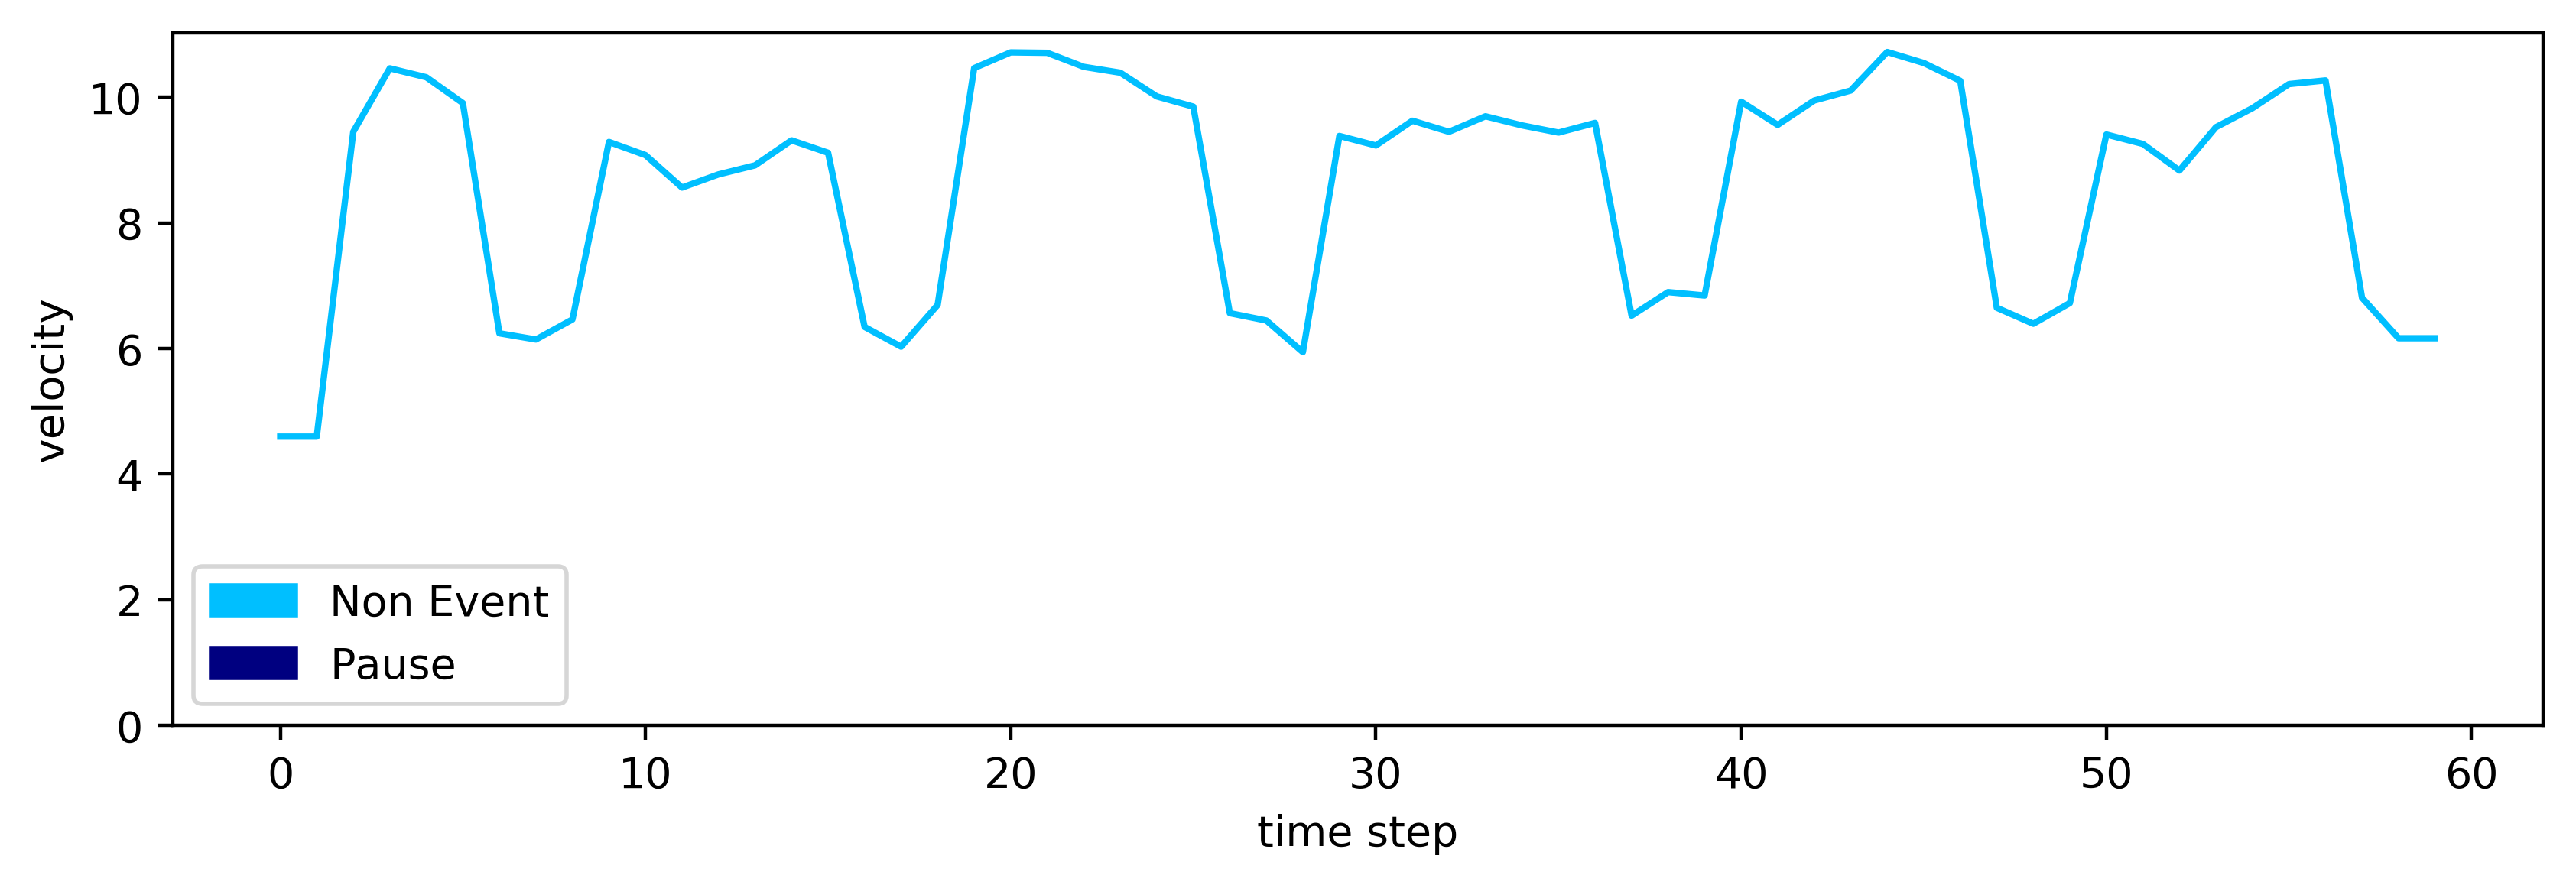

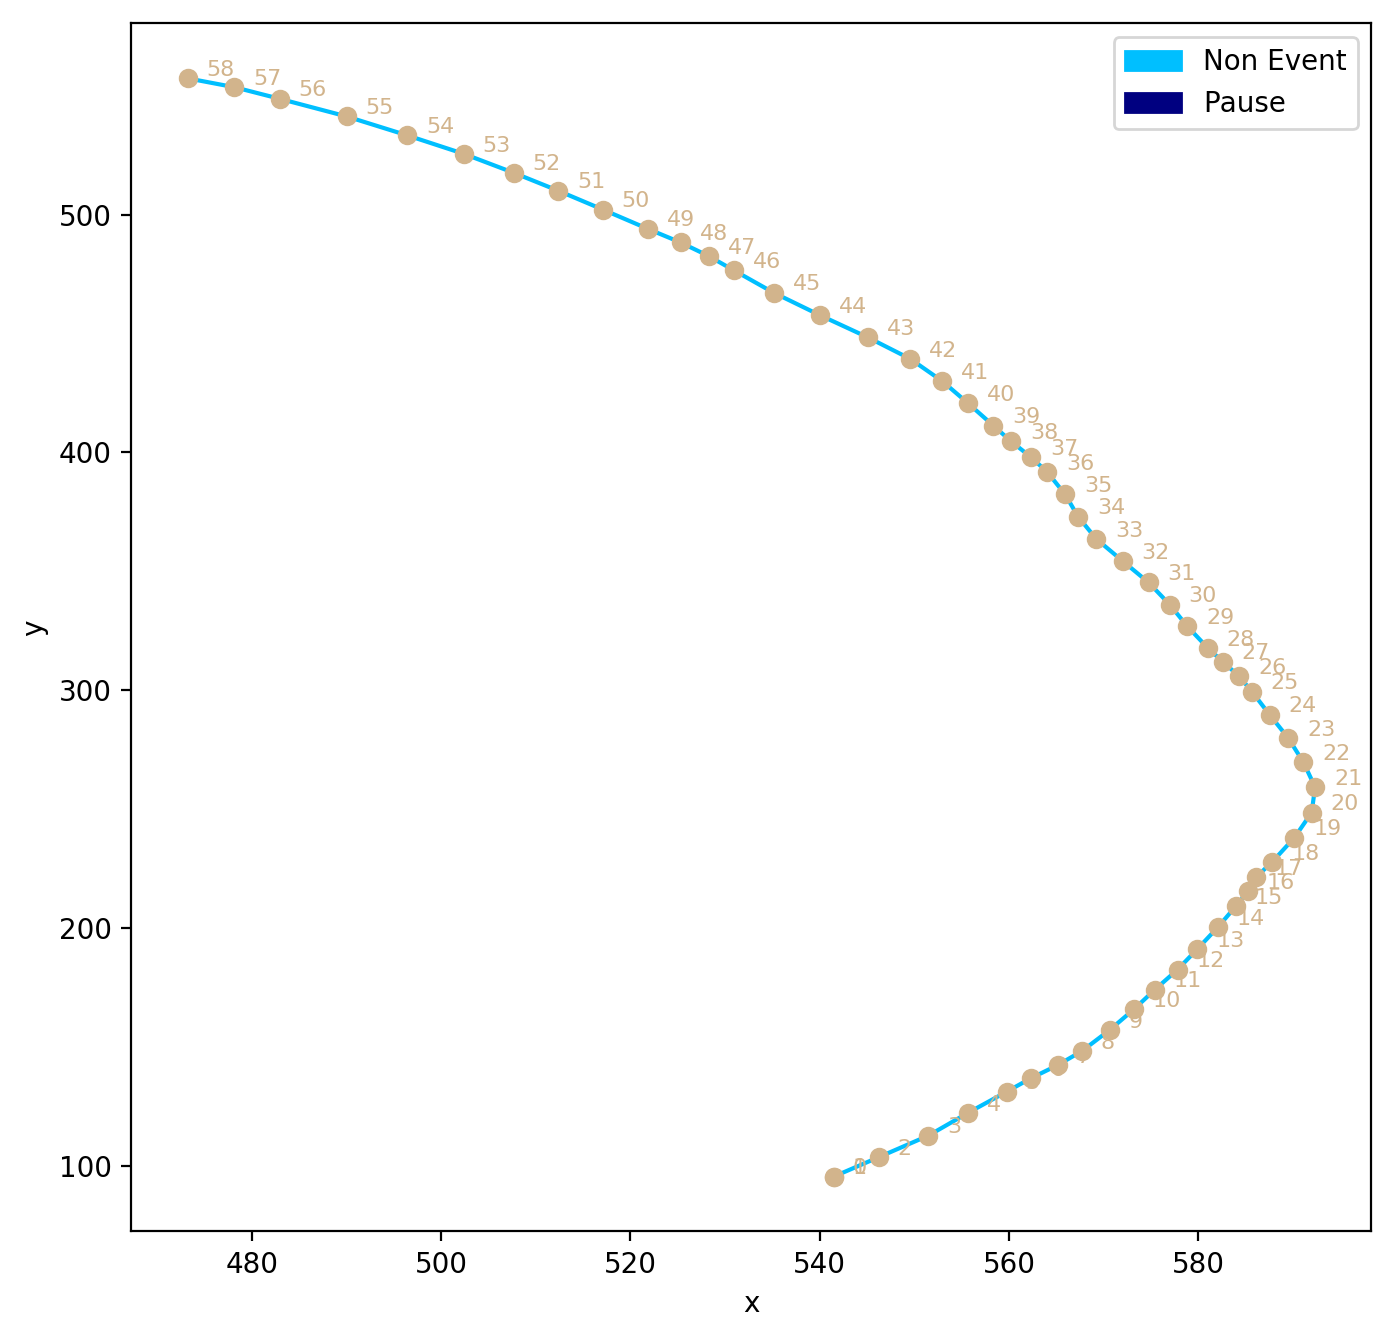

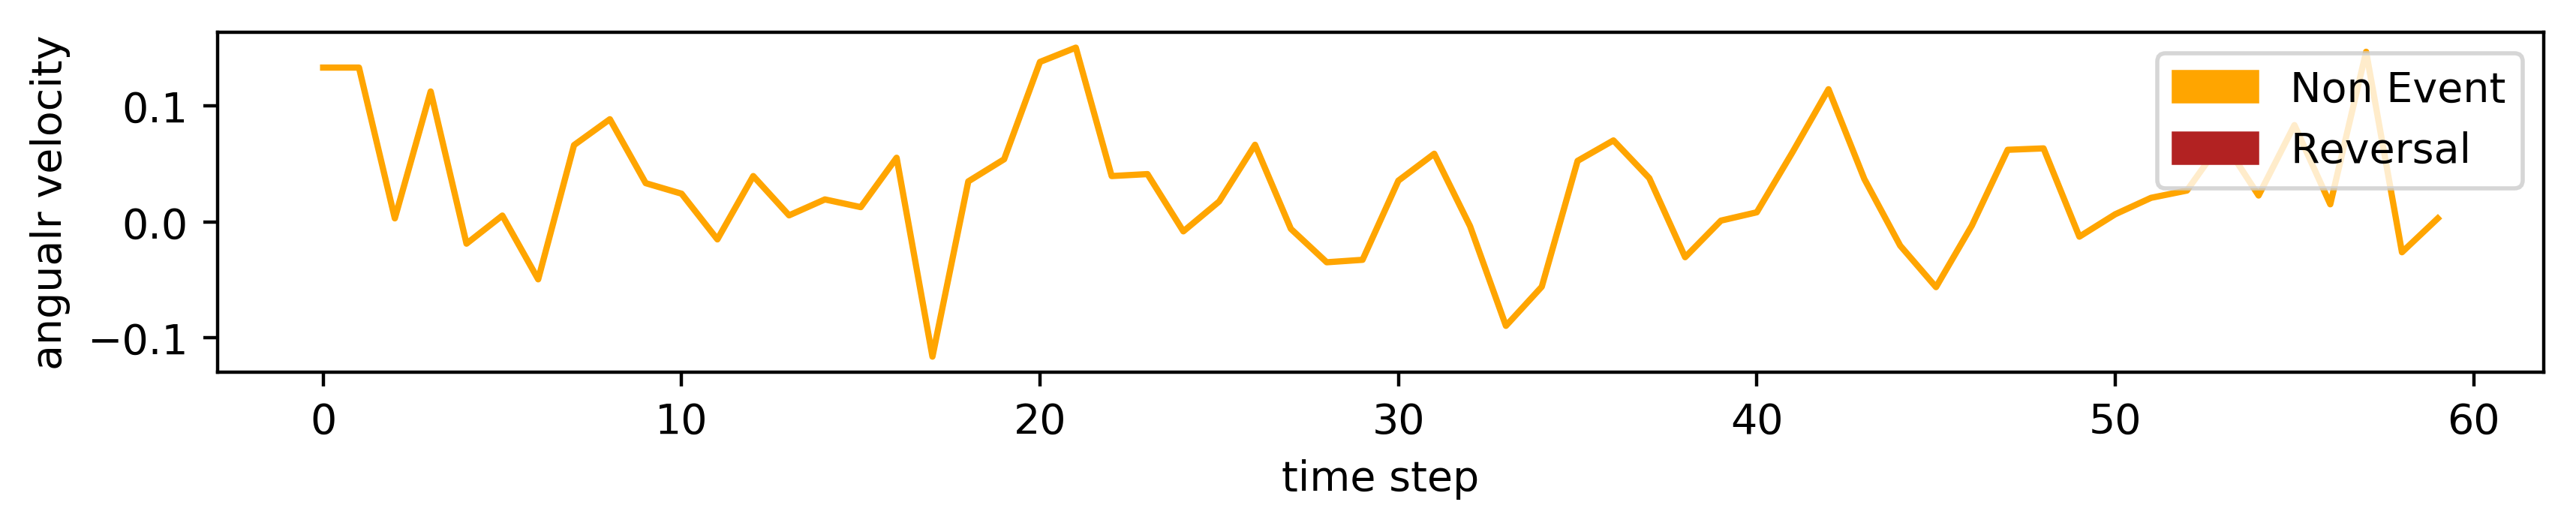

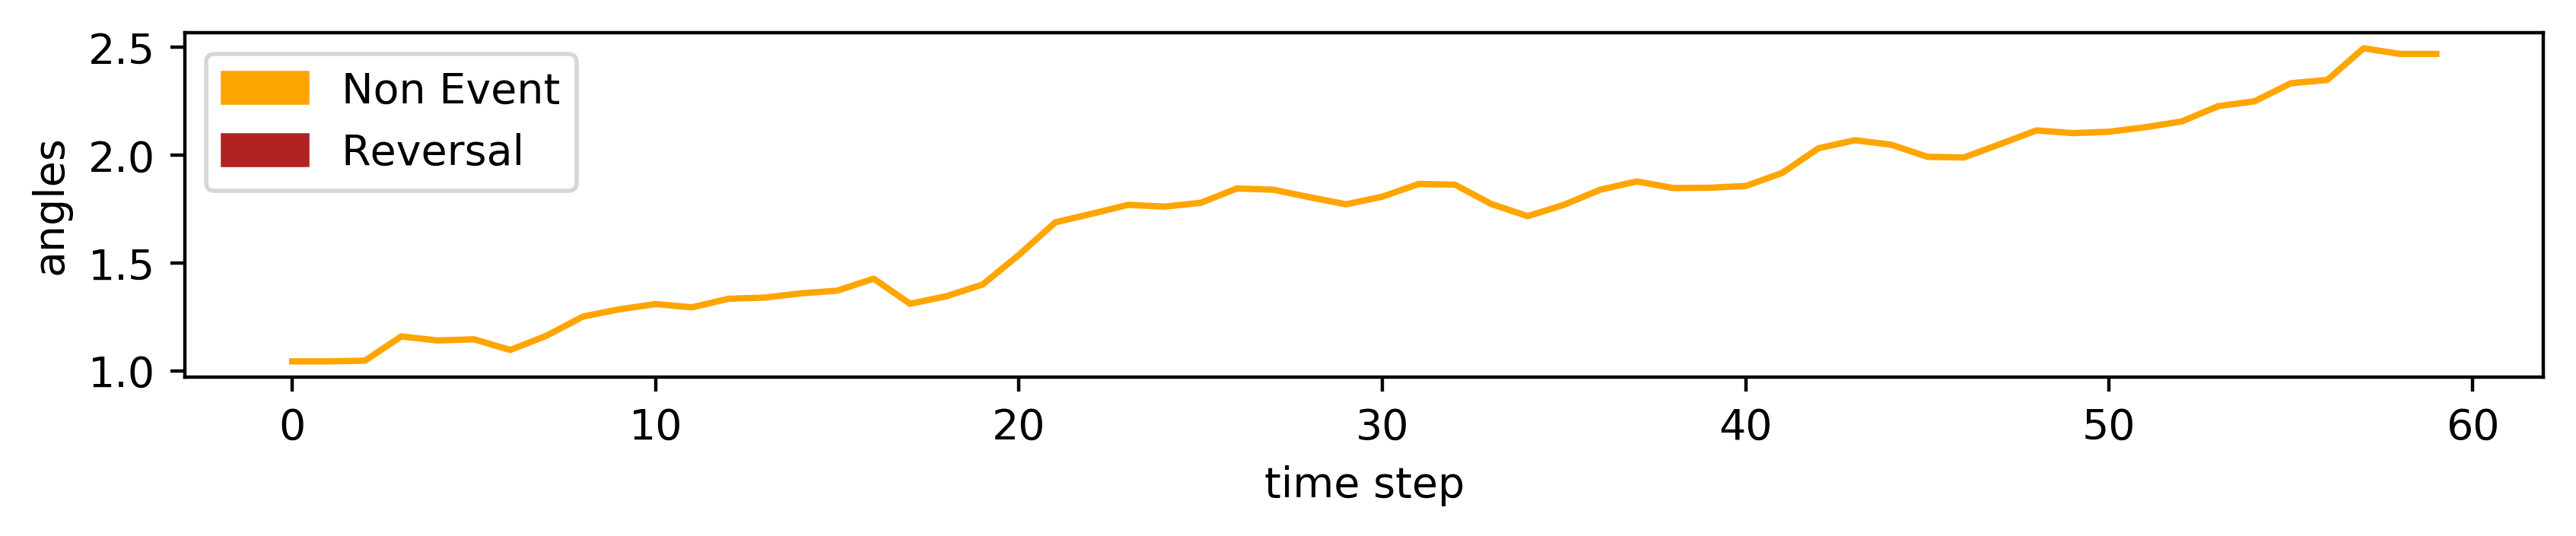

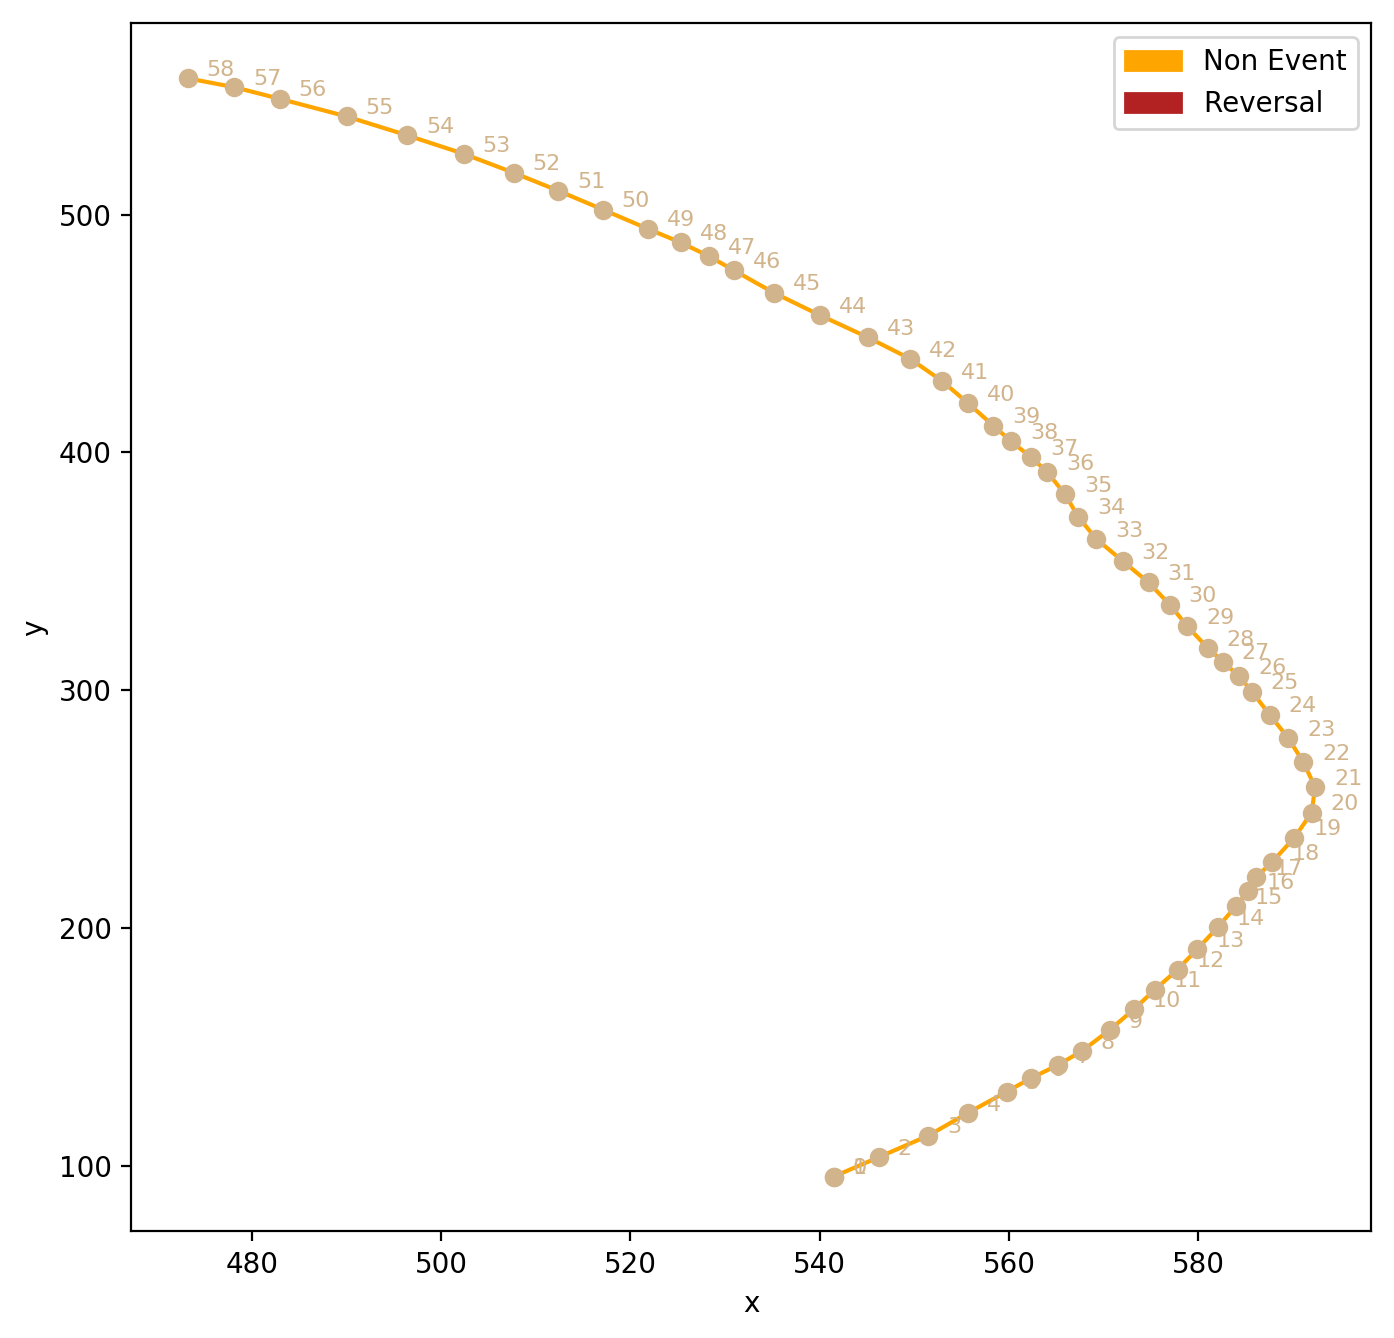

This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 15
local minimum value: 2.31464507775
value before min: 3.41997278532
value after min: 3.45768834021
deltav/2: 3.67735022421
v_upper: 3.78558516743
Index_endleft 14
Index_endright 16
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 37
local minimum value: 1.3596600525
value before min: 1.81978549173
value after min: 3.6725087994
deltav/2: 1.57865903212
v_upper: 1.99112366535
Index_endleft 36
Index_endright 37
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 39
local minimum value: 2.18085168186
value before min: 3.6725087994
value after min: 3.12822145569
deltav/2: 3.0043140526
v_upper: 3.3825773029
Index_endleft 39
Index_endright 40
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 47
local minimum value: 1.47075425103
value before min: 2.42725272656
value afte

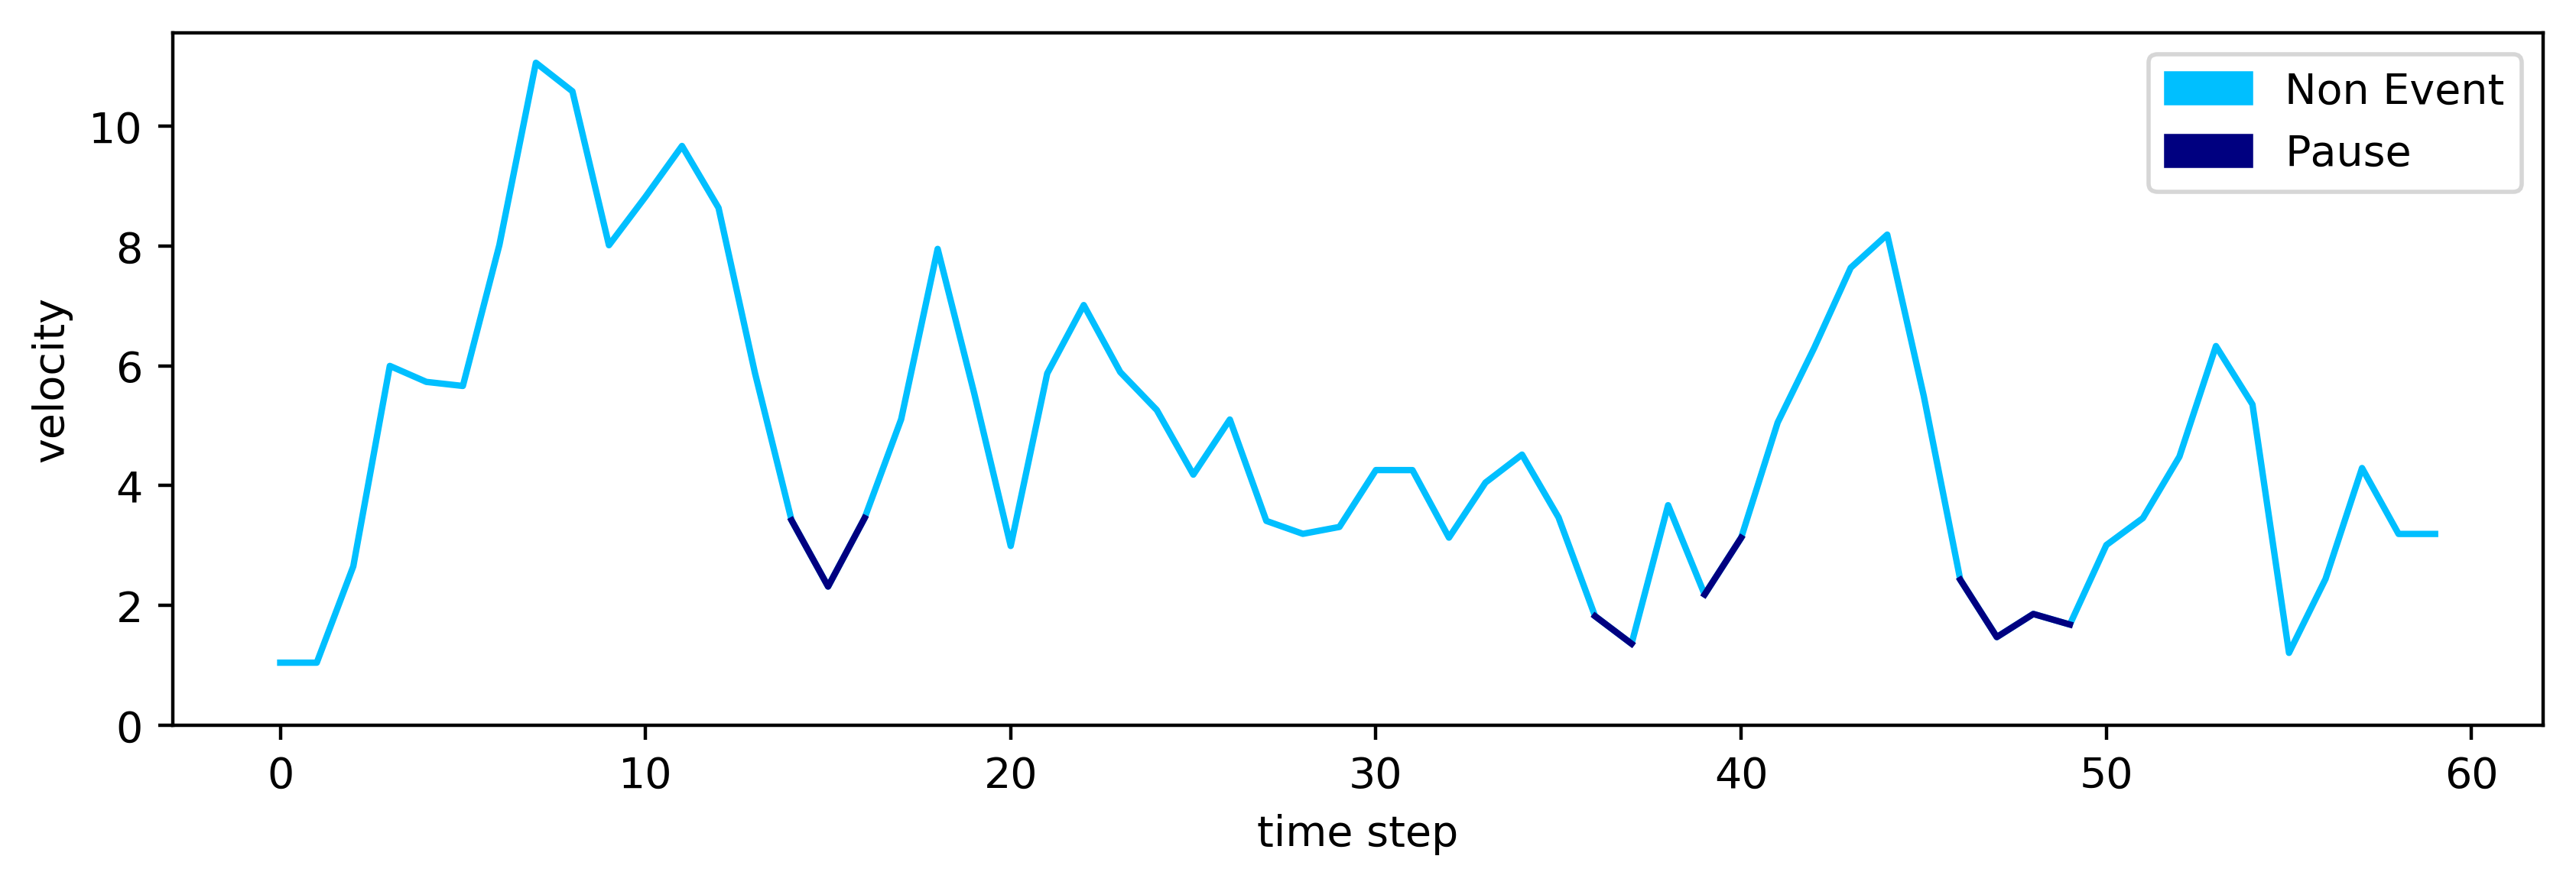

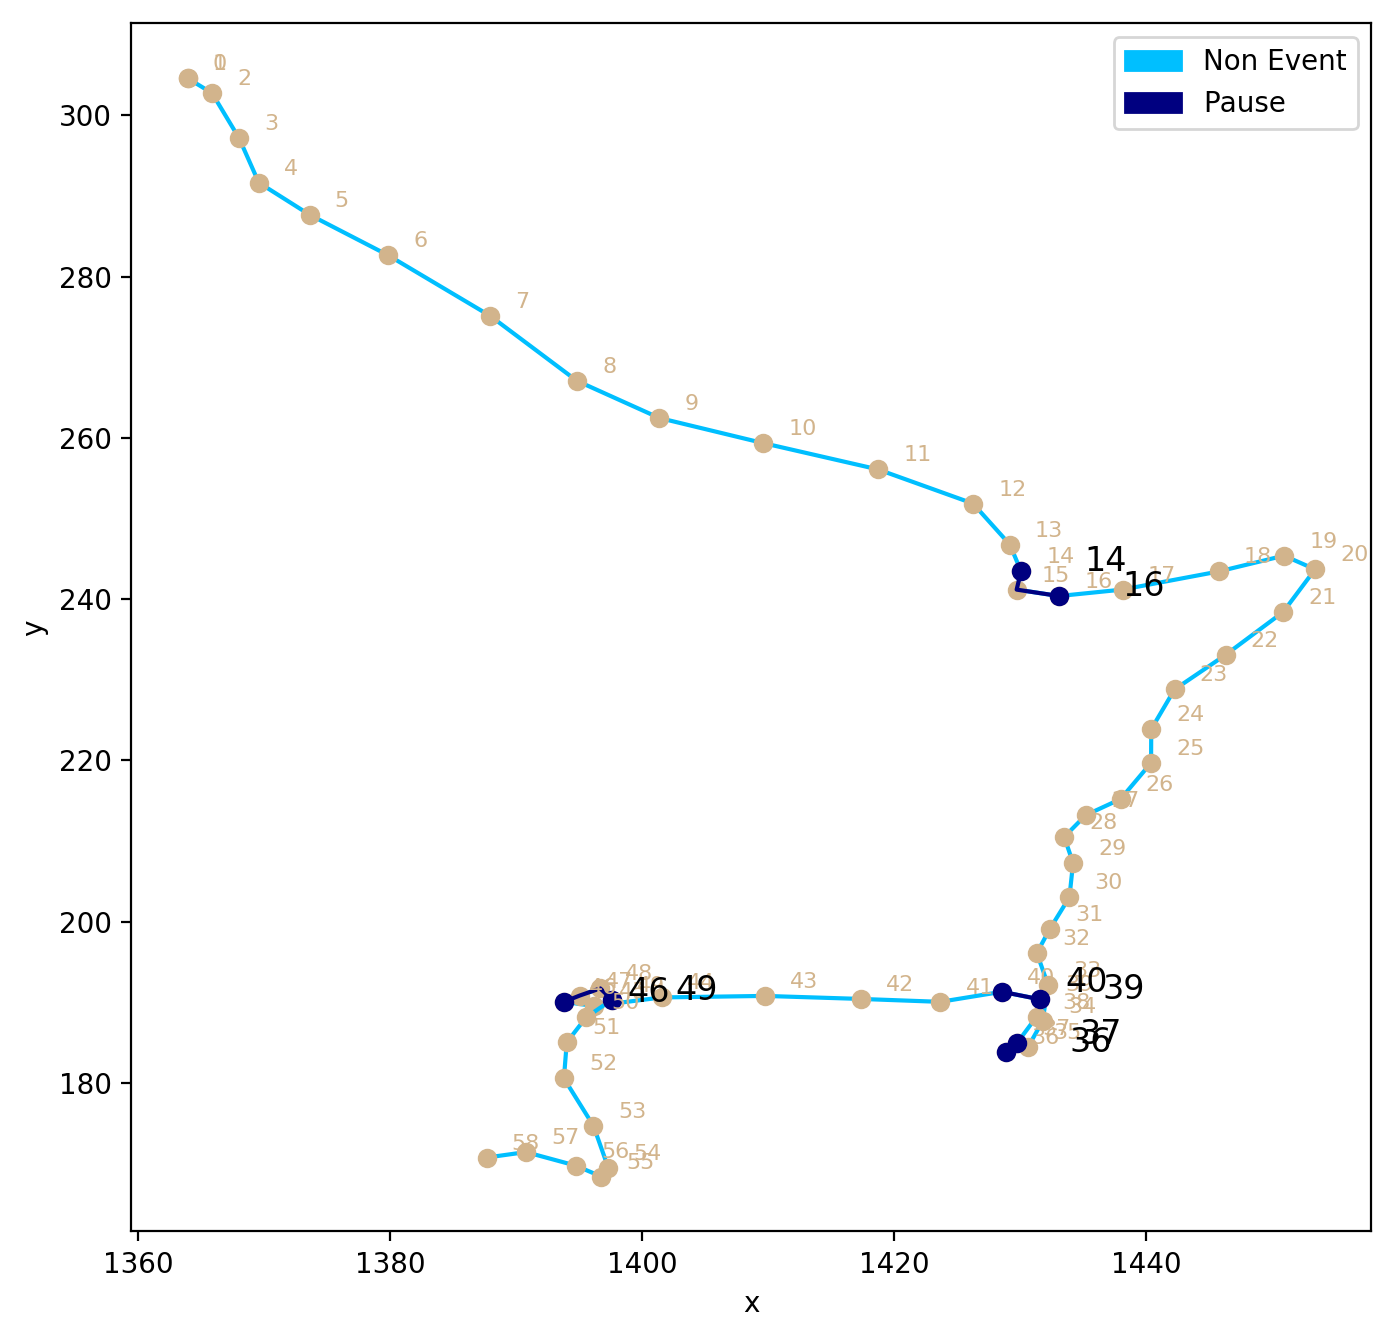

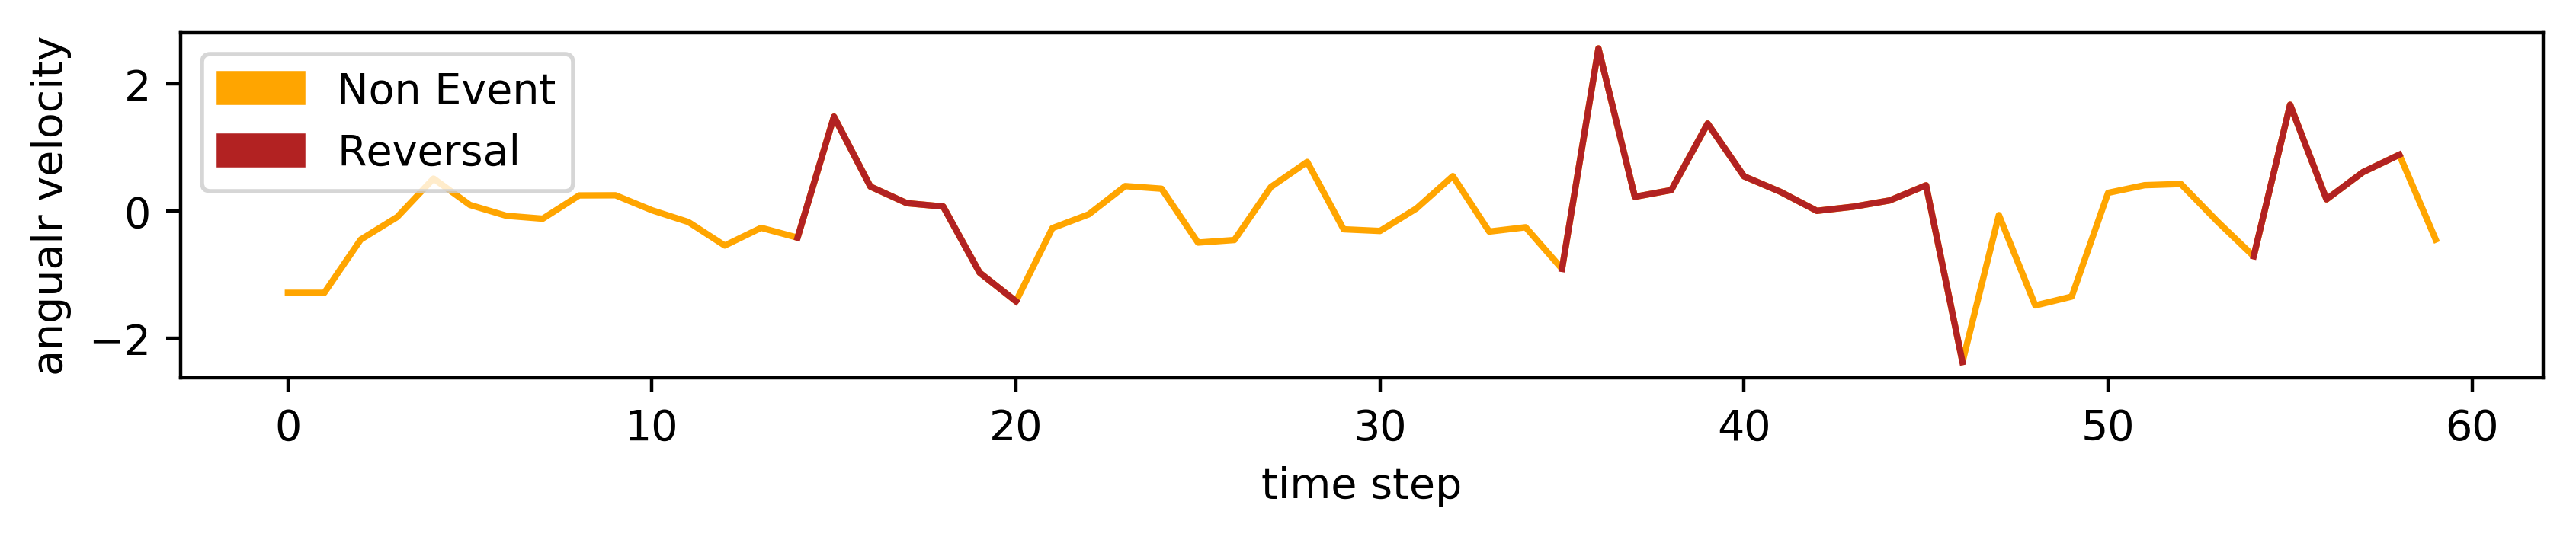

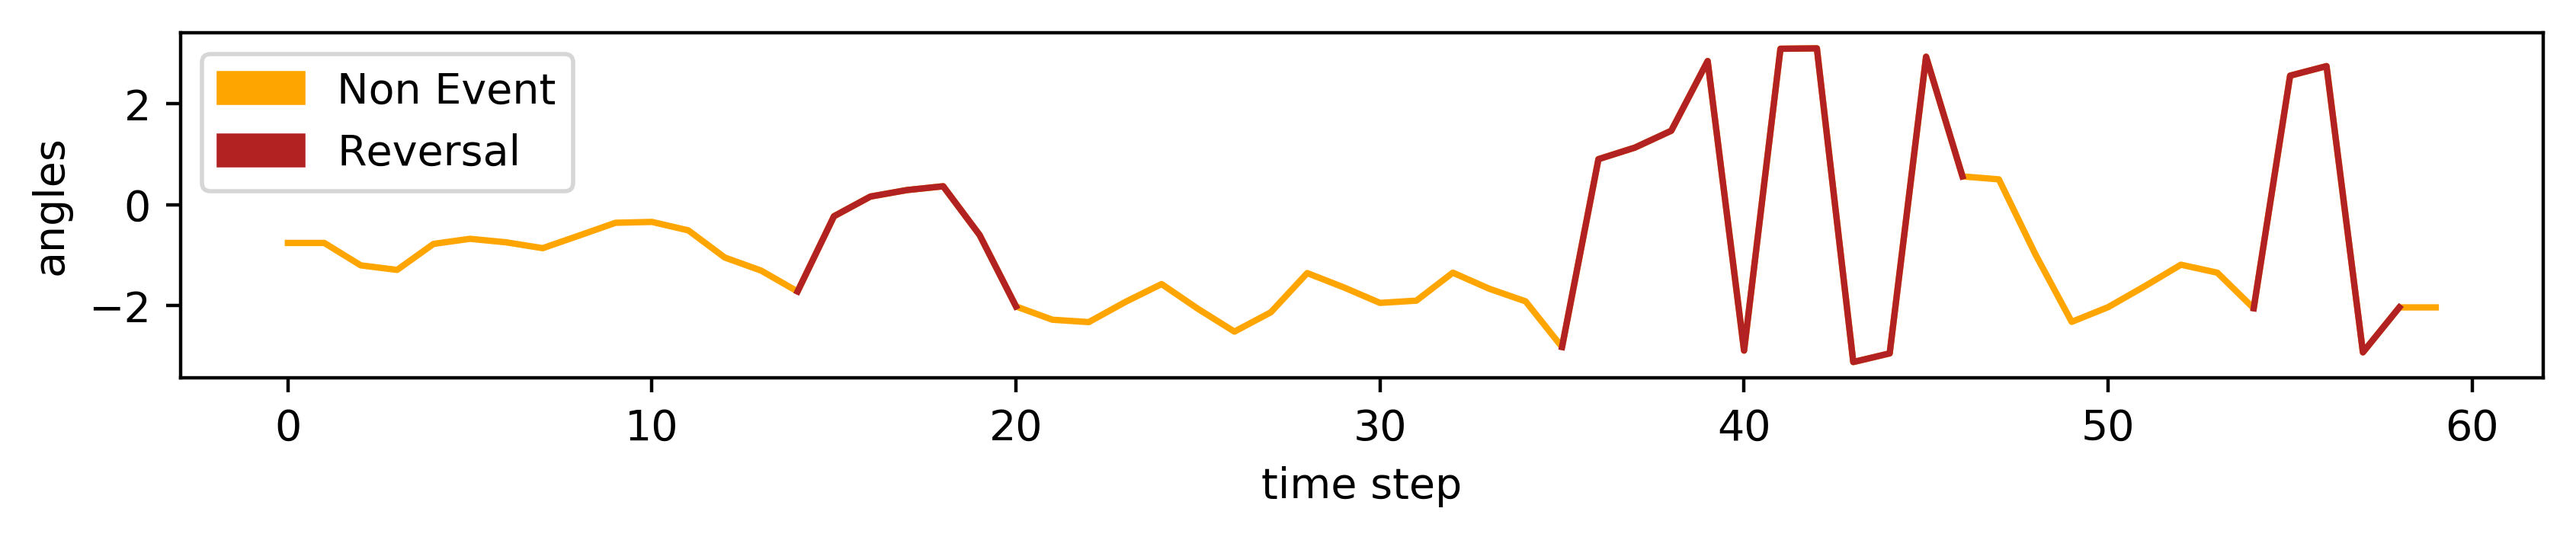

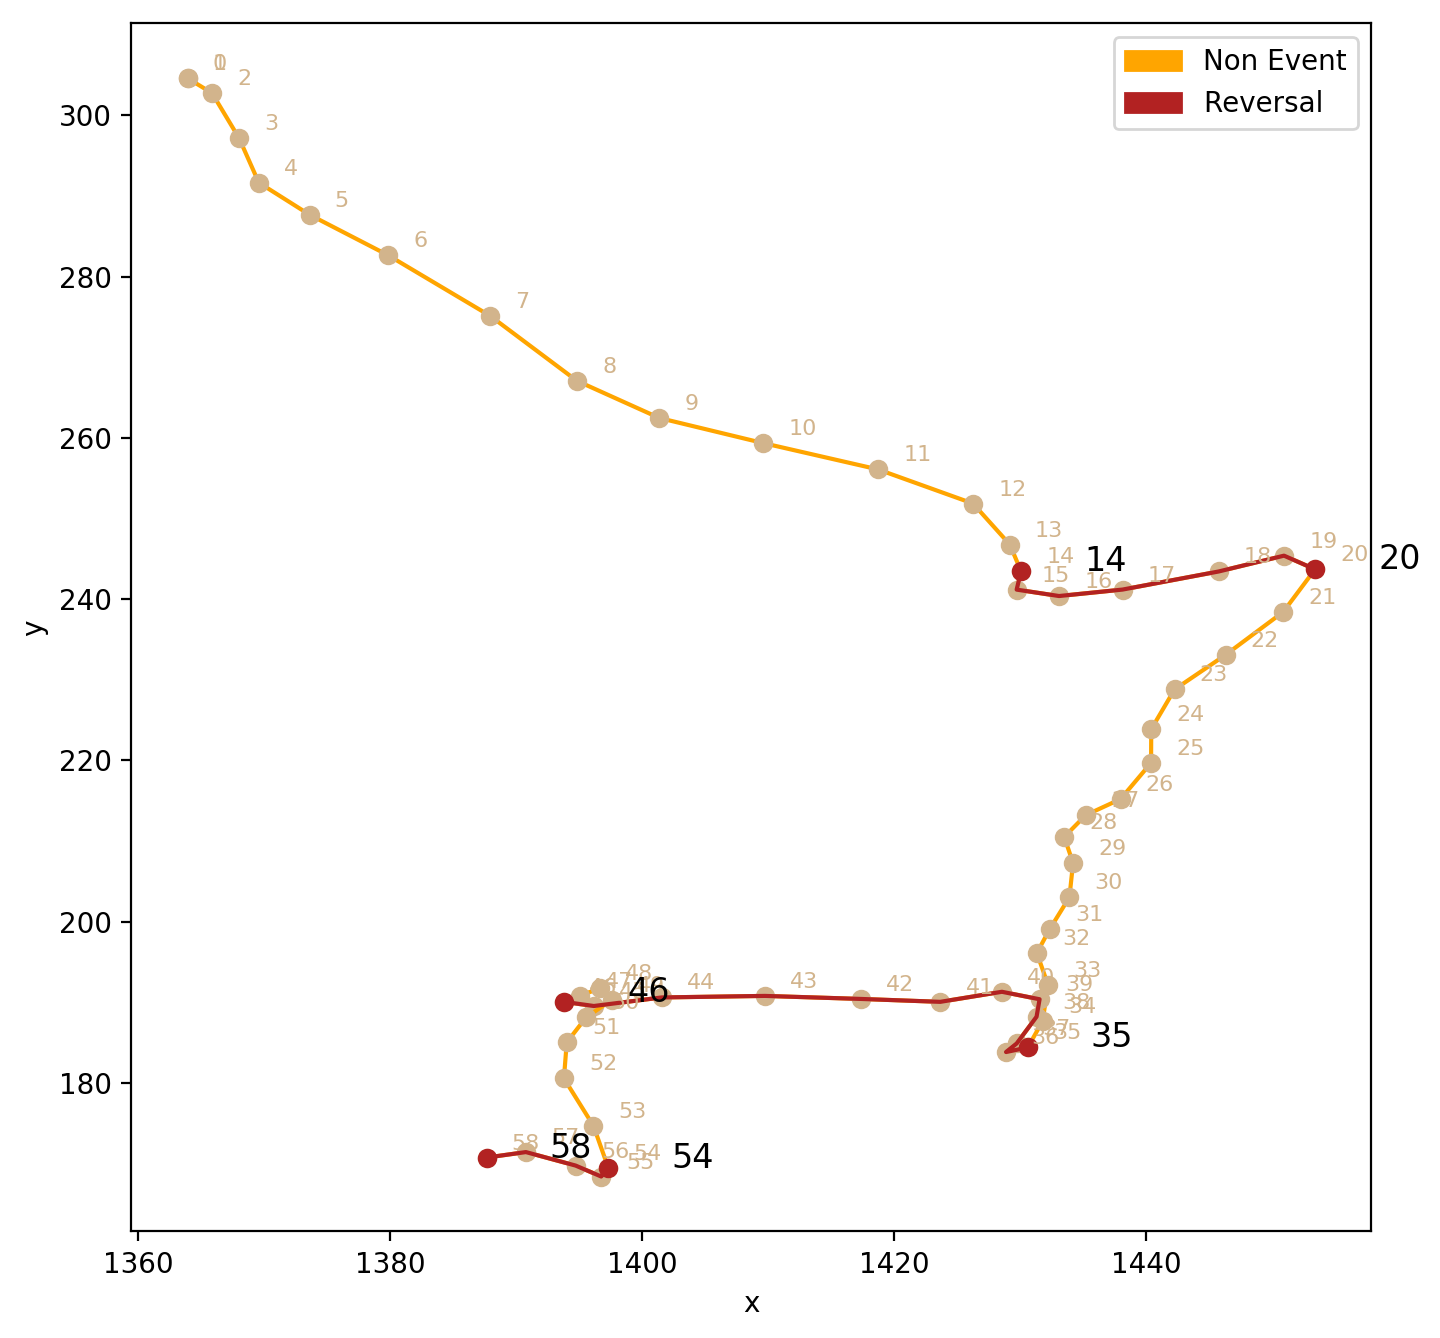

This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 8
local minimum value: 2.11520923876
value before min: 2.84361529356
value after min: 3.85357562757
deltav/2: 2.14075673384
v_upper: 2.9715119323
Index_endleft 7
Index_endright 8
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 26
local minimum value: 1.19477016749
value before min: 3.17084891608
value after min: 2.37991393166
deltav/2: 2.5921616988
v_upper: 2.23163484701
Index_endleft 26
Index_endright 26


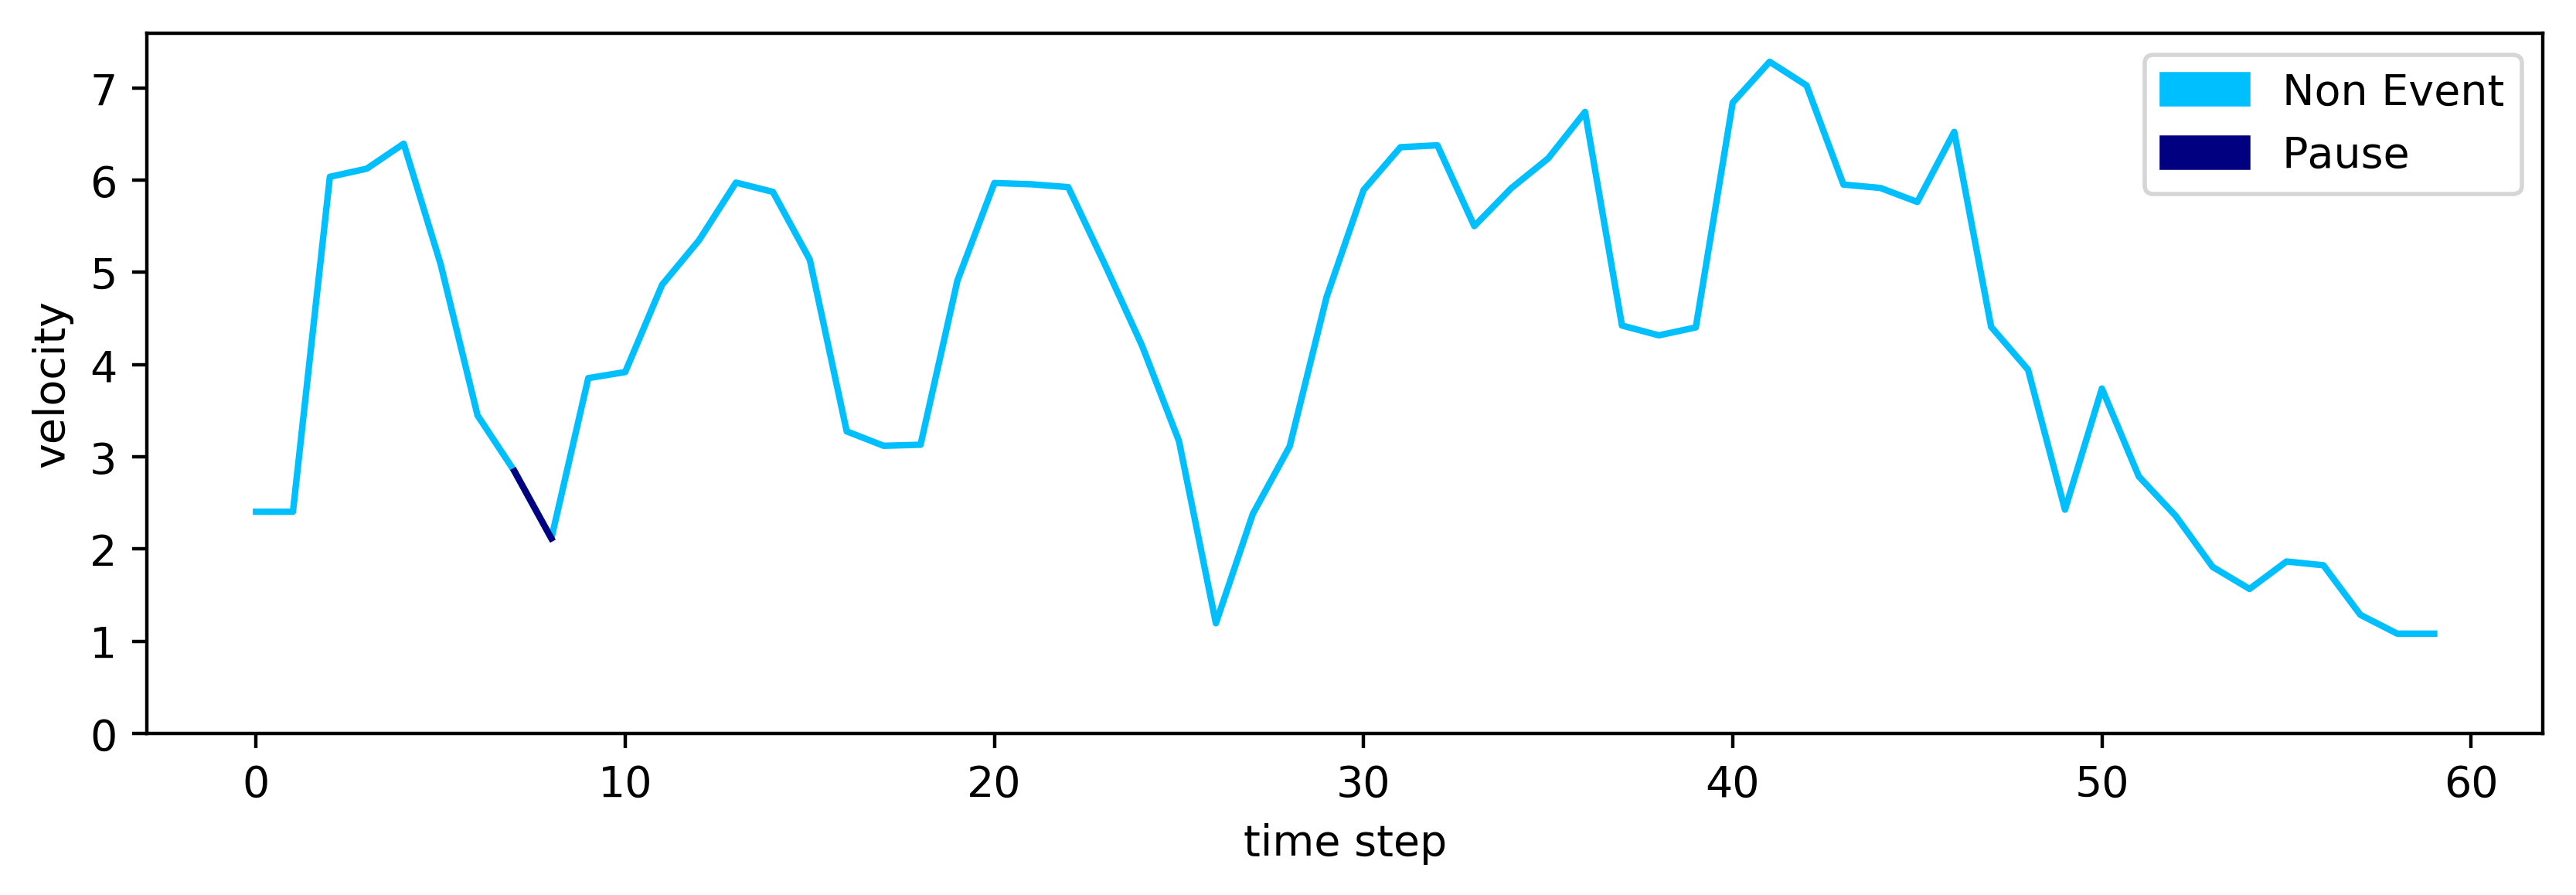

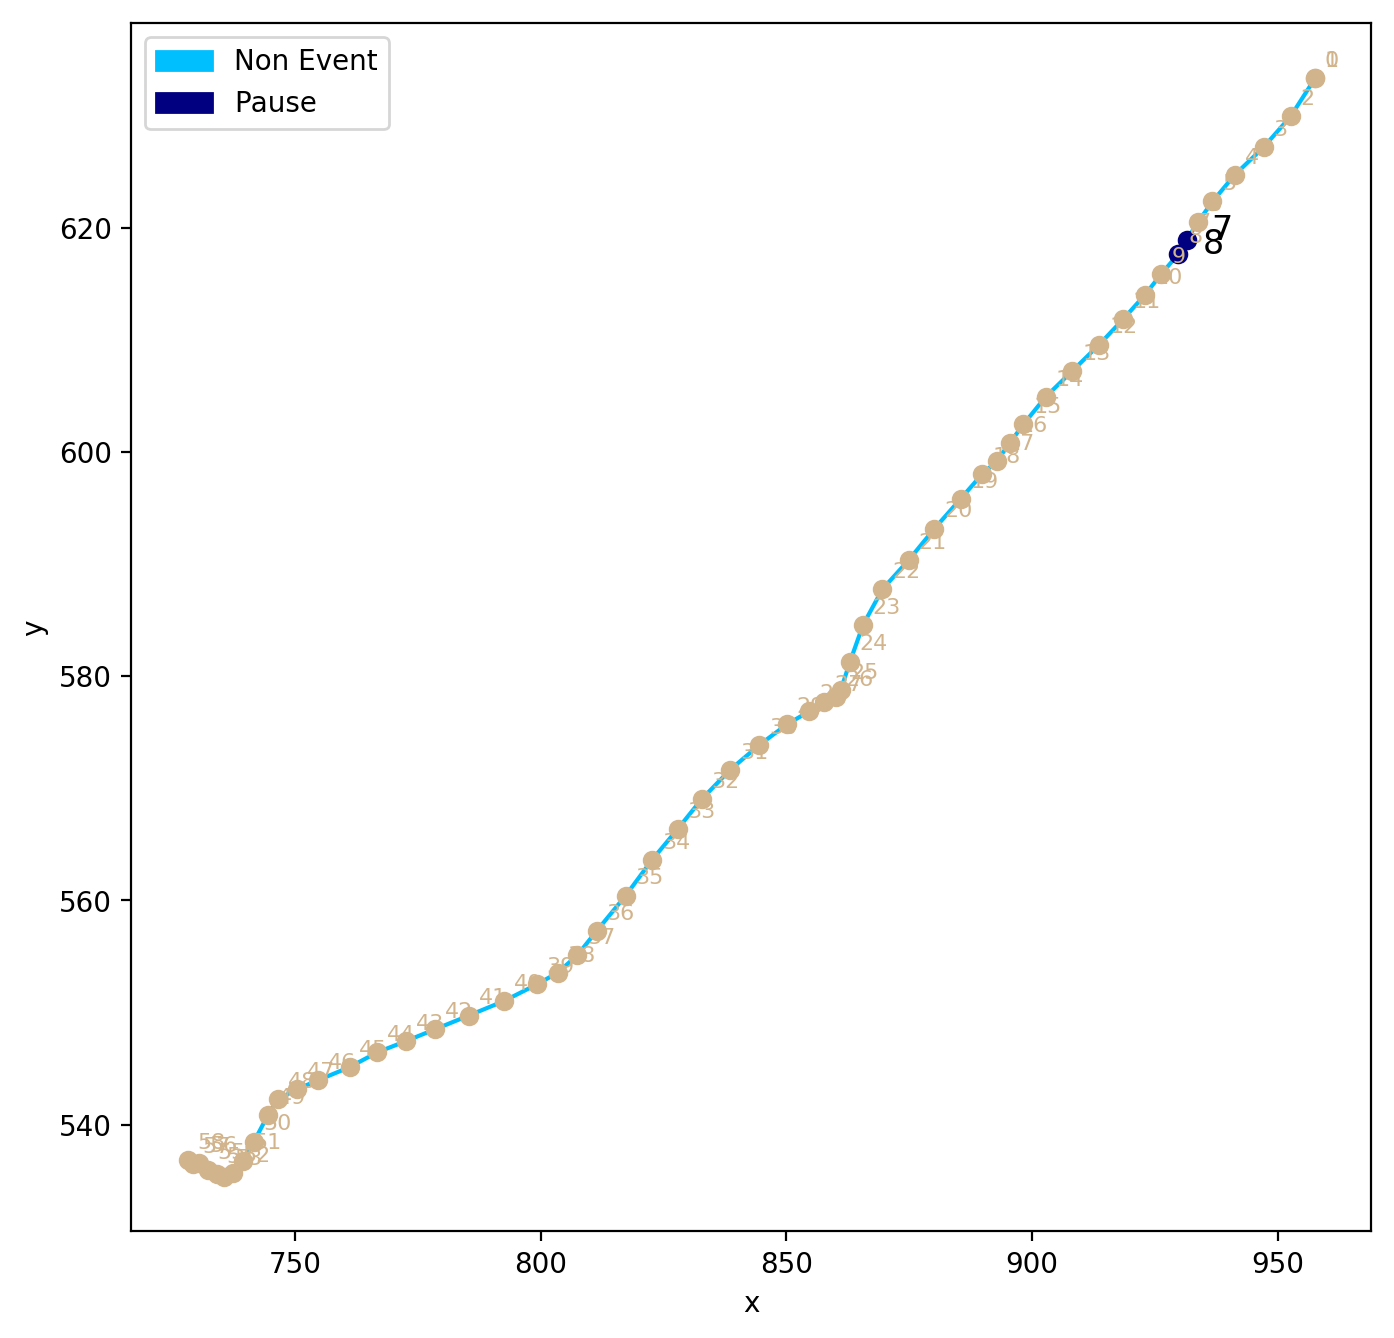

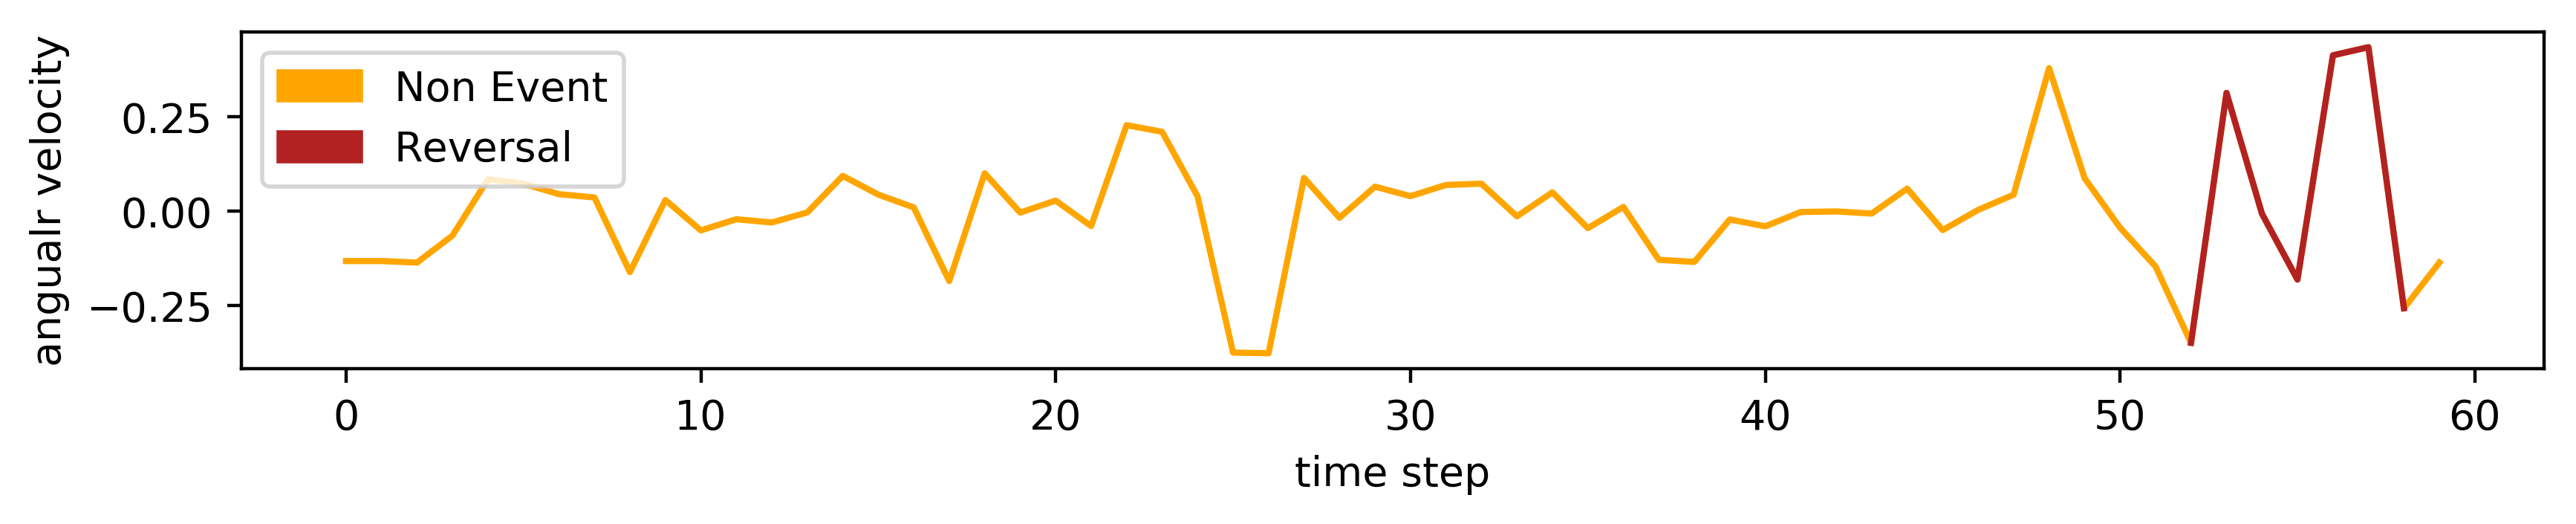

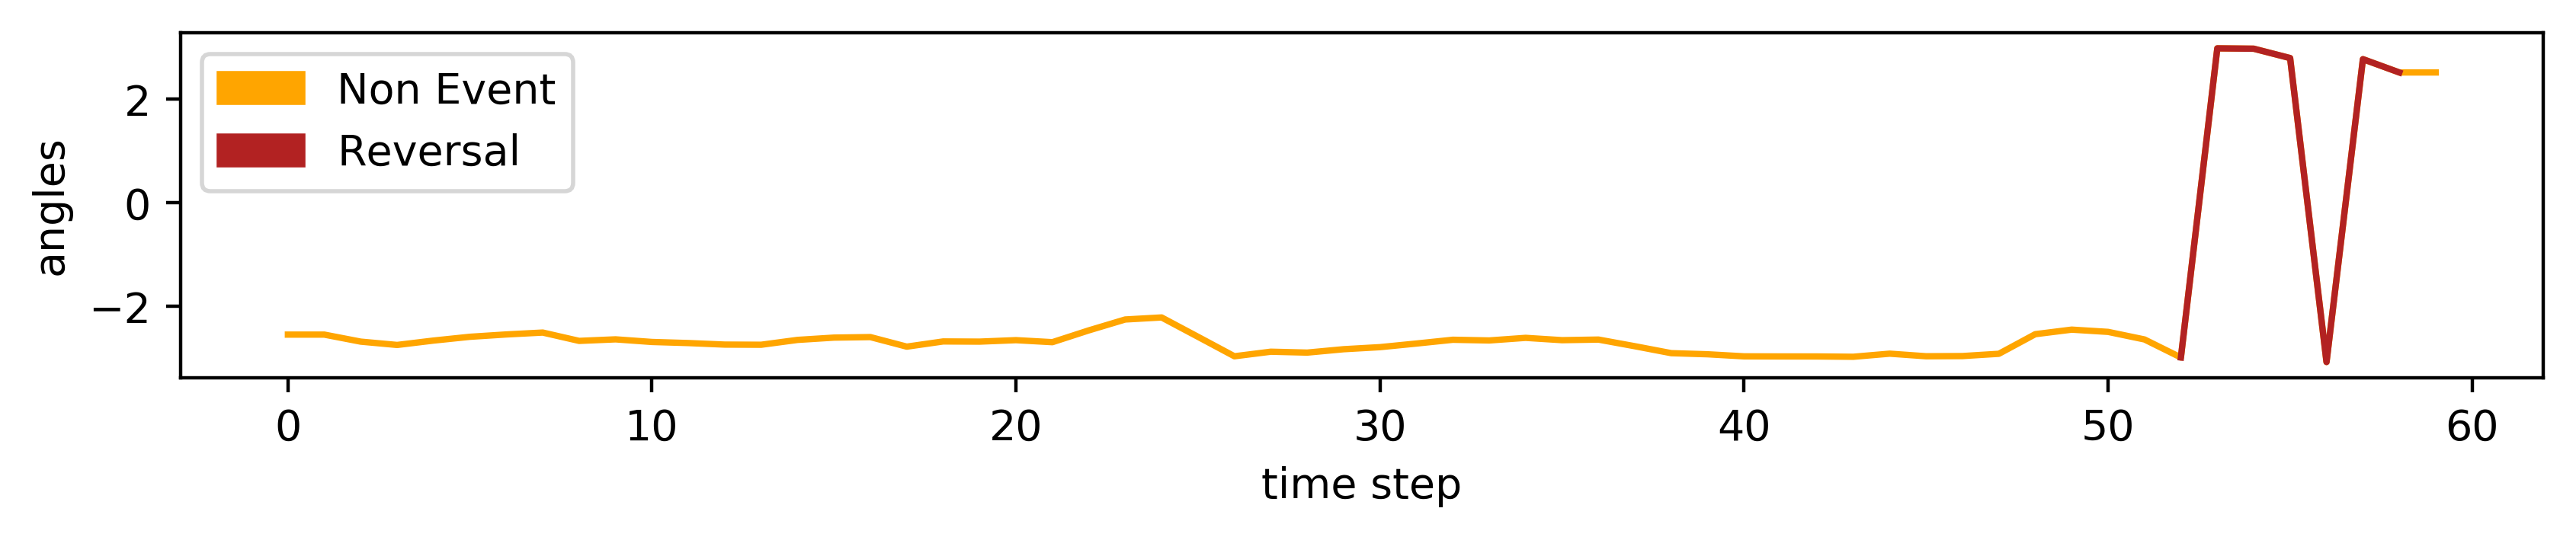

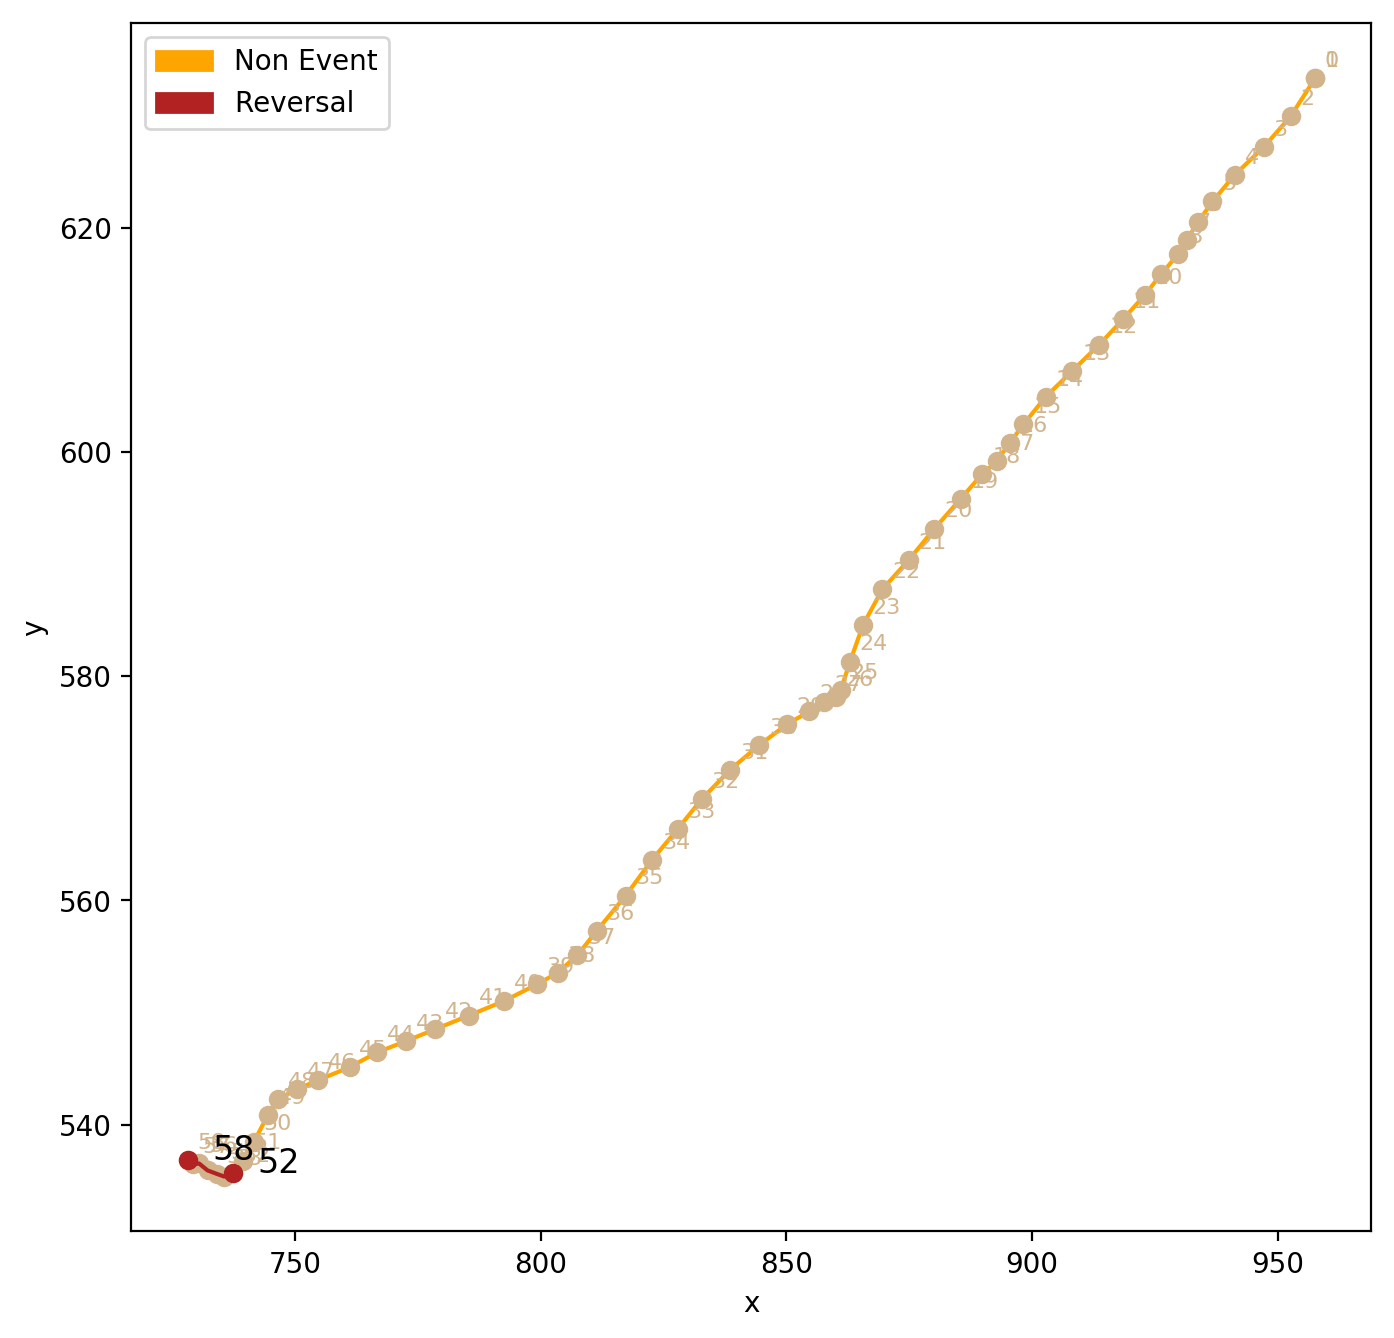

This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 11
local minimum value: 2.12484287711
value before min: 2.19693366055
value after min: 2.43553017519
deltav/2: 4.30873231197
v_upper: 3.8483358019
Index_endleft 10
Index_endright 16
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 23
local minimum value: 0.772826714048
value before min: 1.89075200752
value after min: 1.66771747222
deltav/2: 1.92579822839
v_upper: 1.5431460054
Index_endleft 23
Index_endright 23
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 27
local minimum value: 0.485791579685
value before min: 1.73757166006
value after min: 0.745358053953
deltav/2: 0.625890040186
v_upper: 0.73614759576
Index_endleft 27
Index_endright 27
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 36
local minimum value: 0.160863561265
value before min: 0.458359994303
v

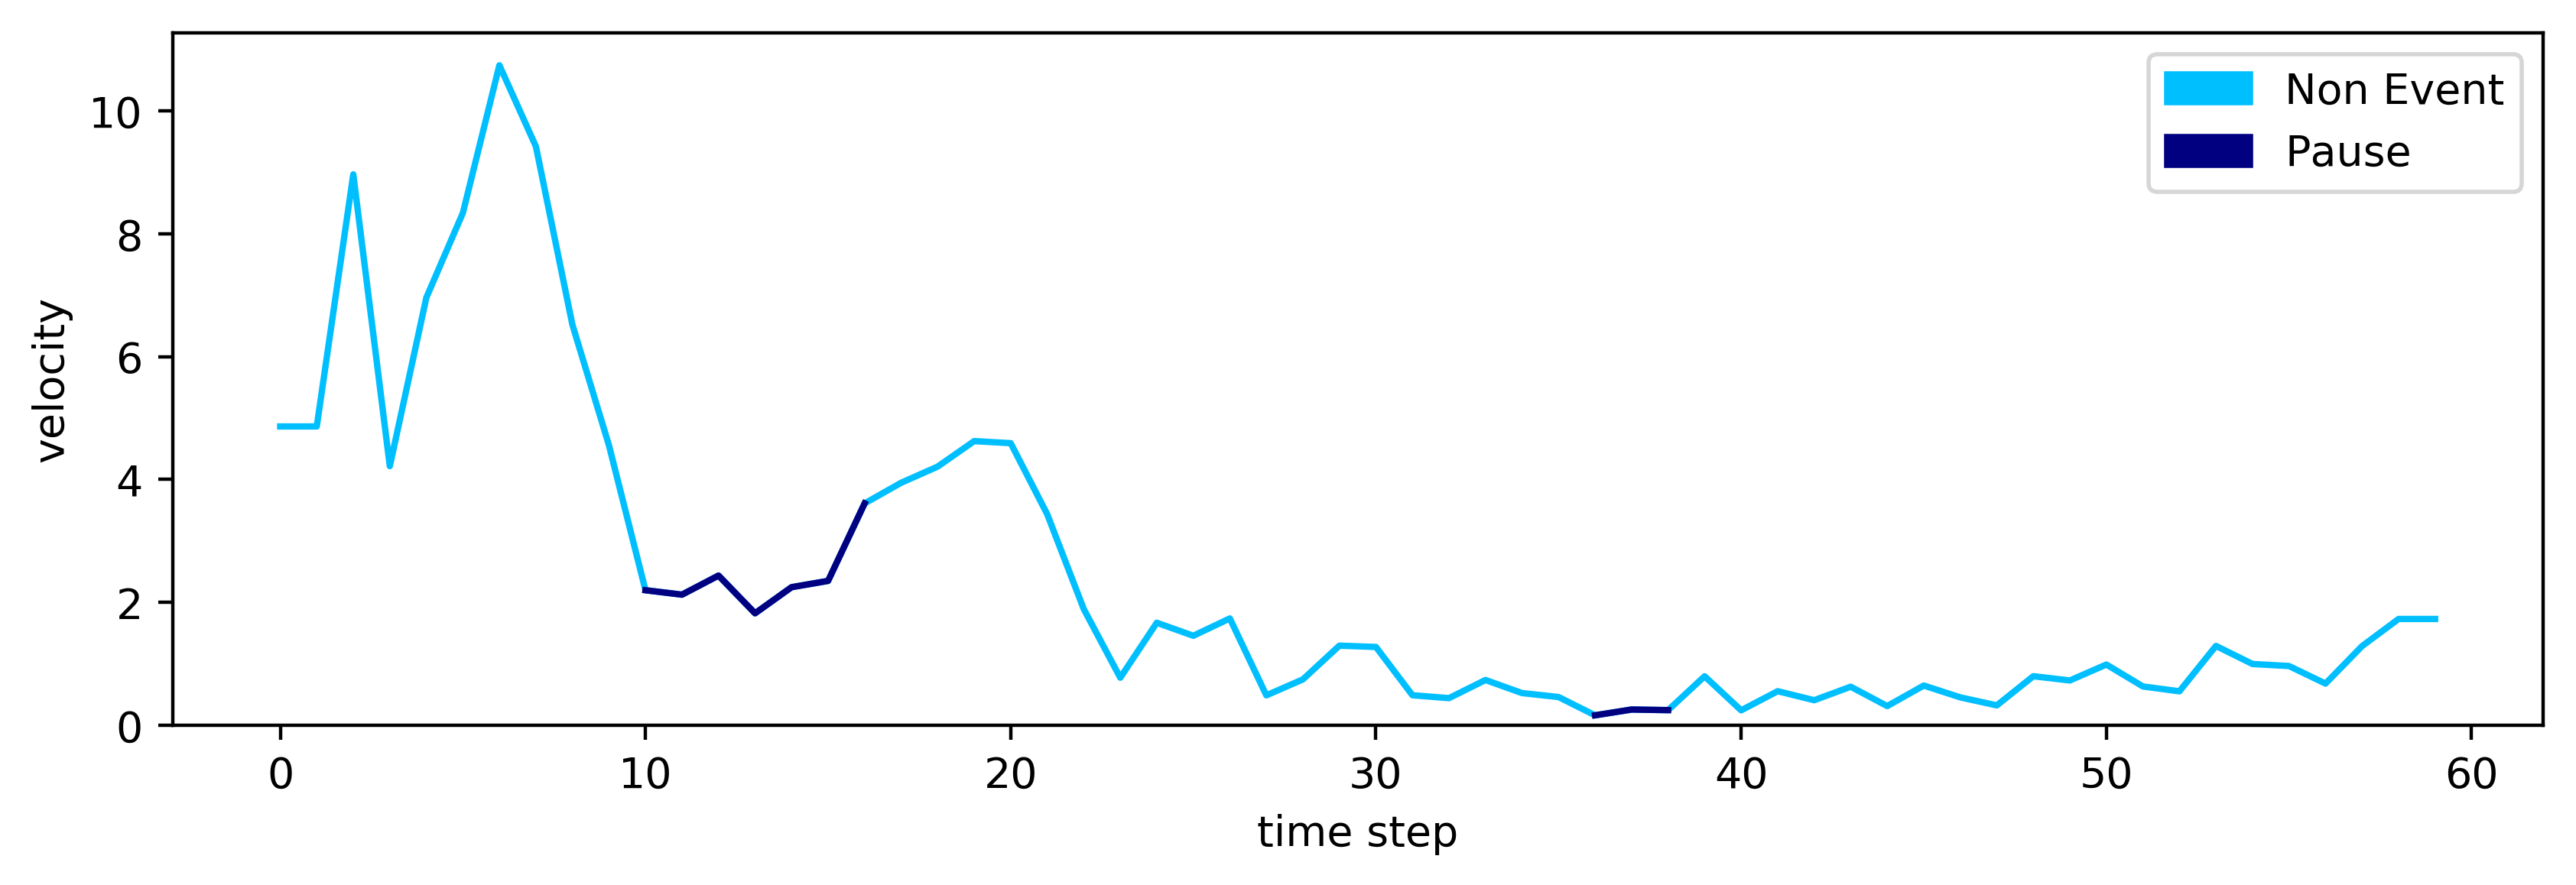

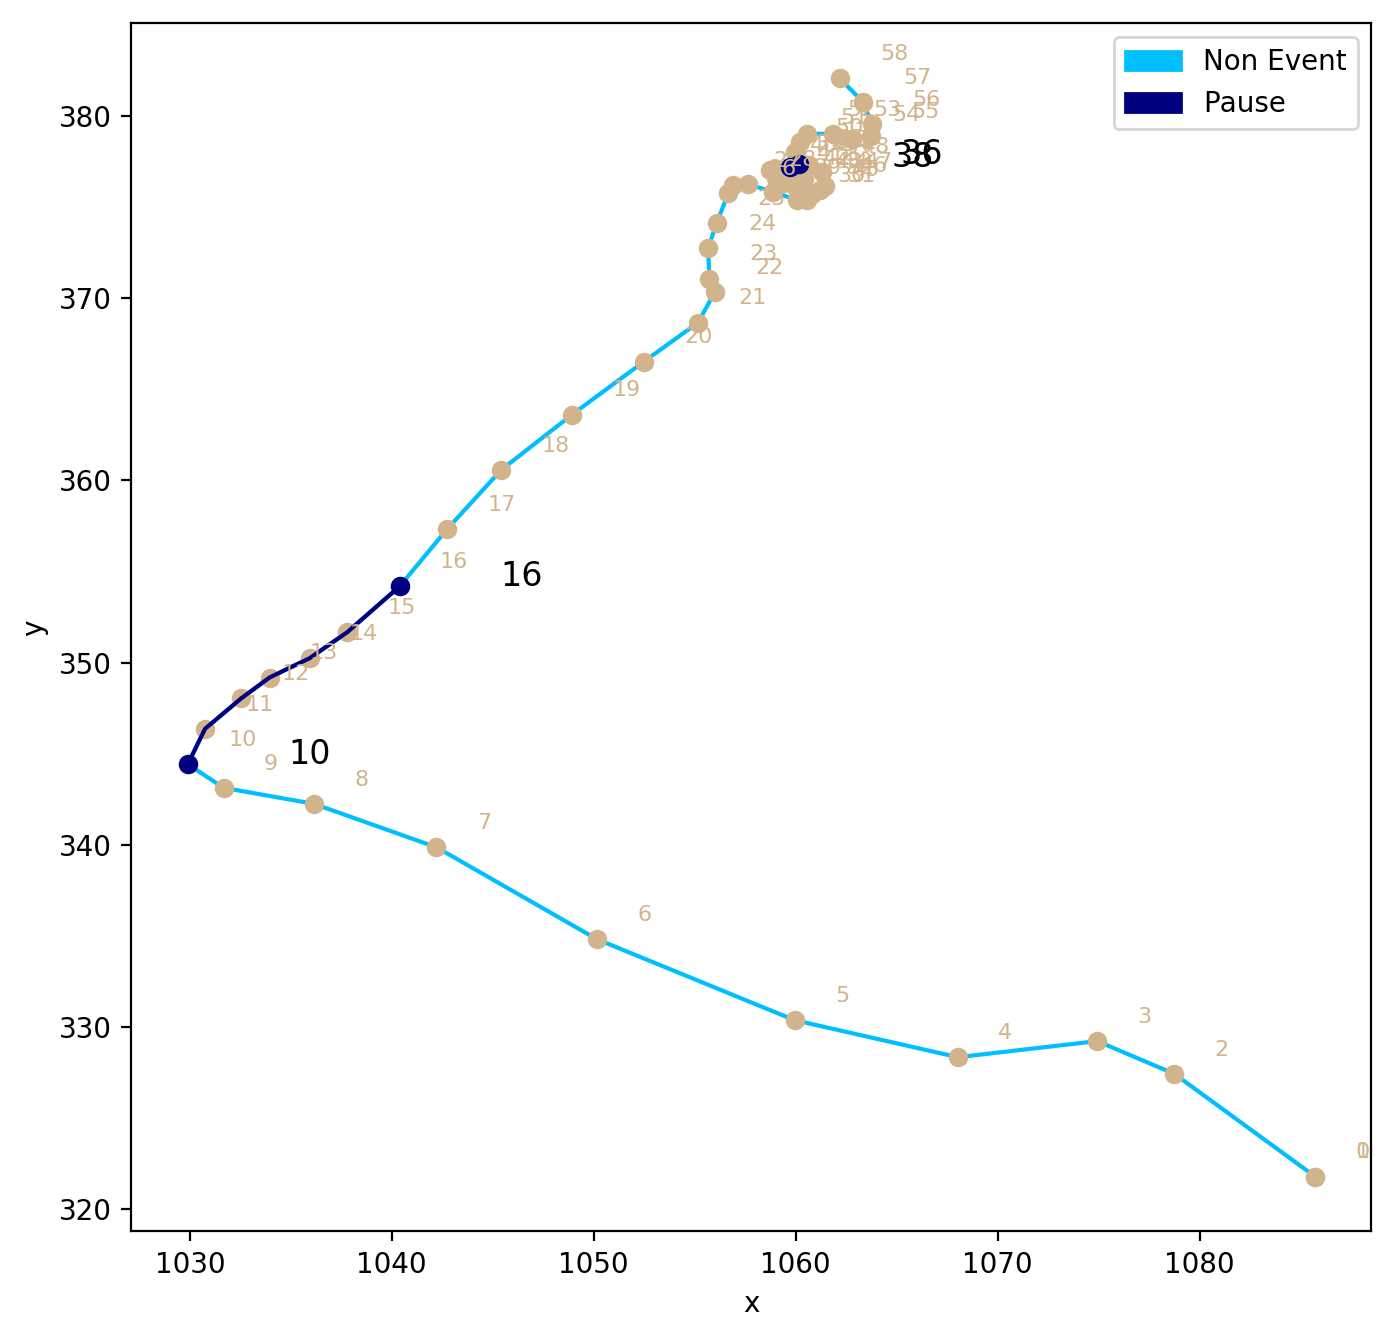

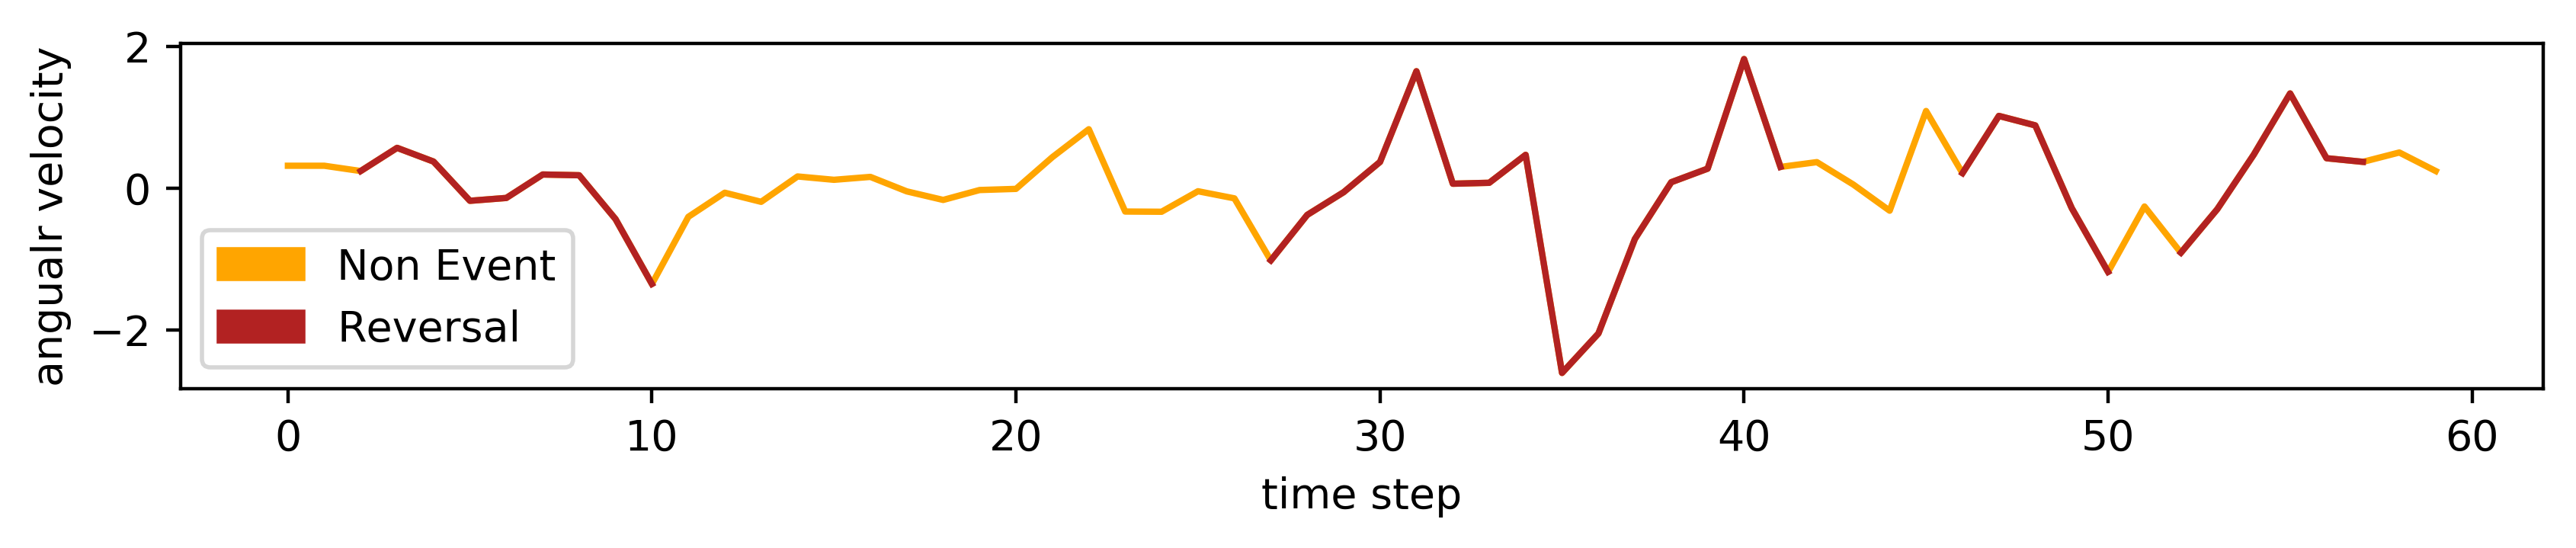

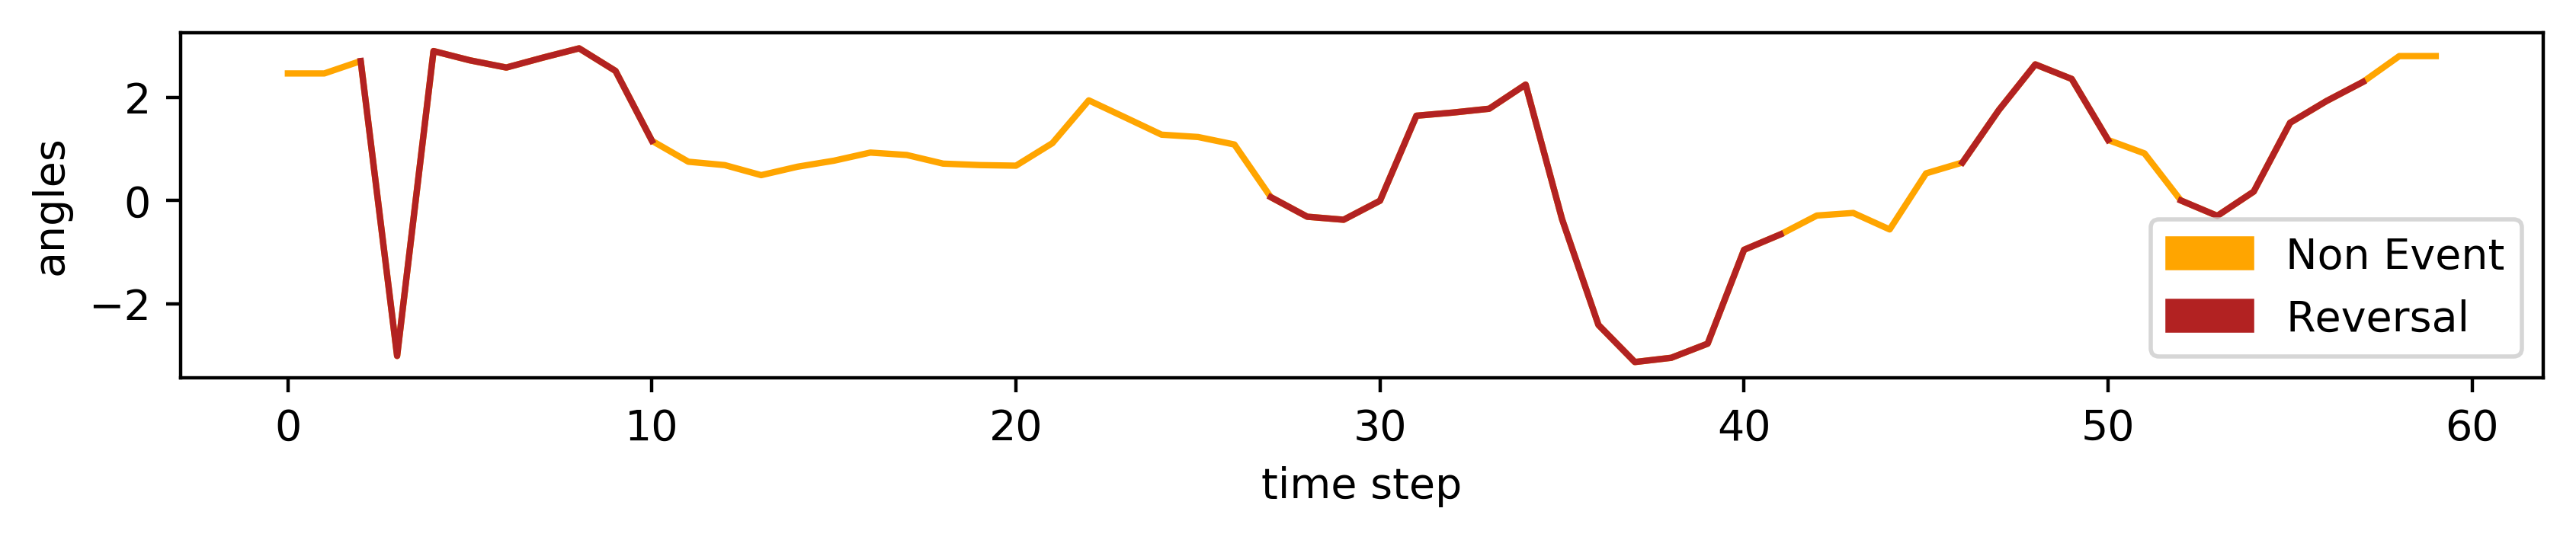

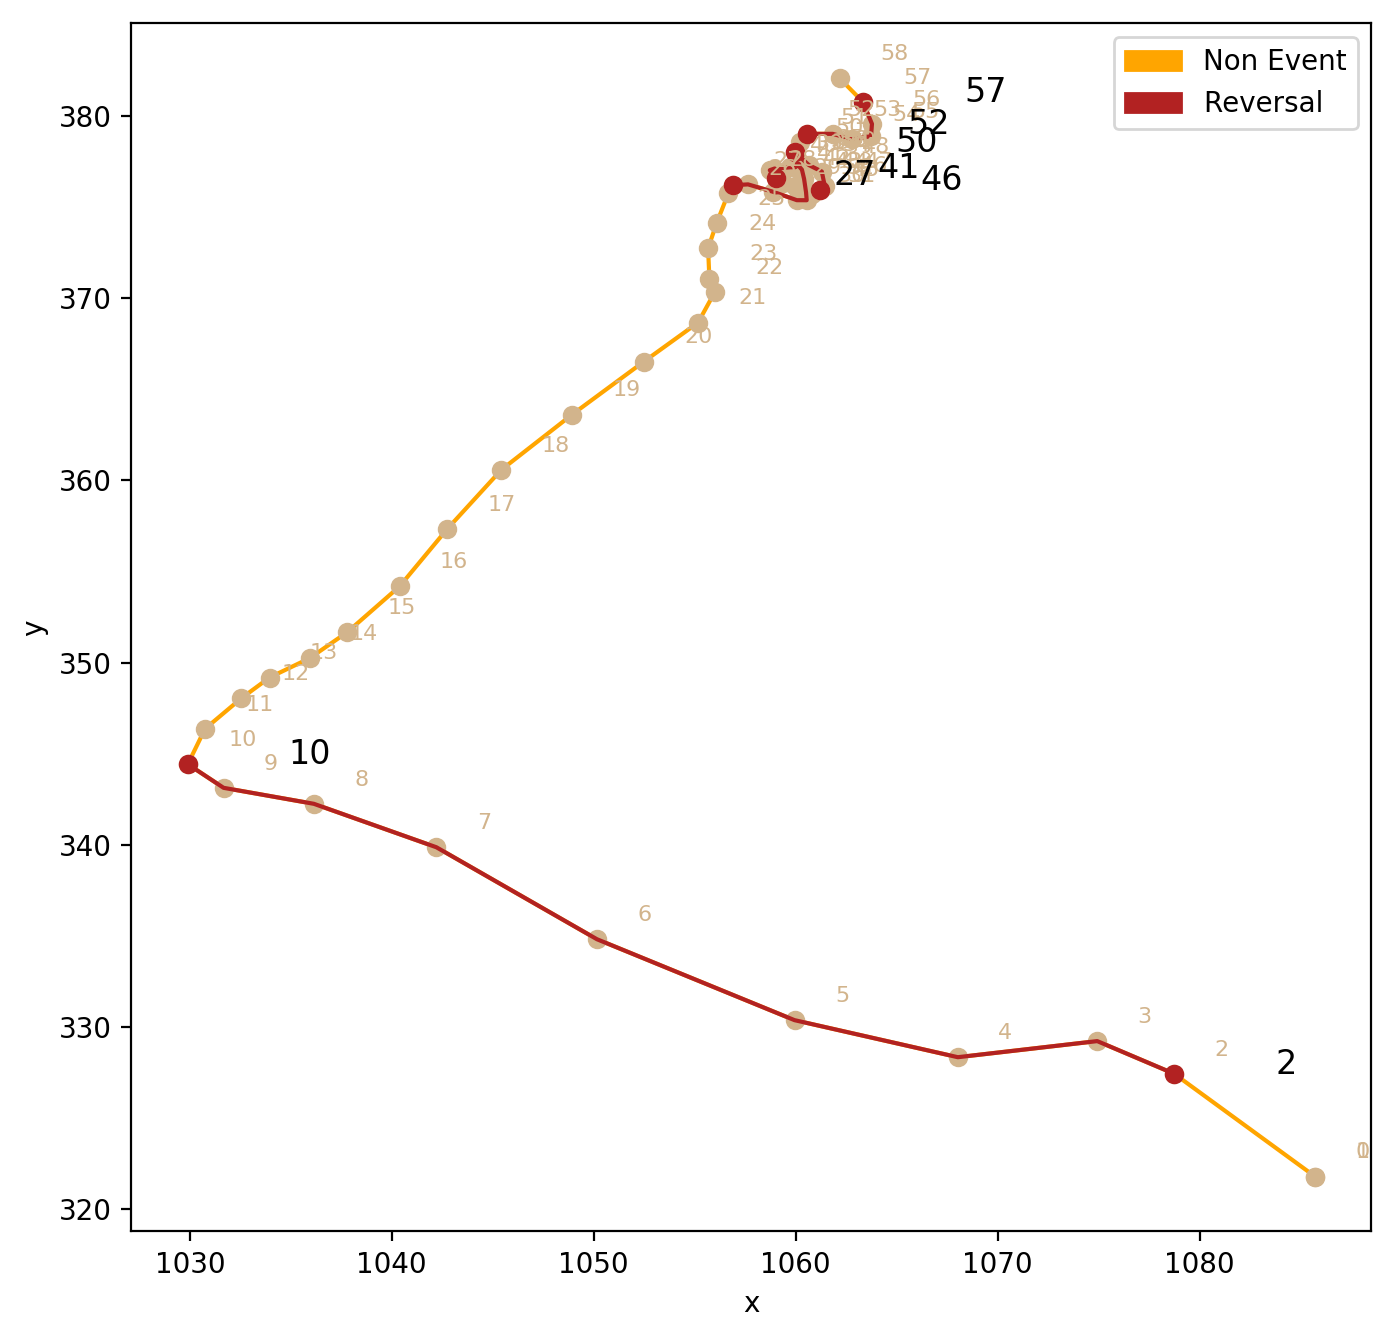

This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 22
local minimum value: 0.906495453155
value before min: 2.48358219828
value after min: 1.15201002787
deltav/2: 2.52494725644
v_upper: 1.91647435573
Index_endleft 22
Index_endright 23


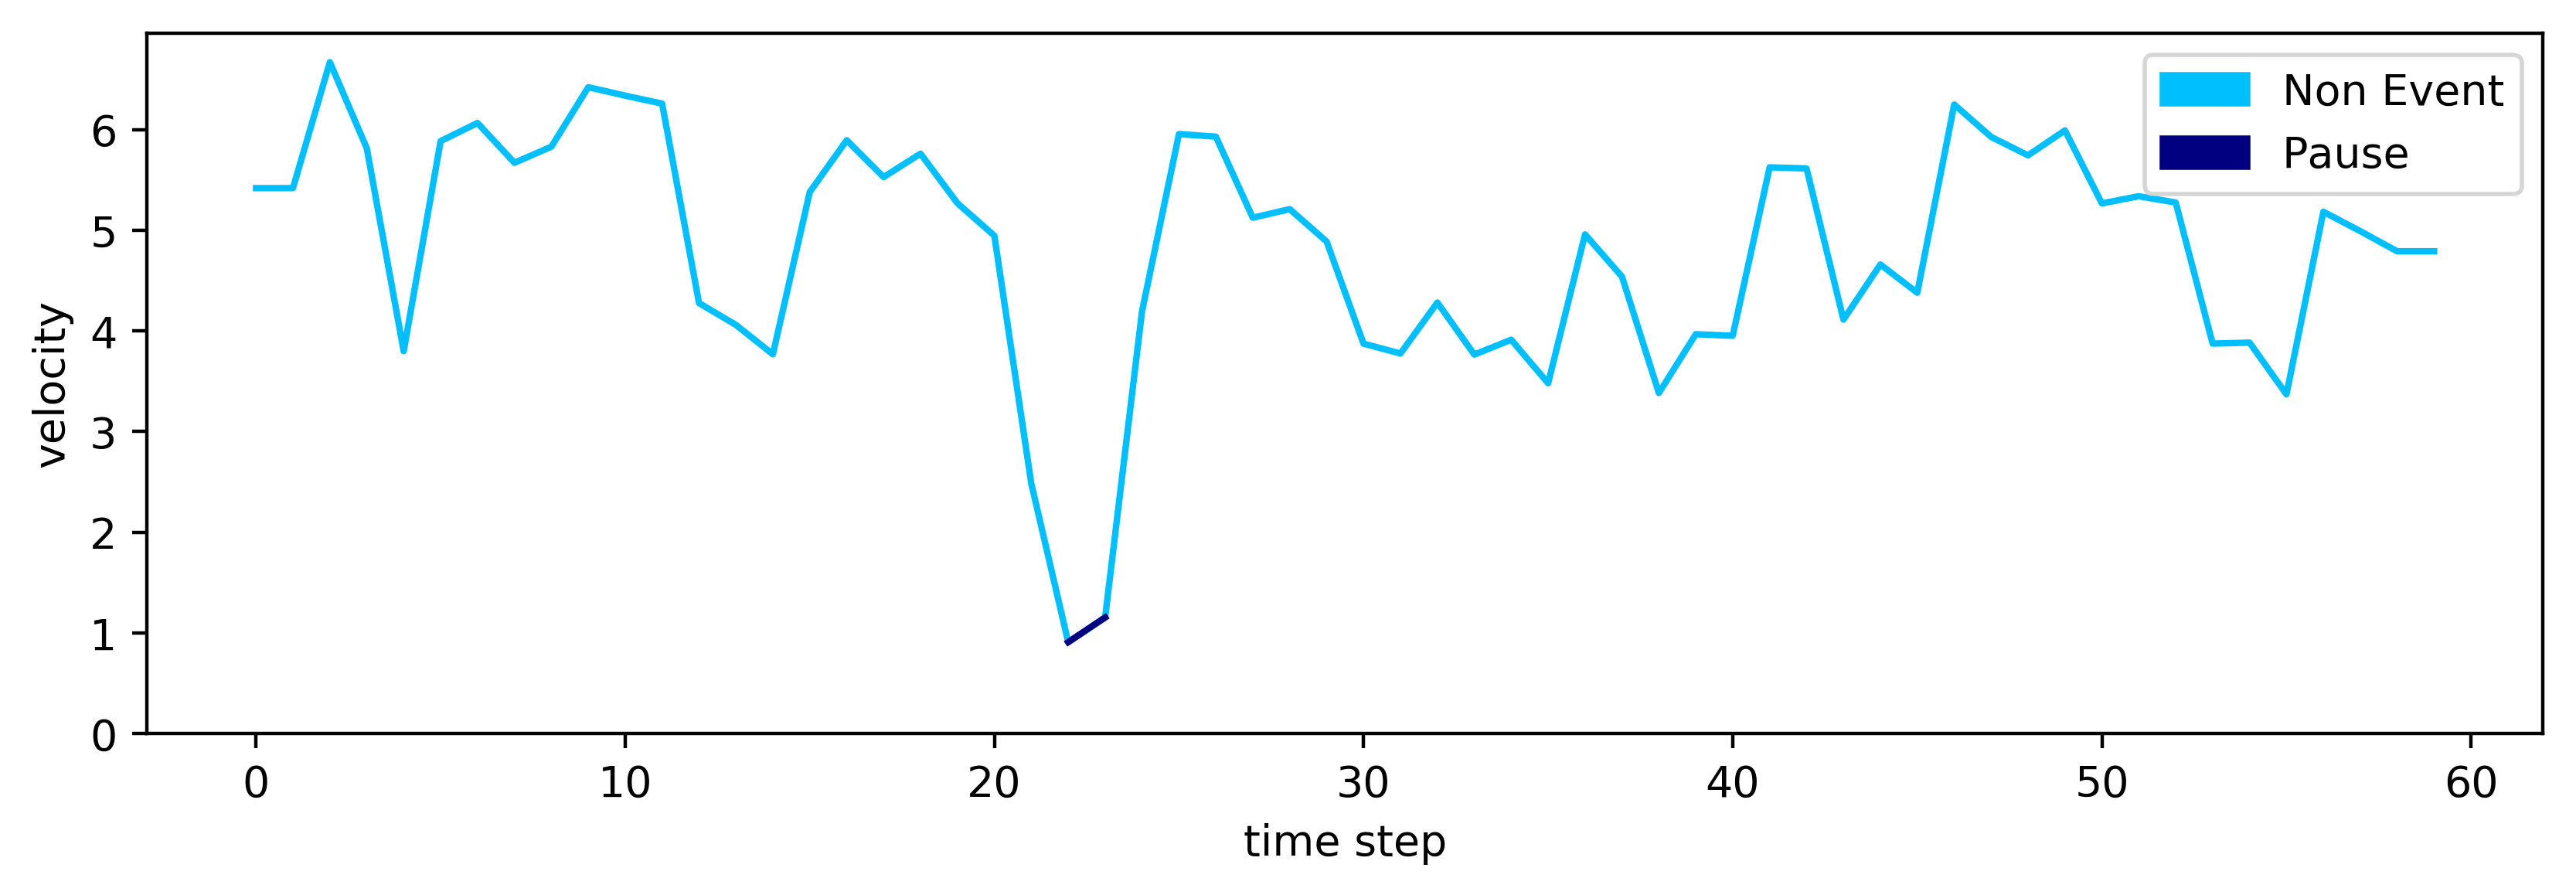

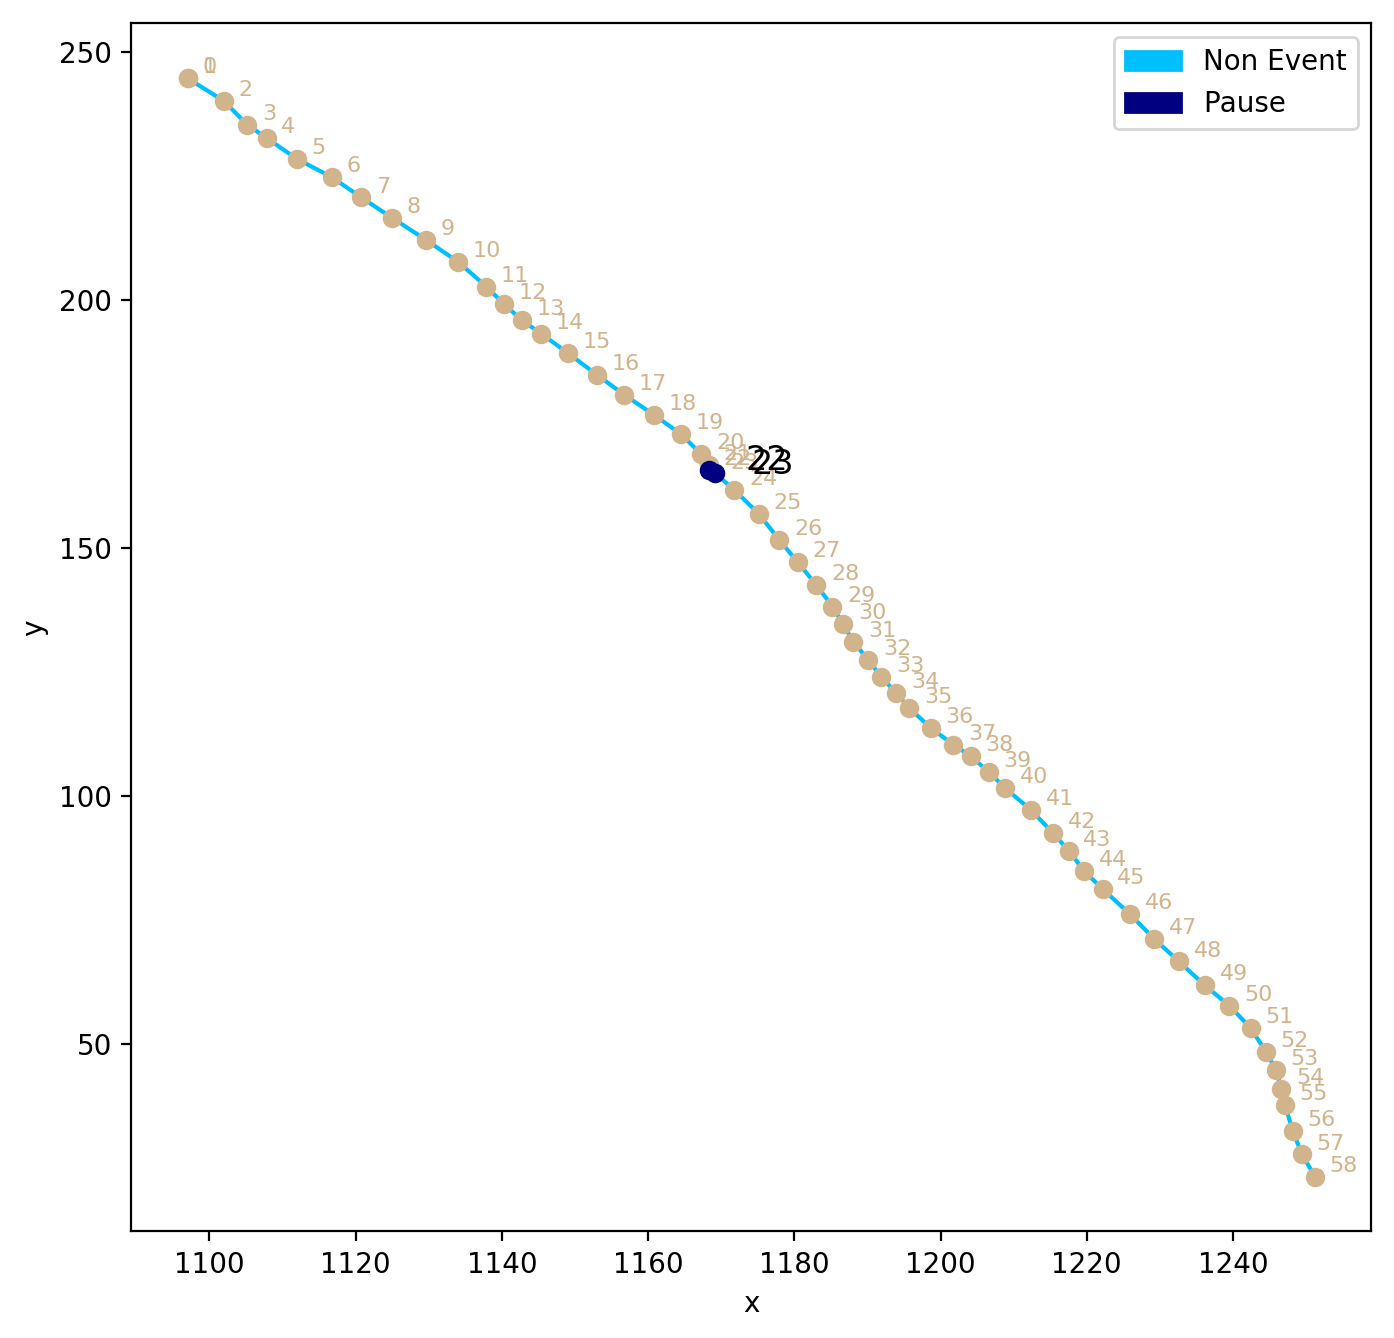

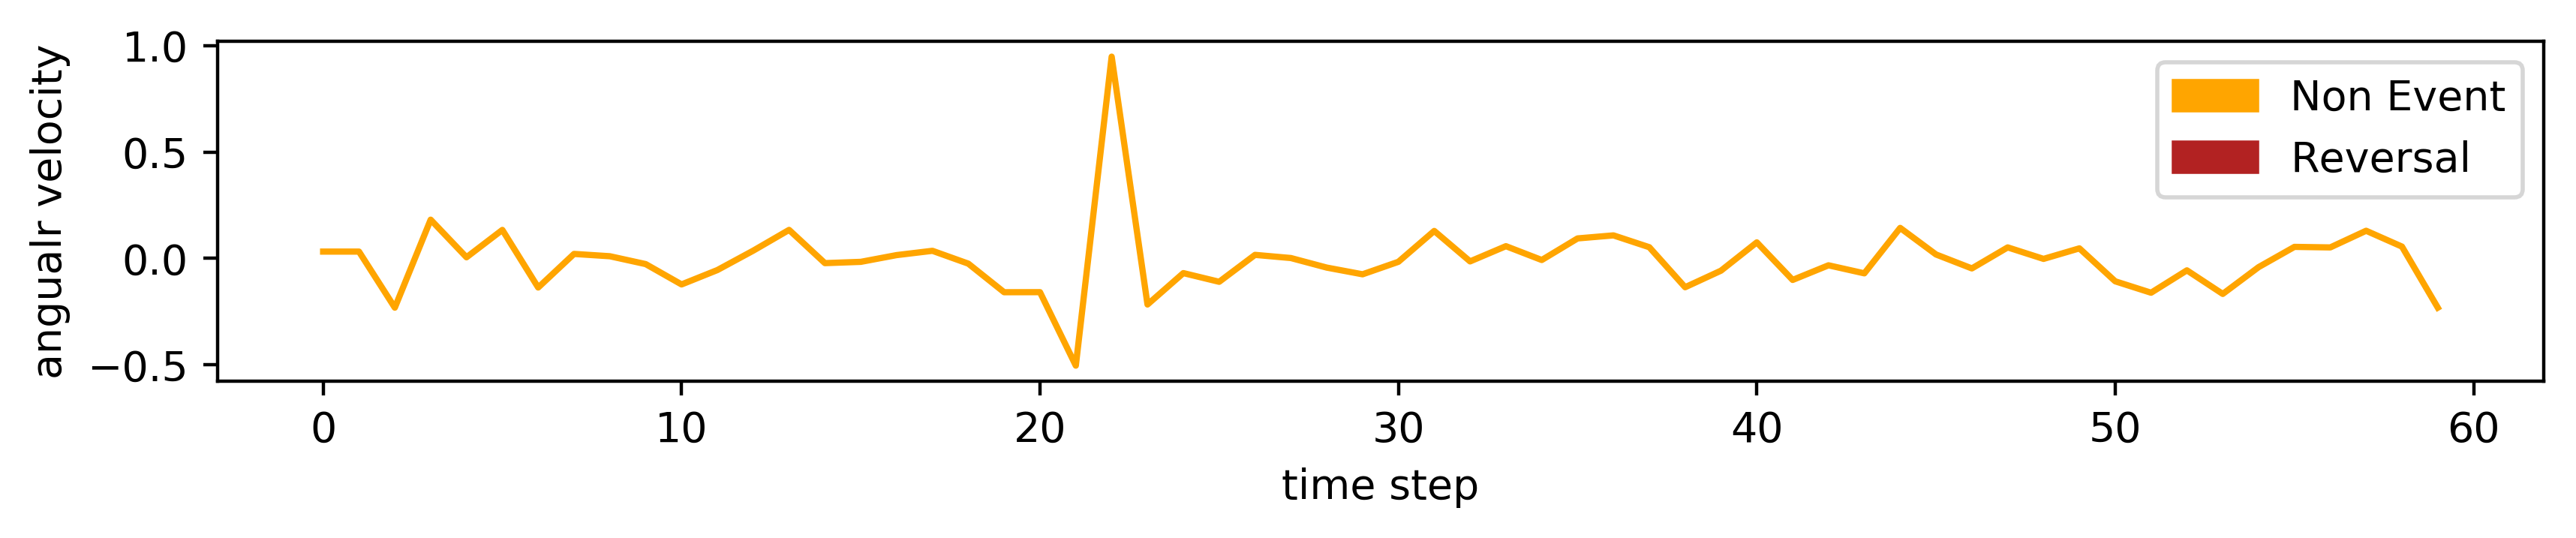

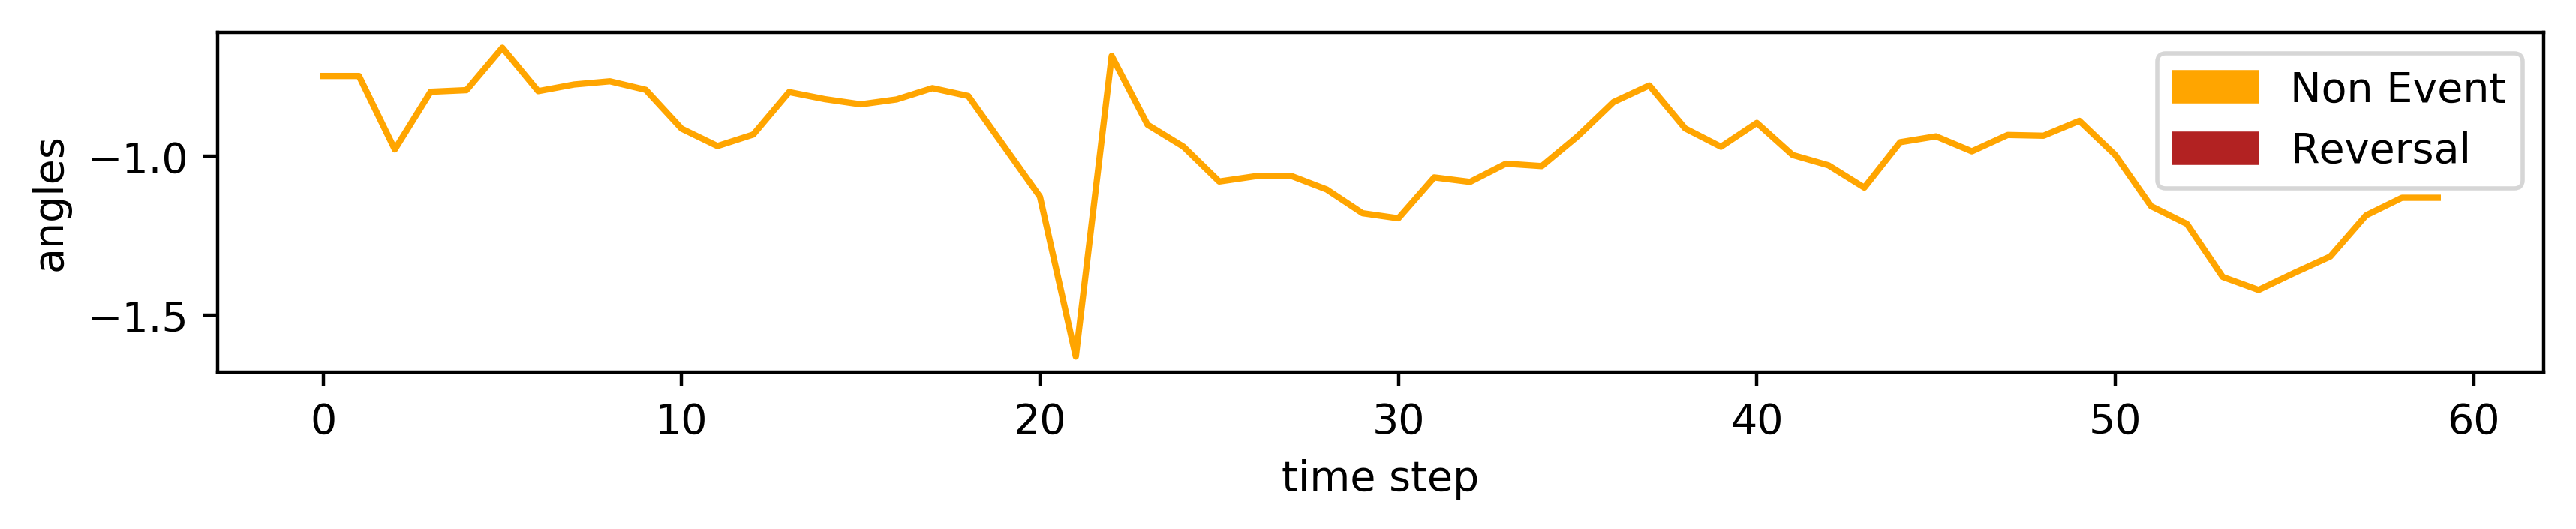

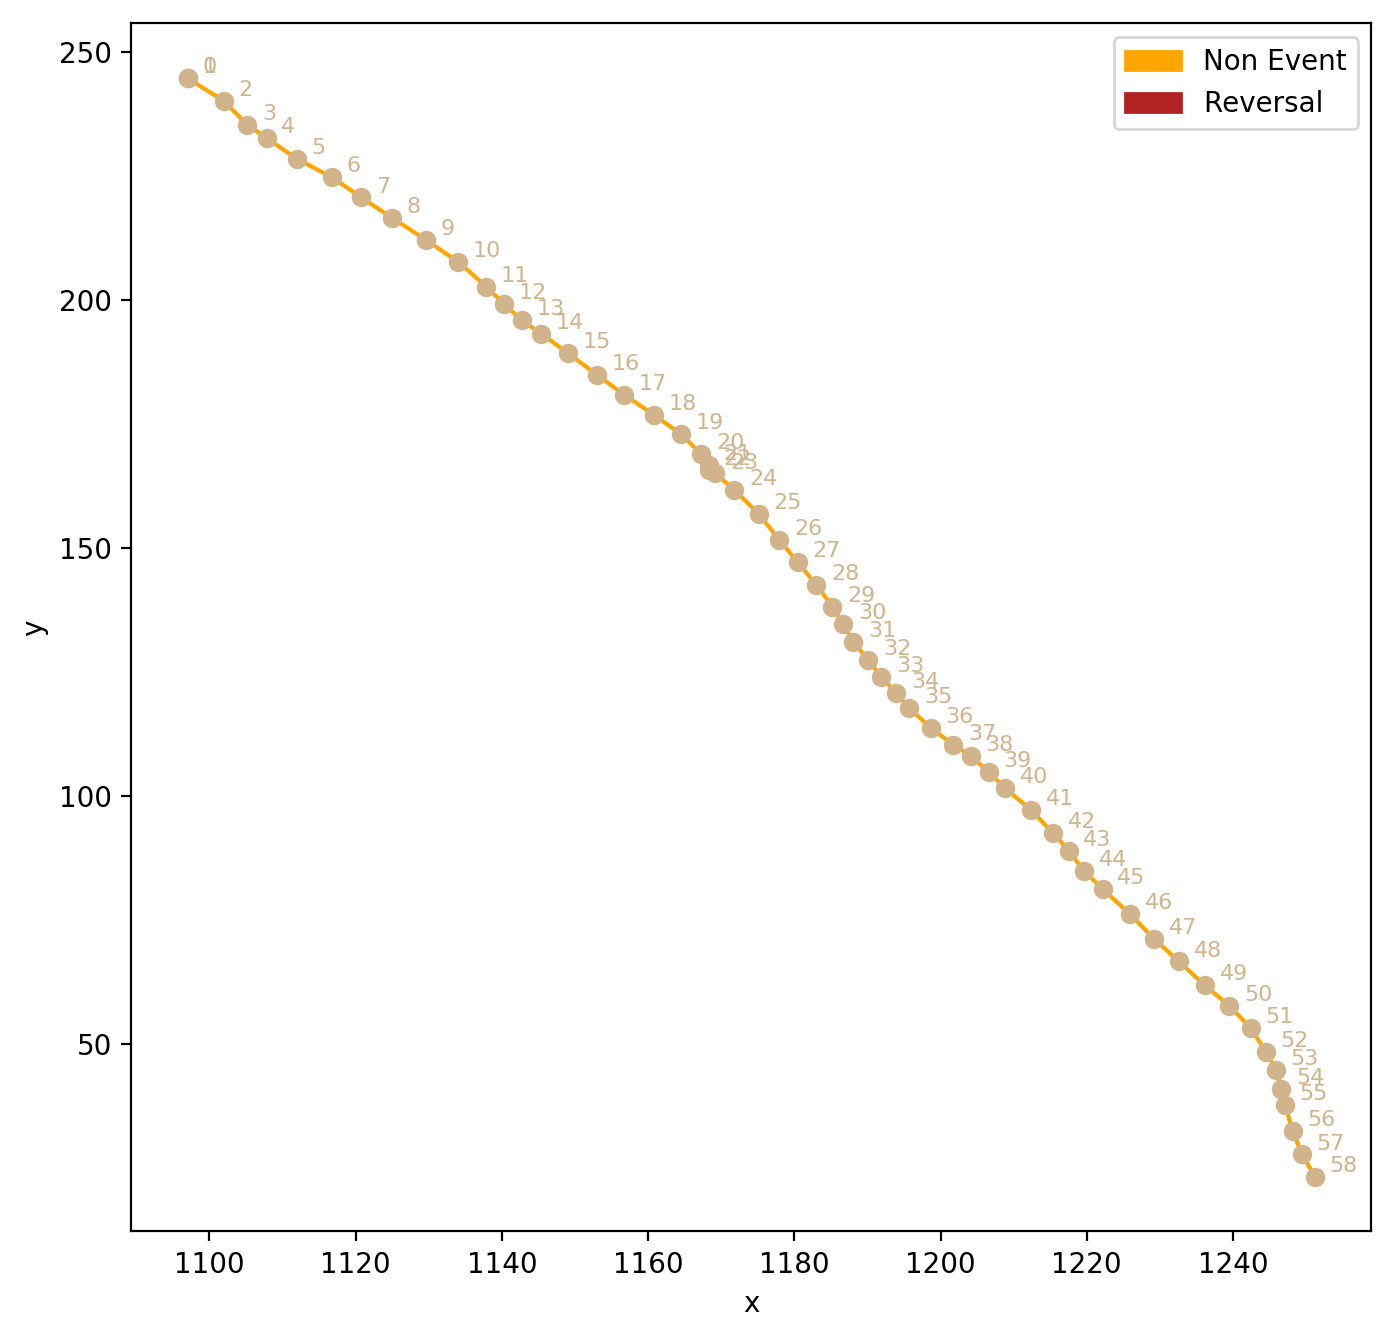

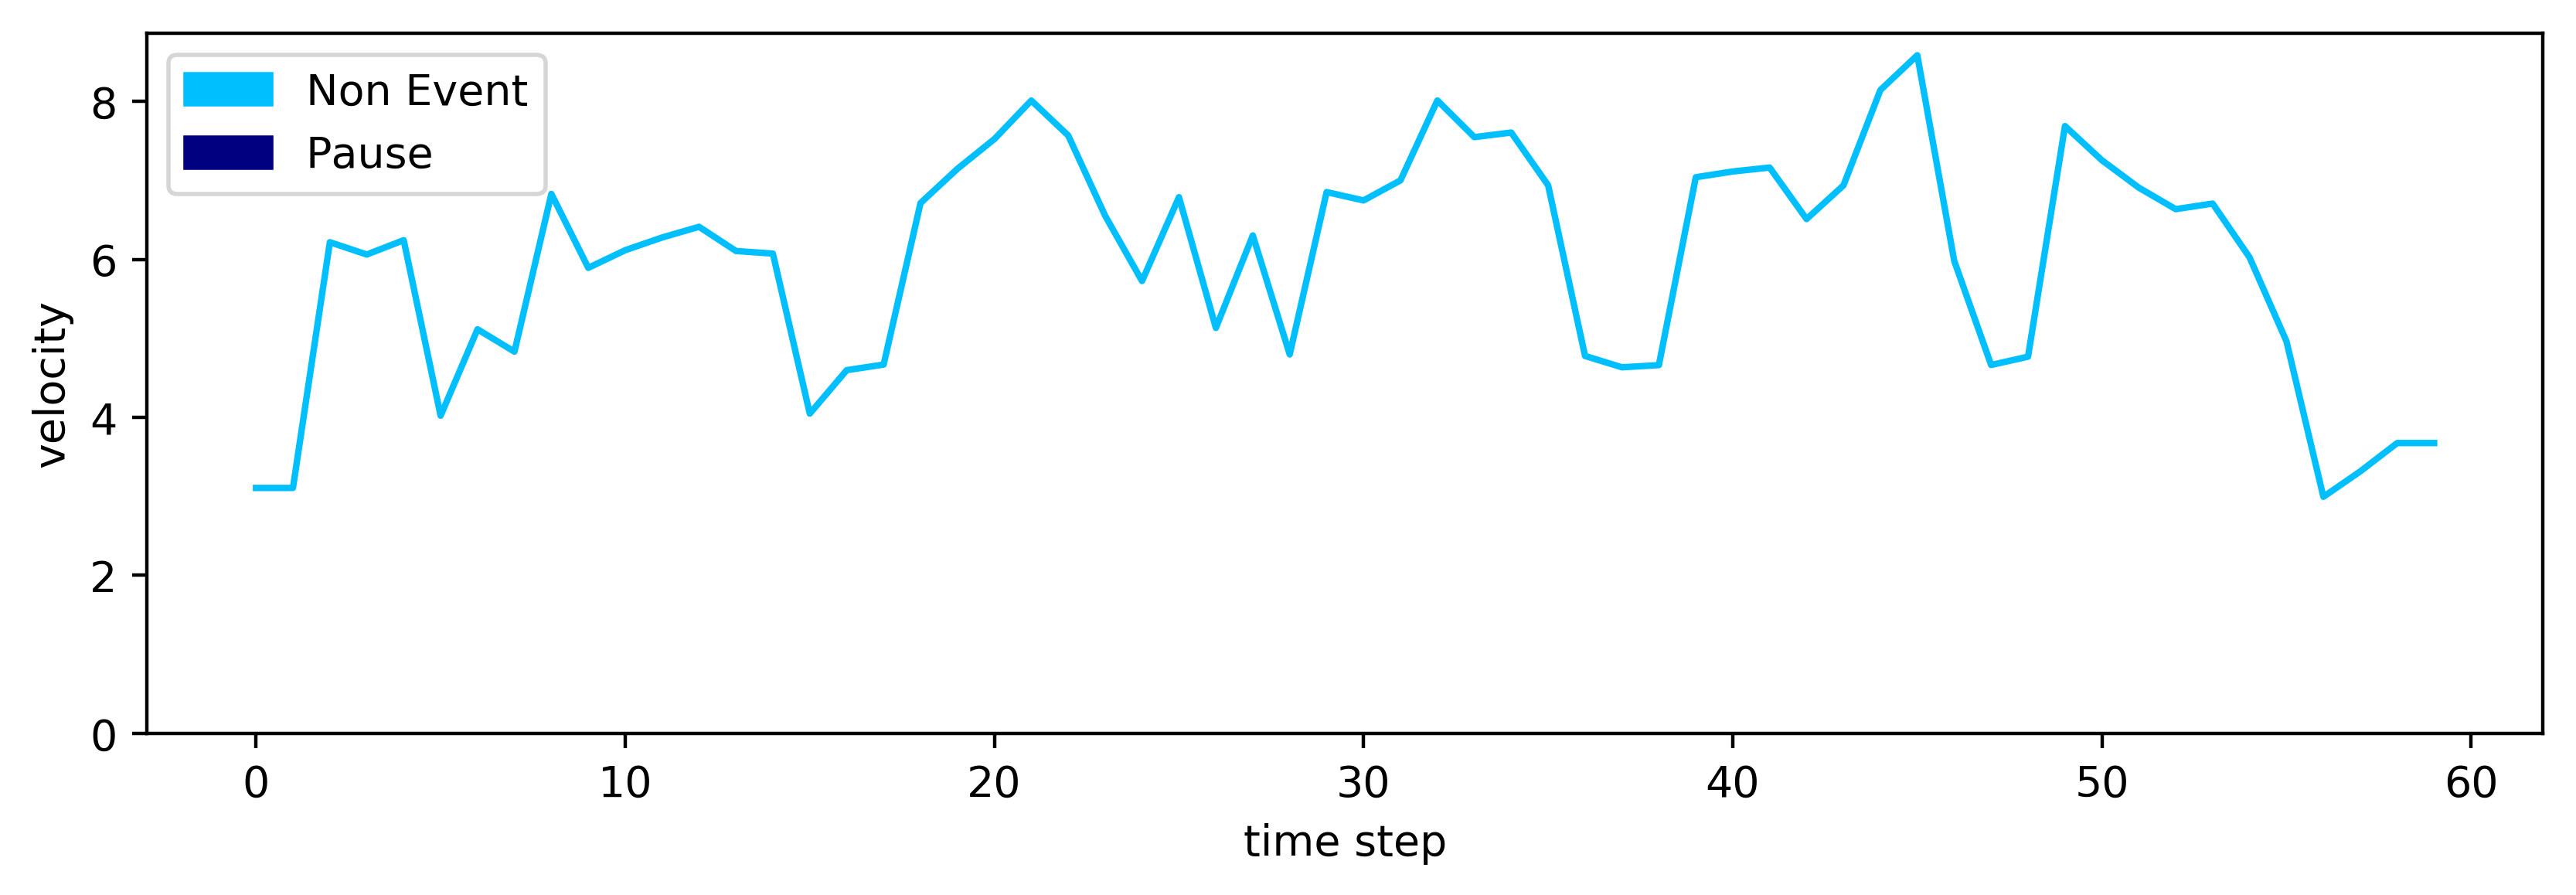

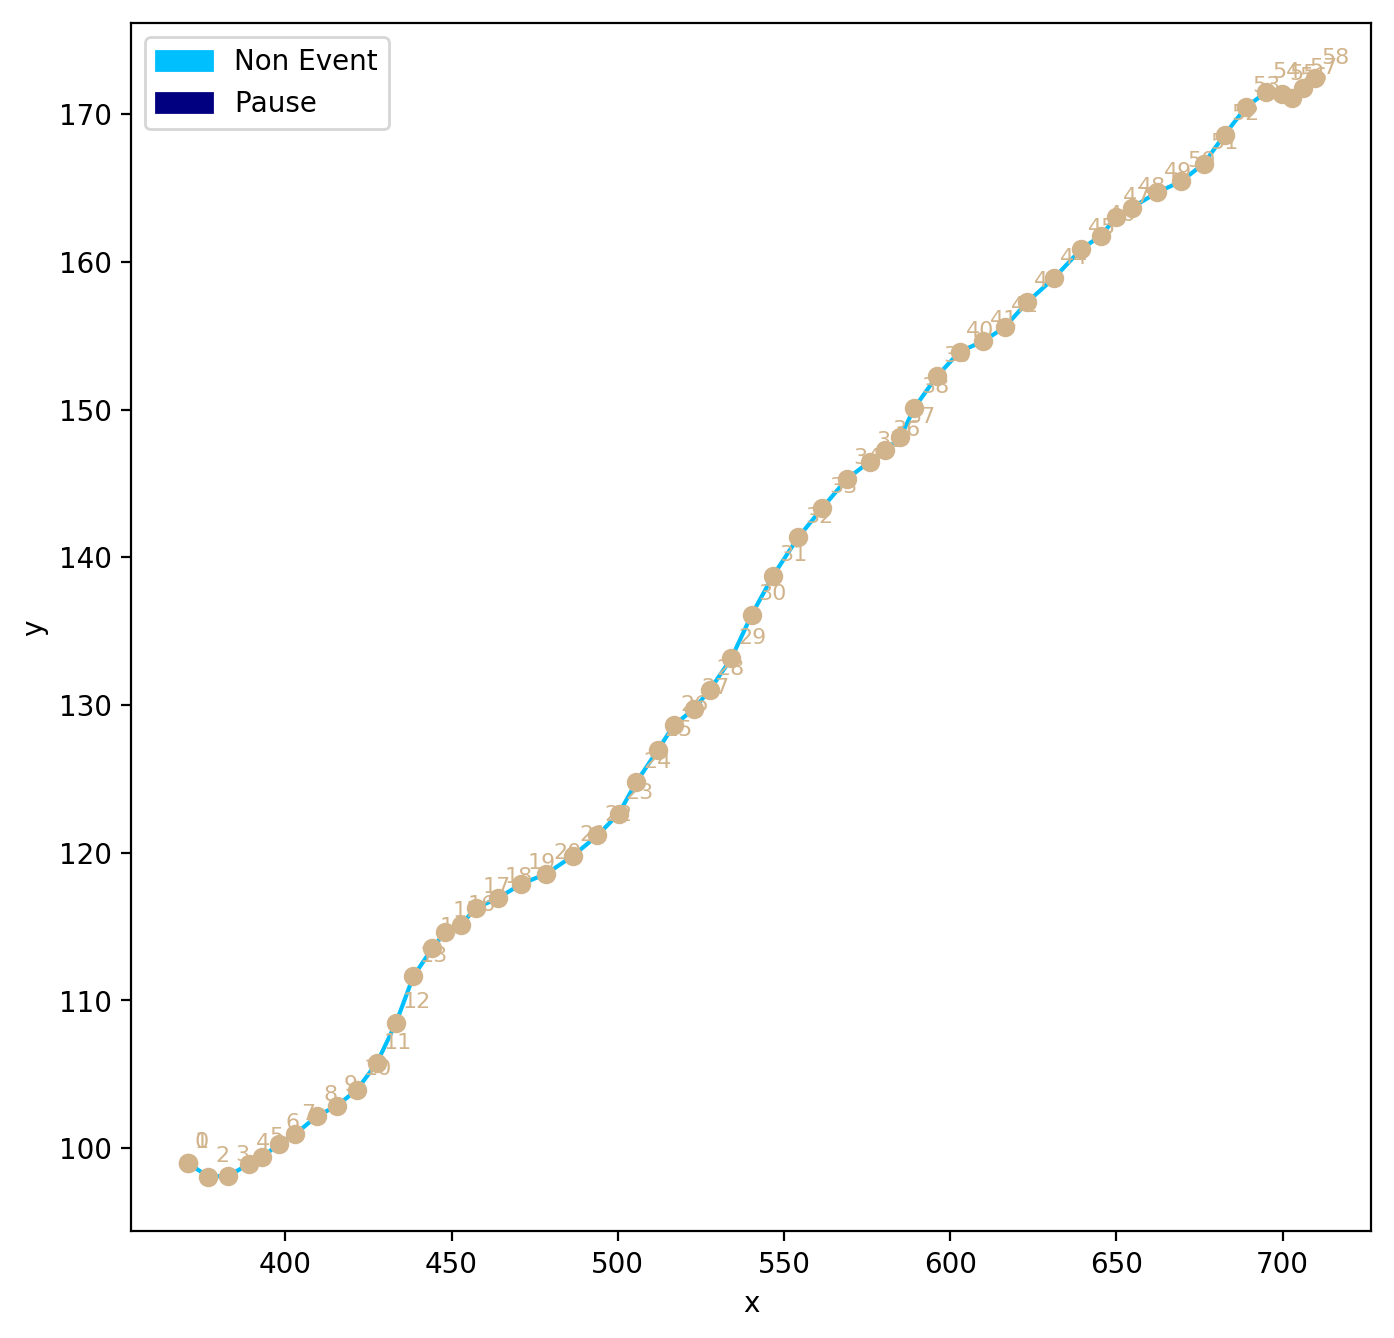

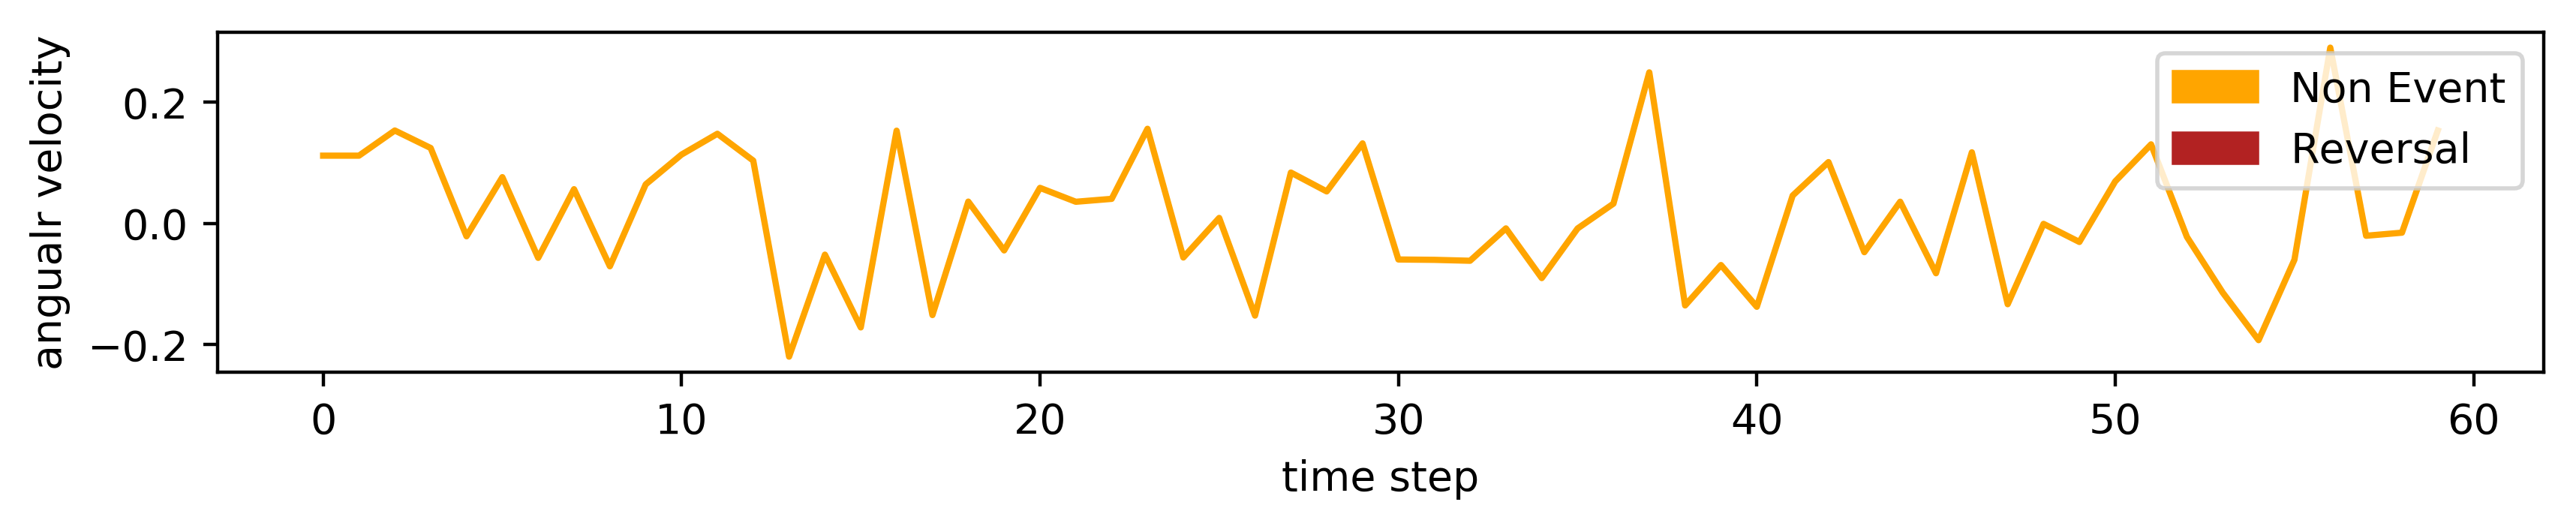

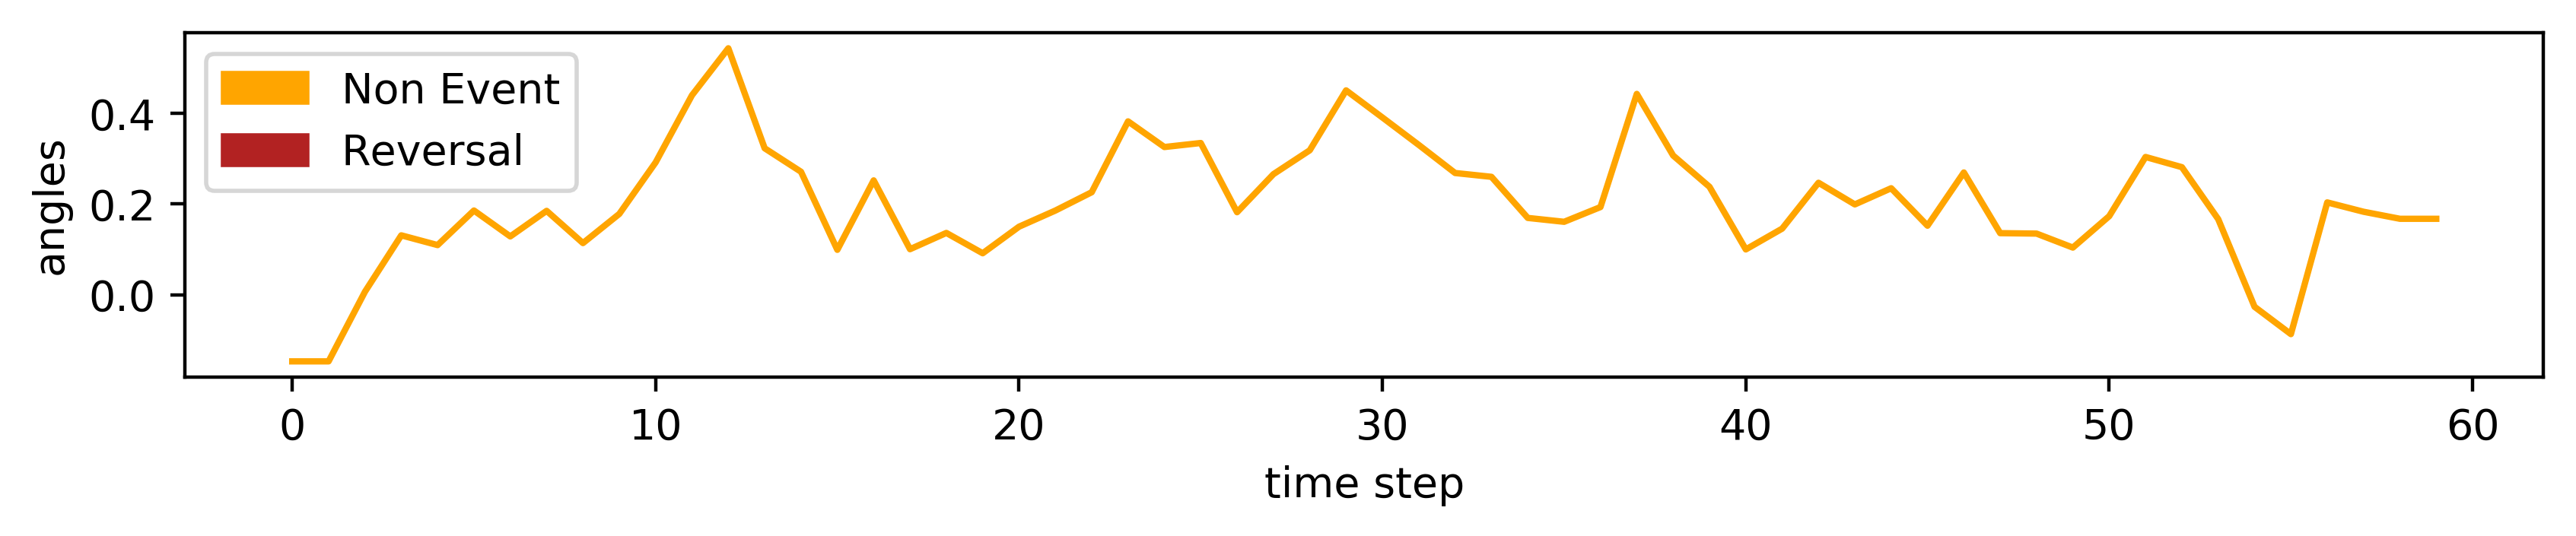

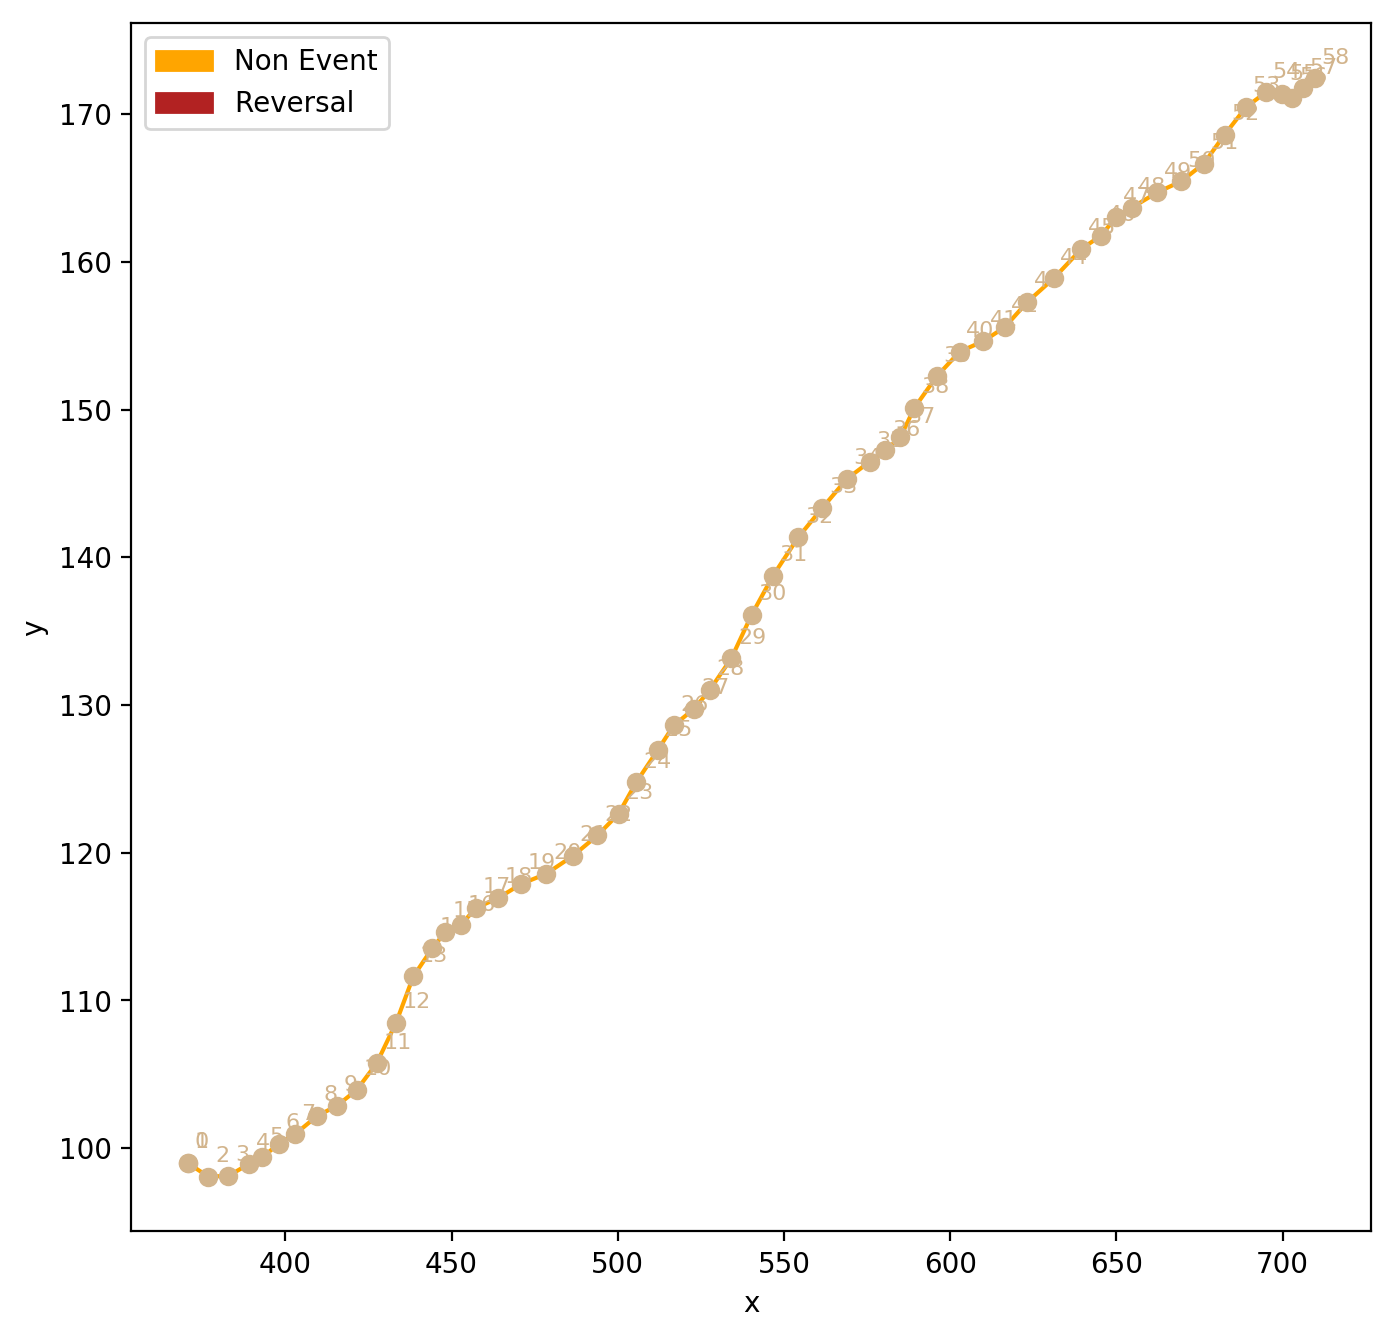

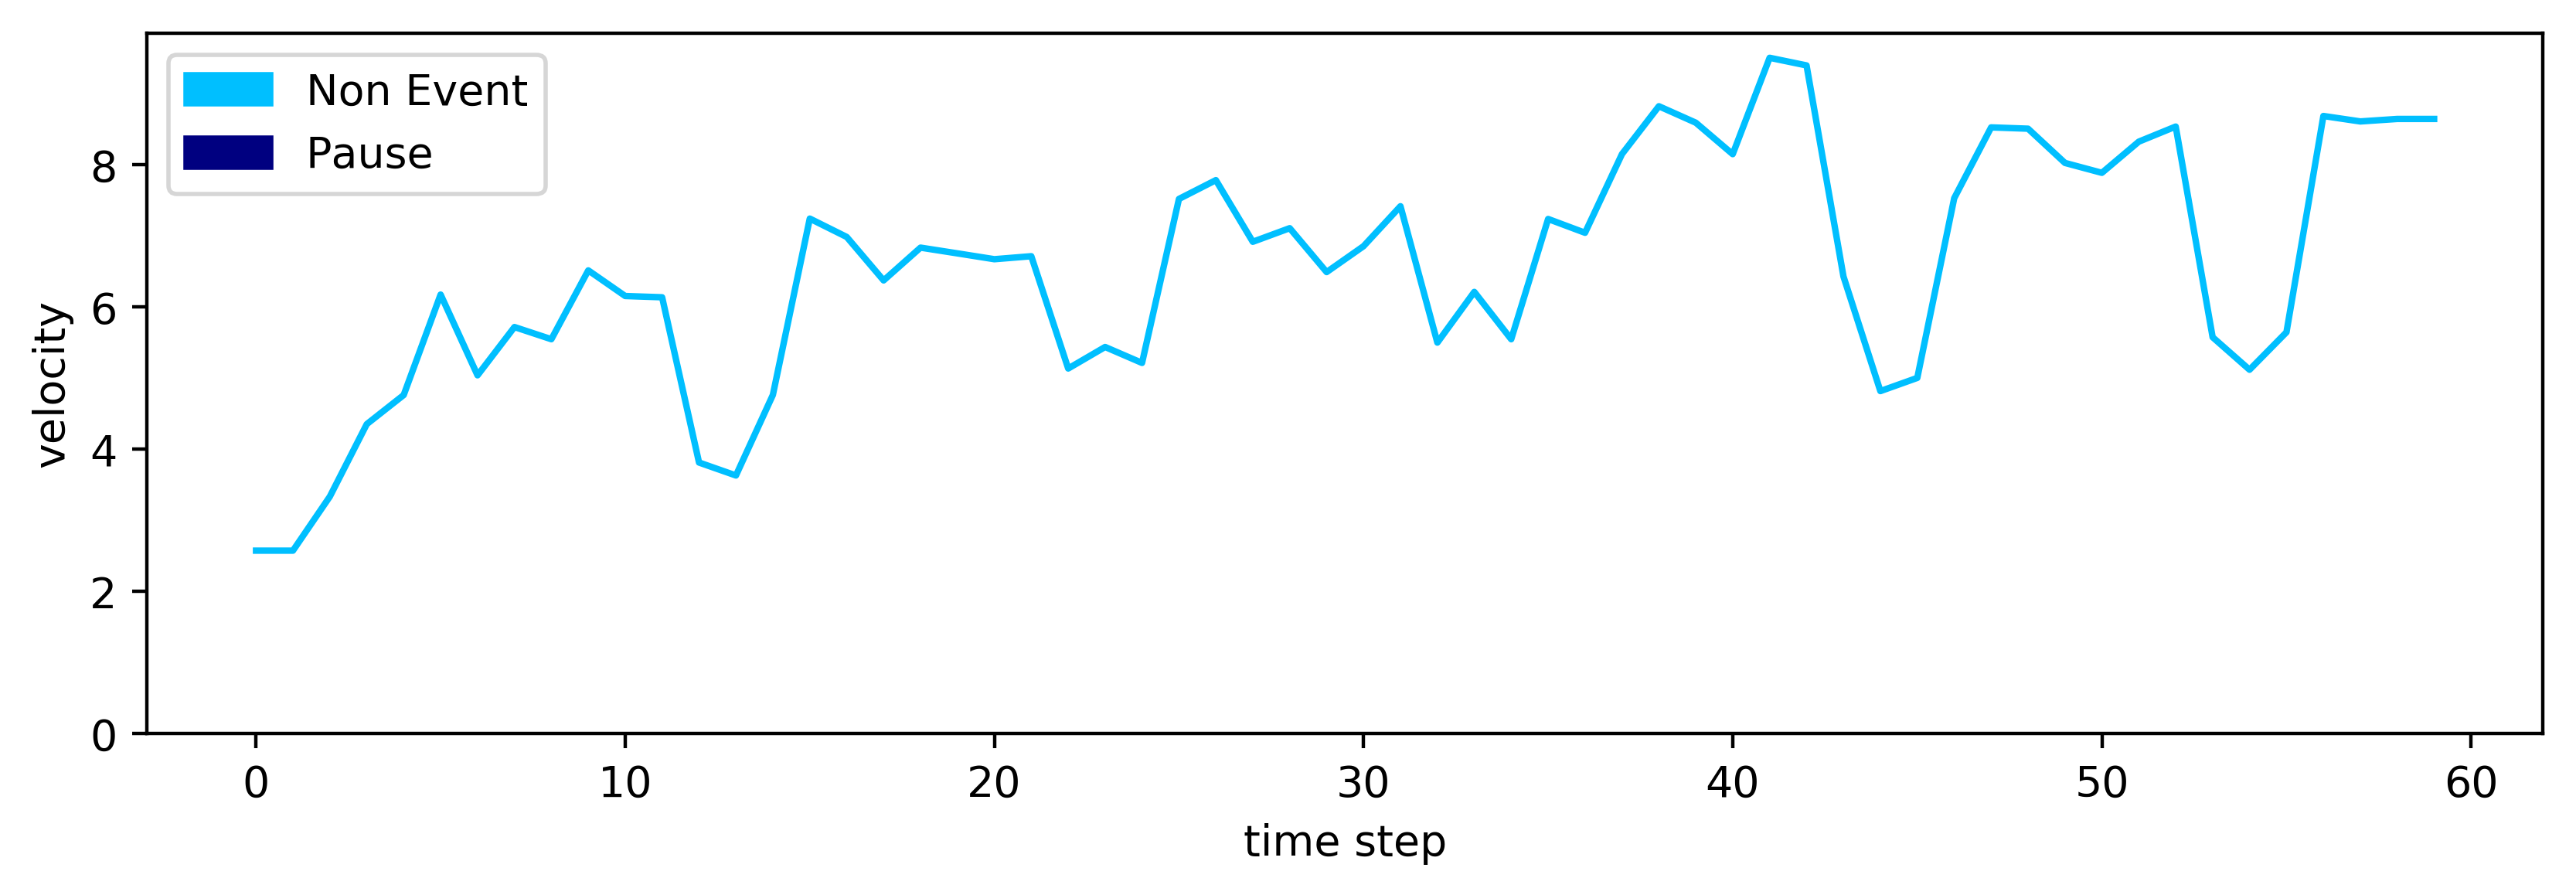

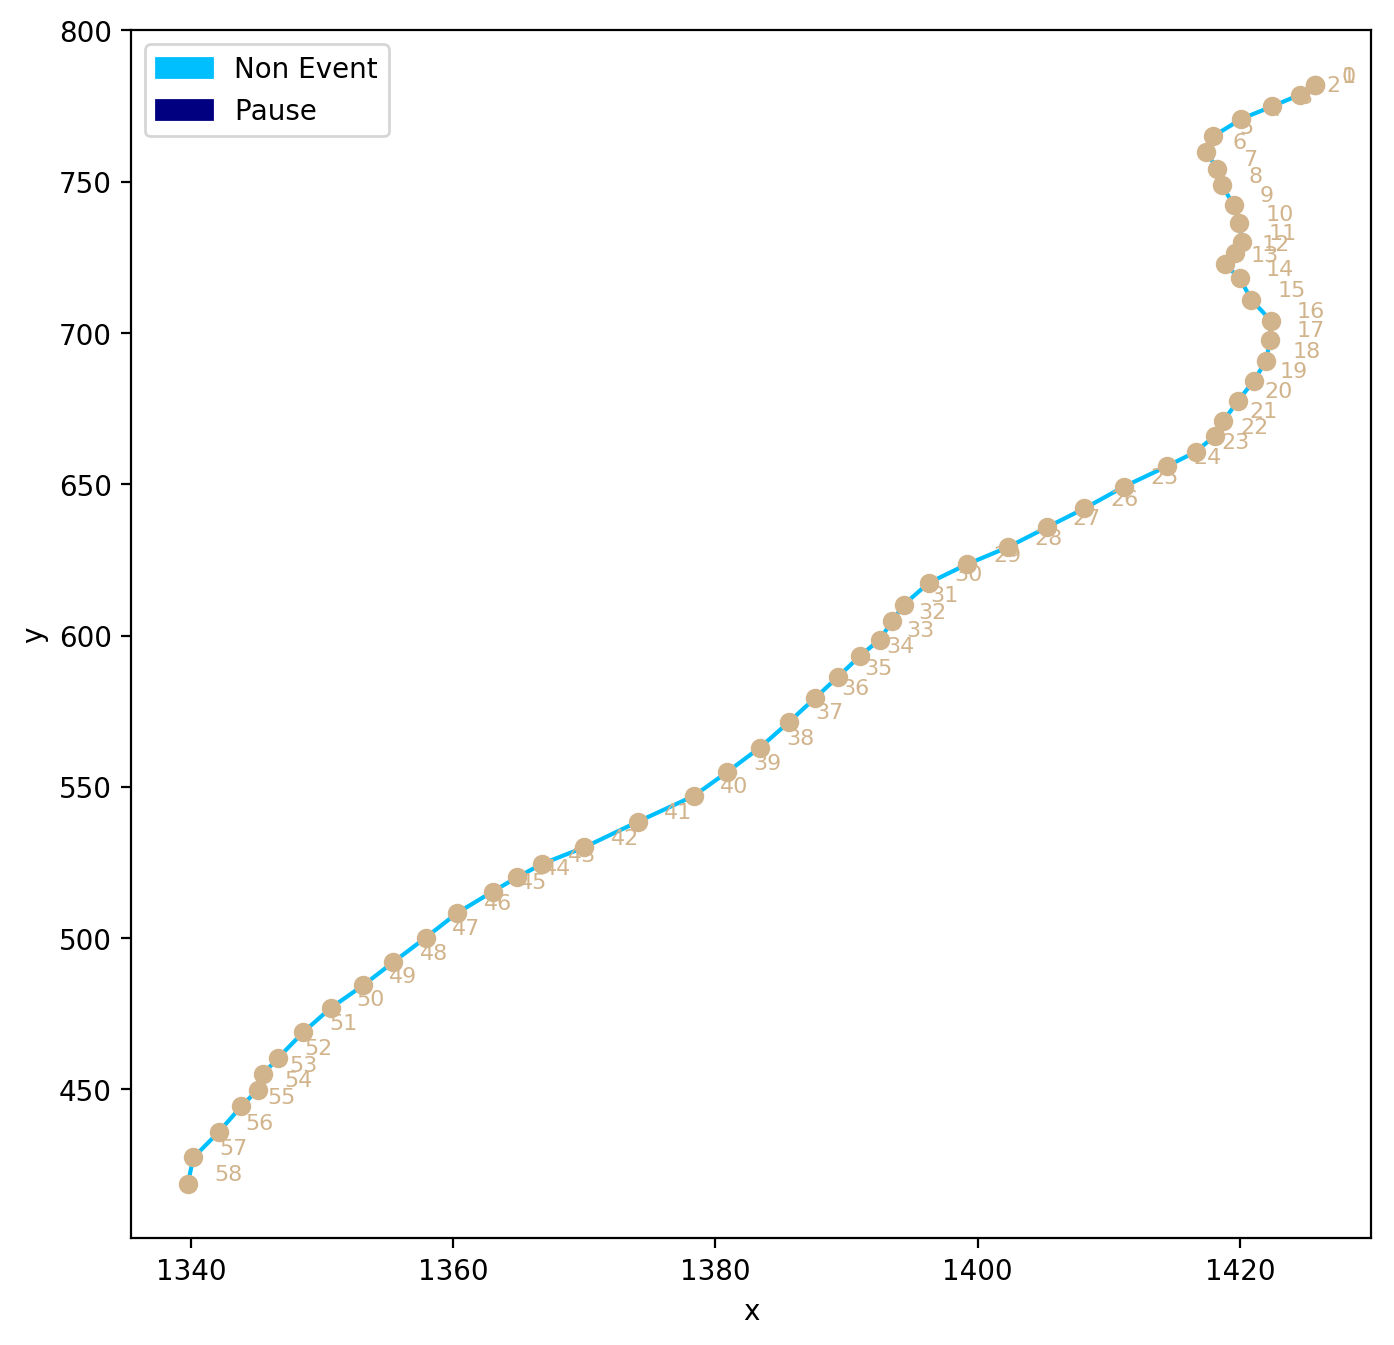

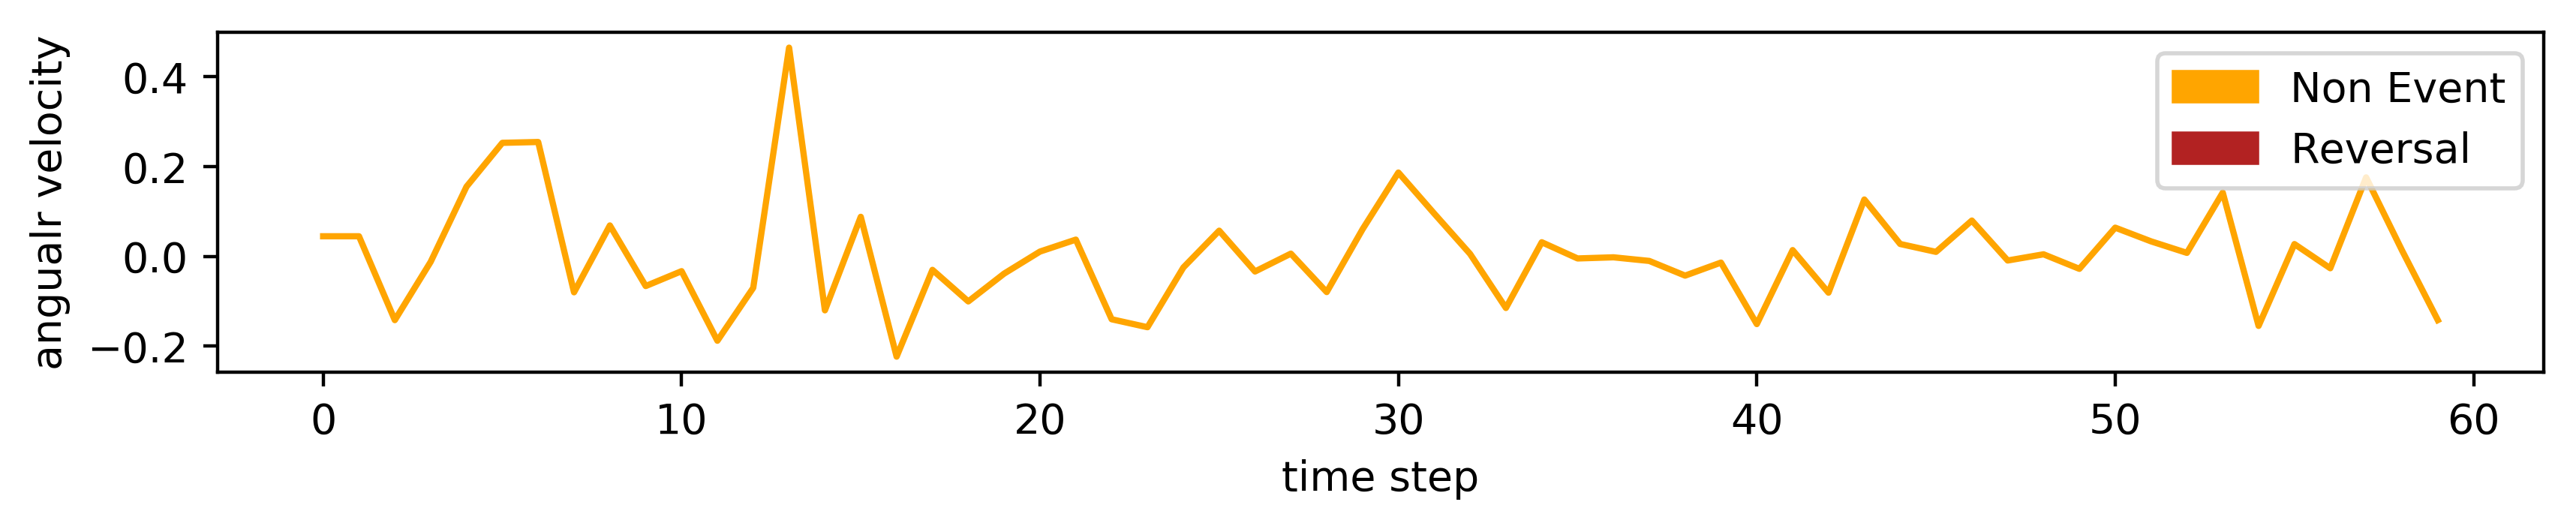

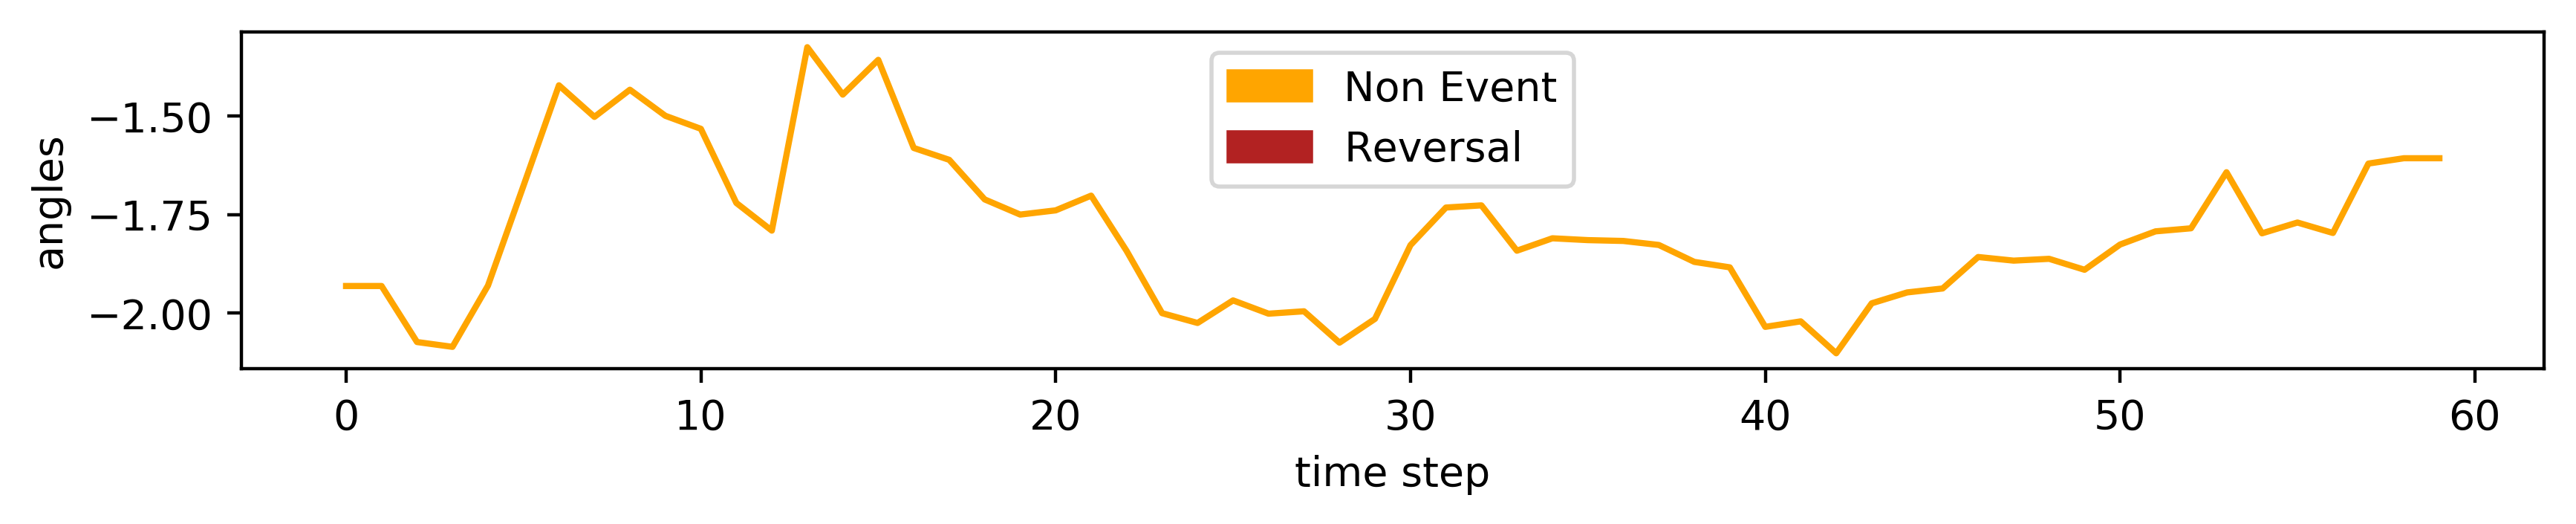

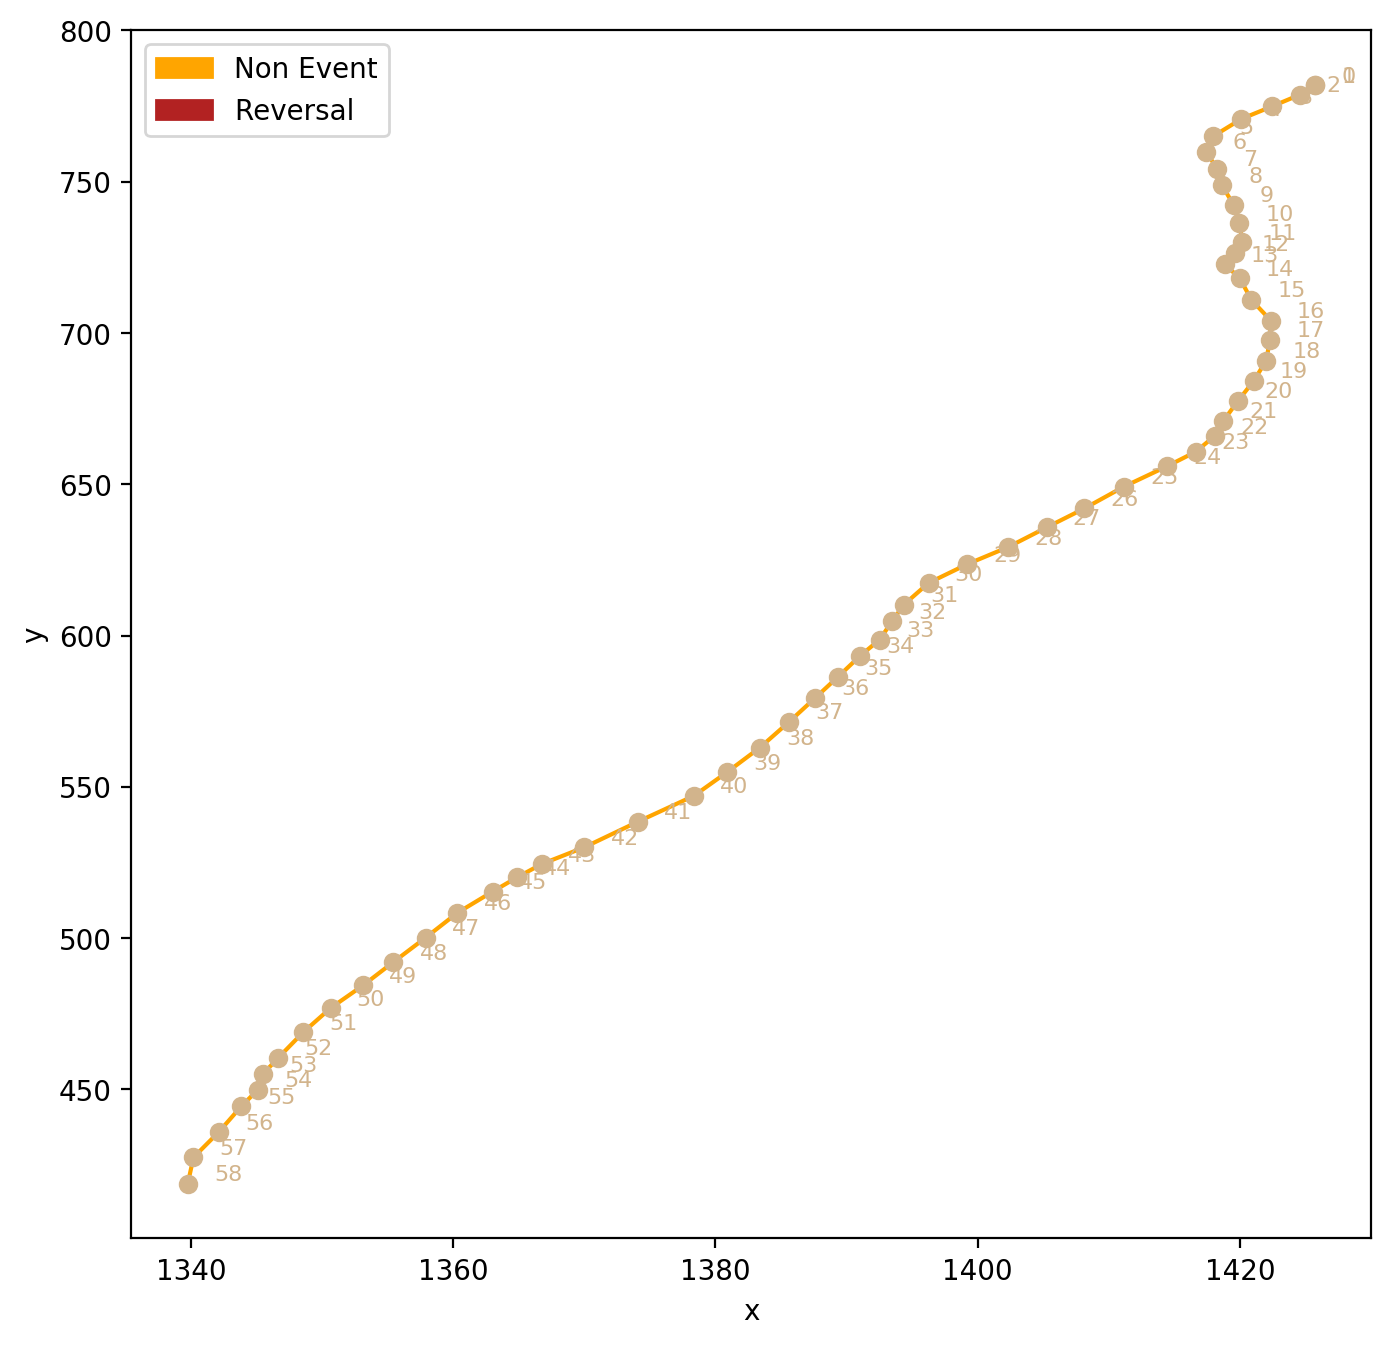

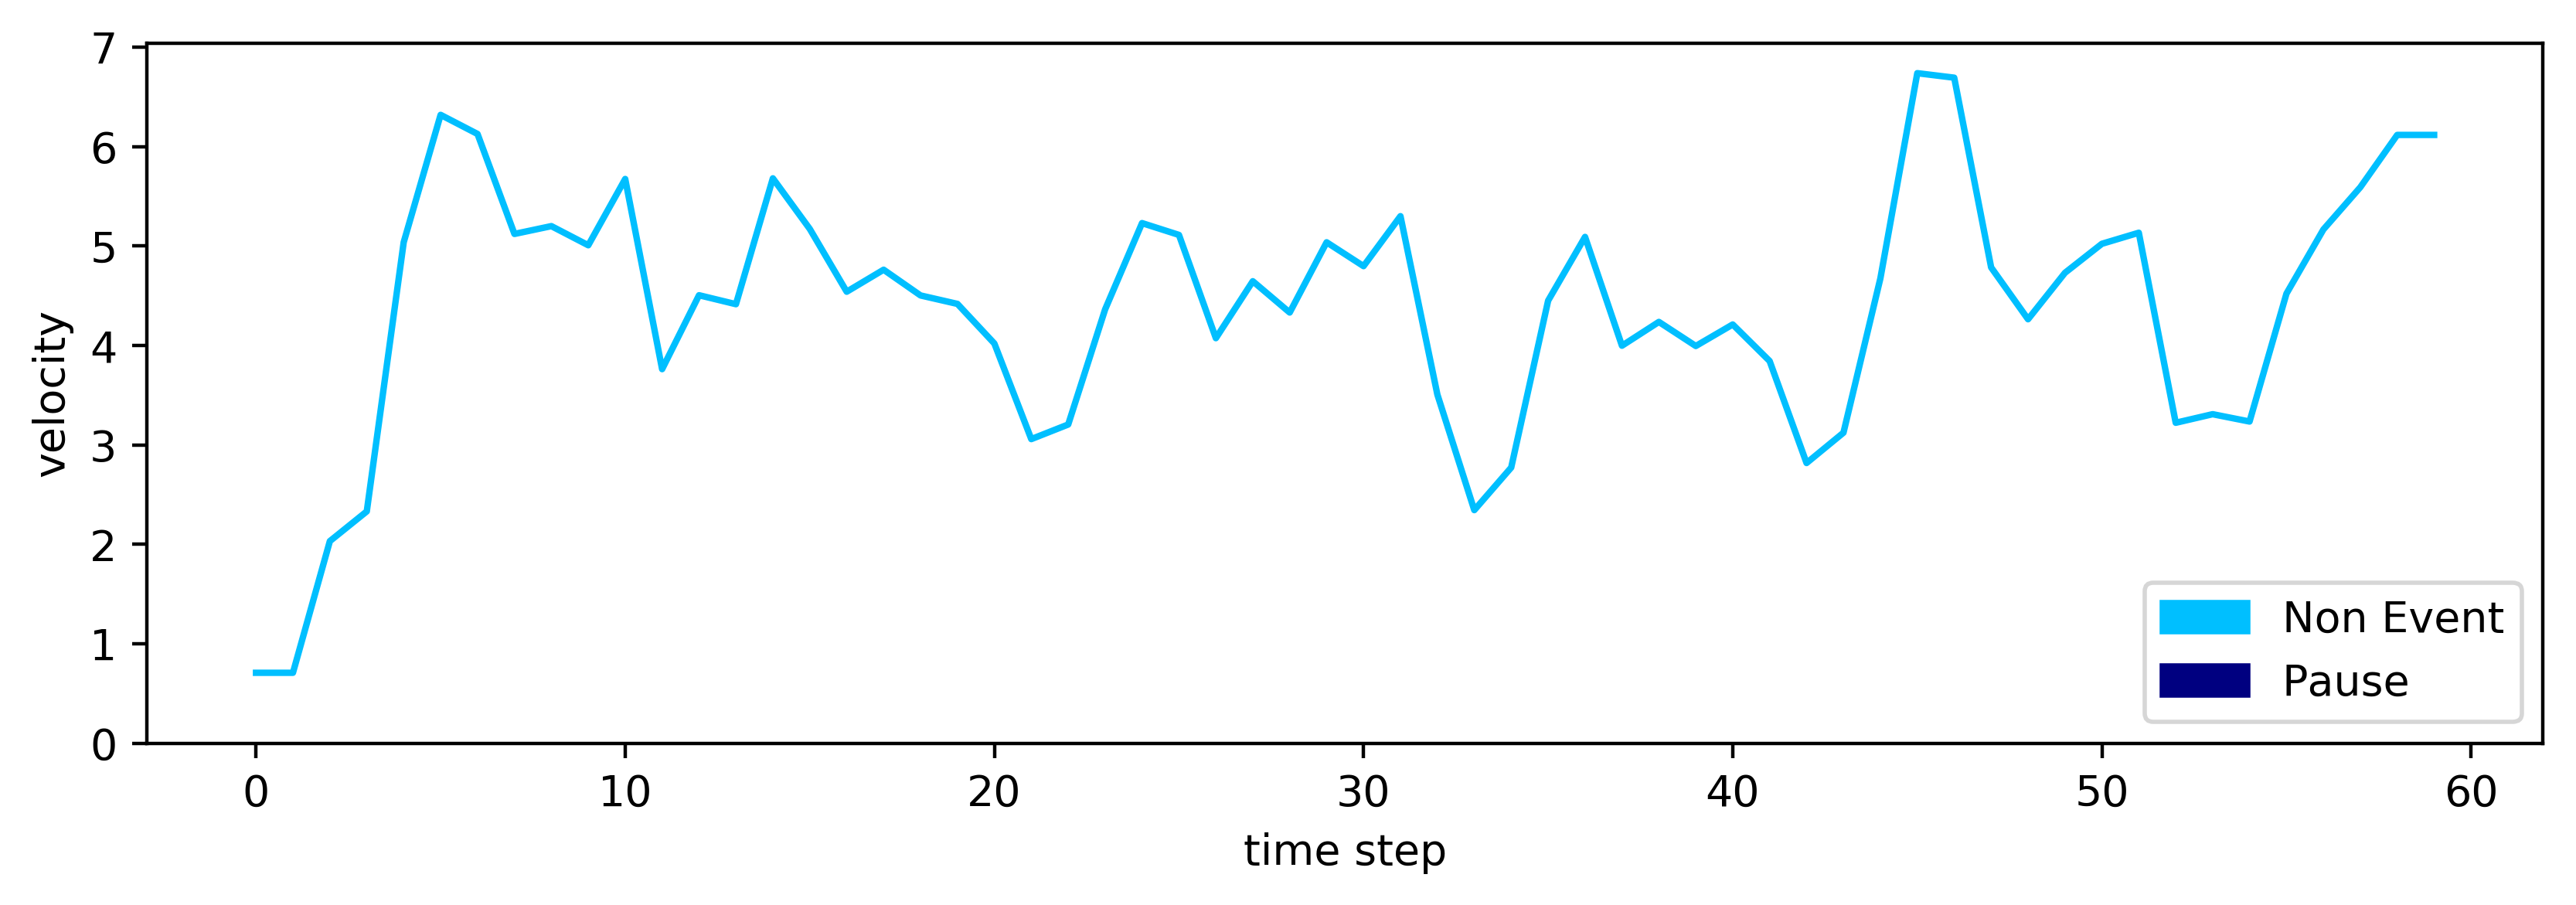

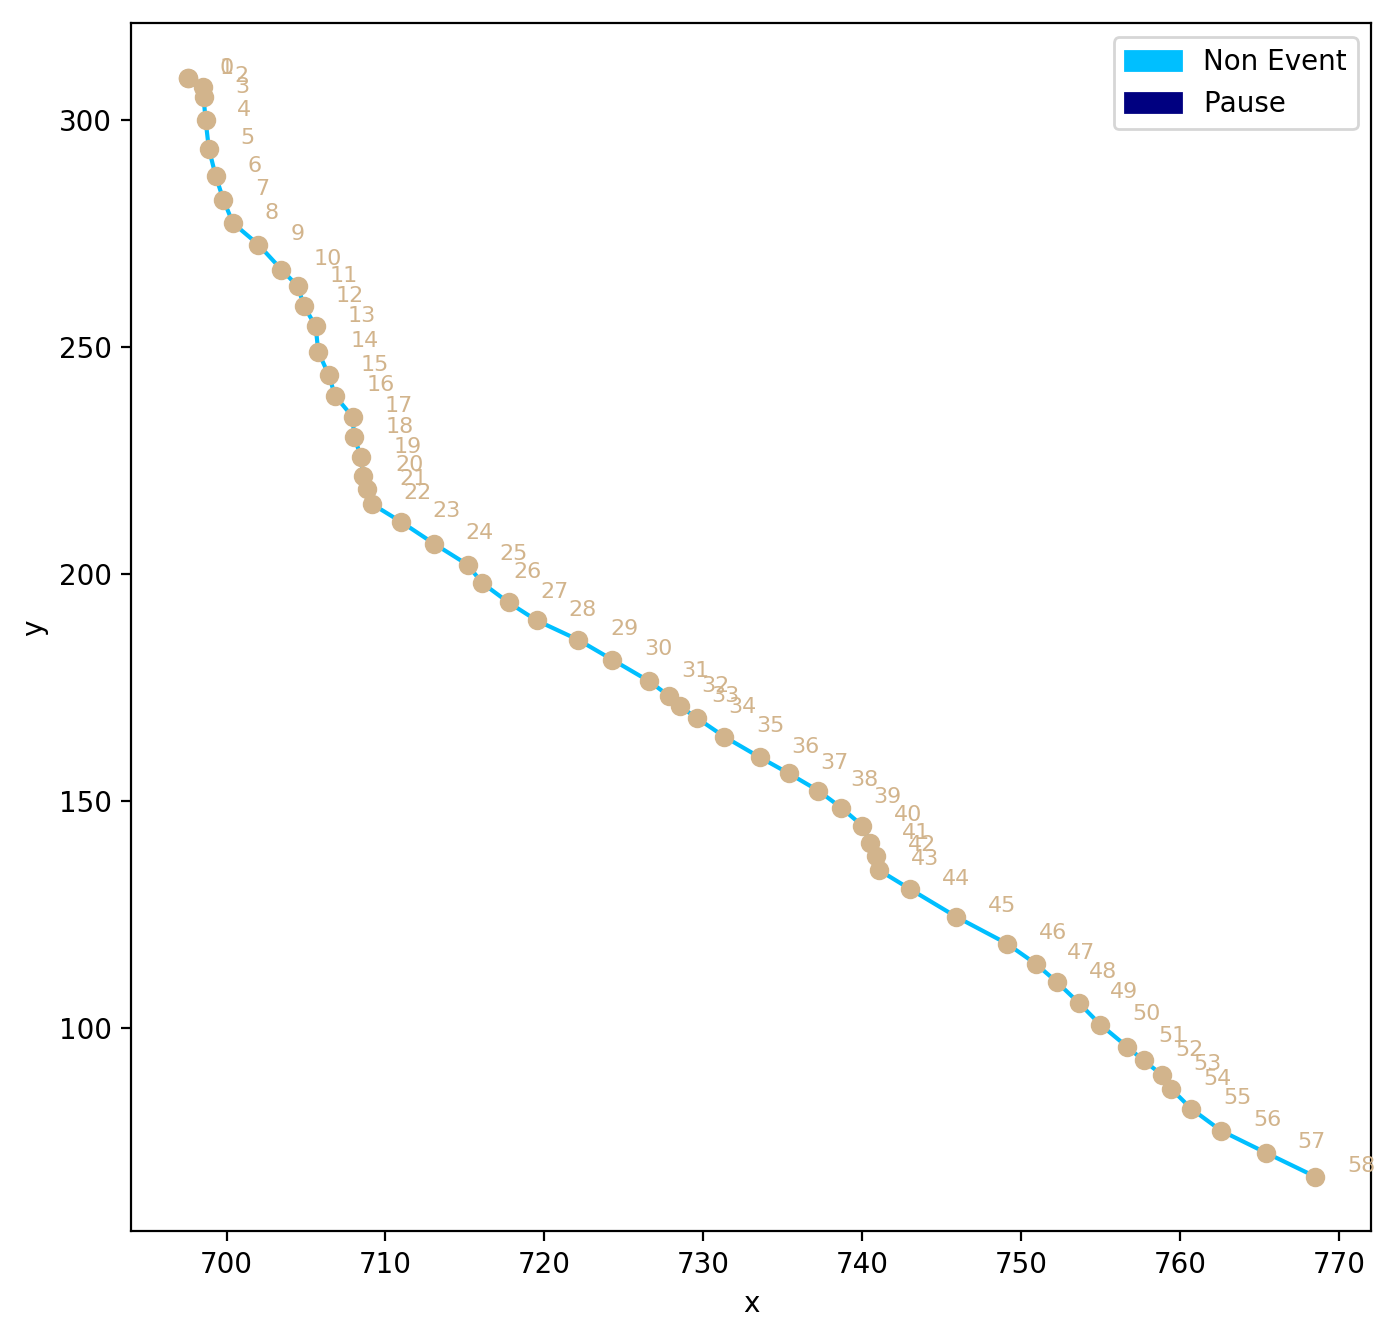

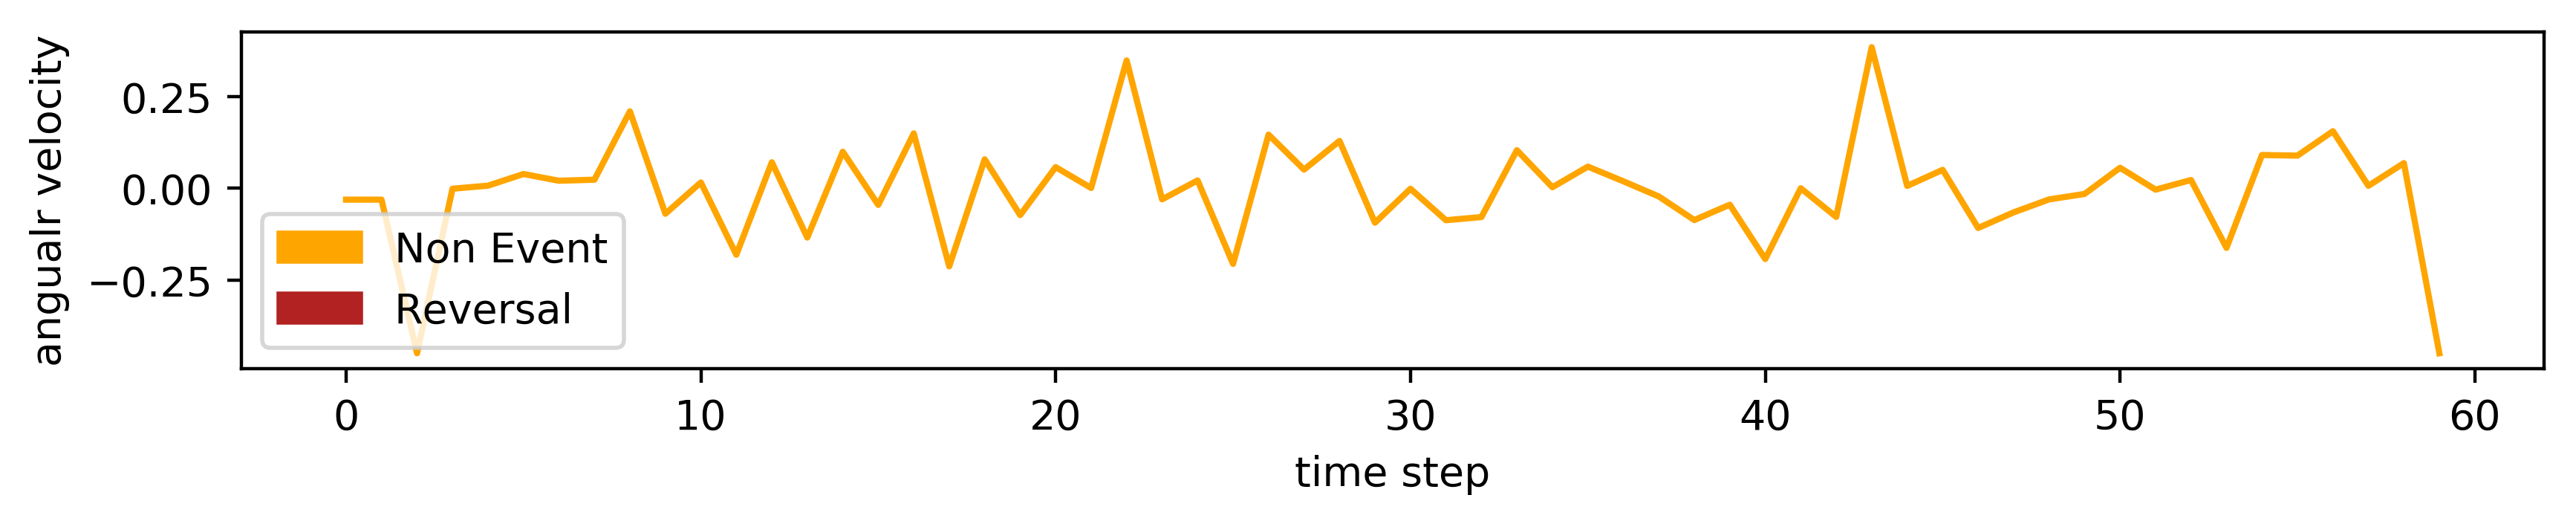

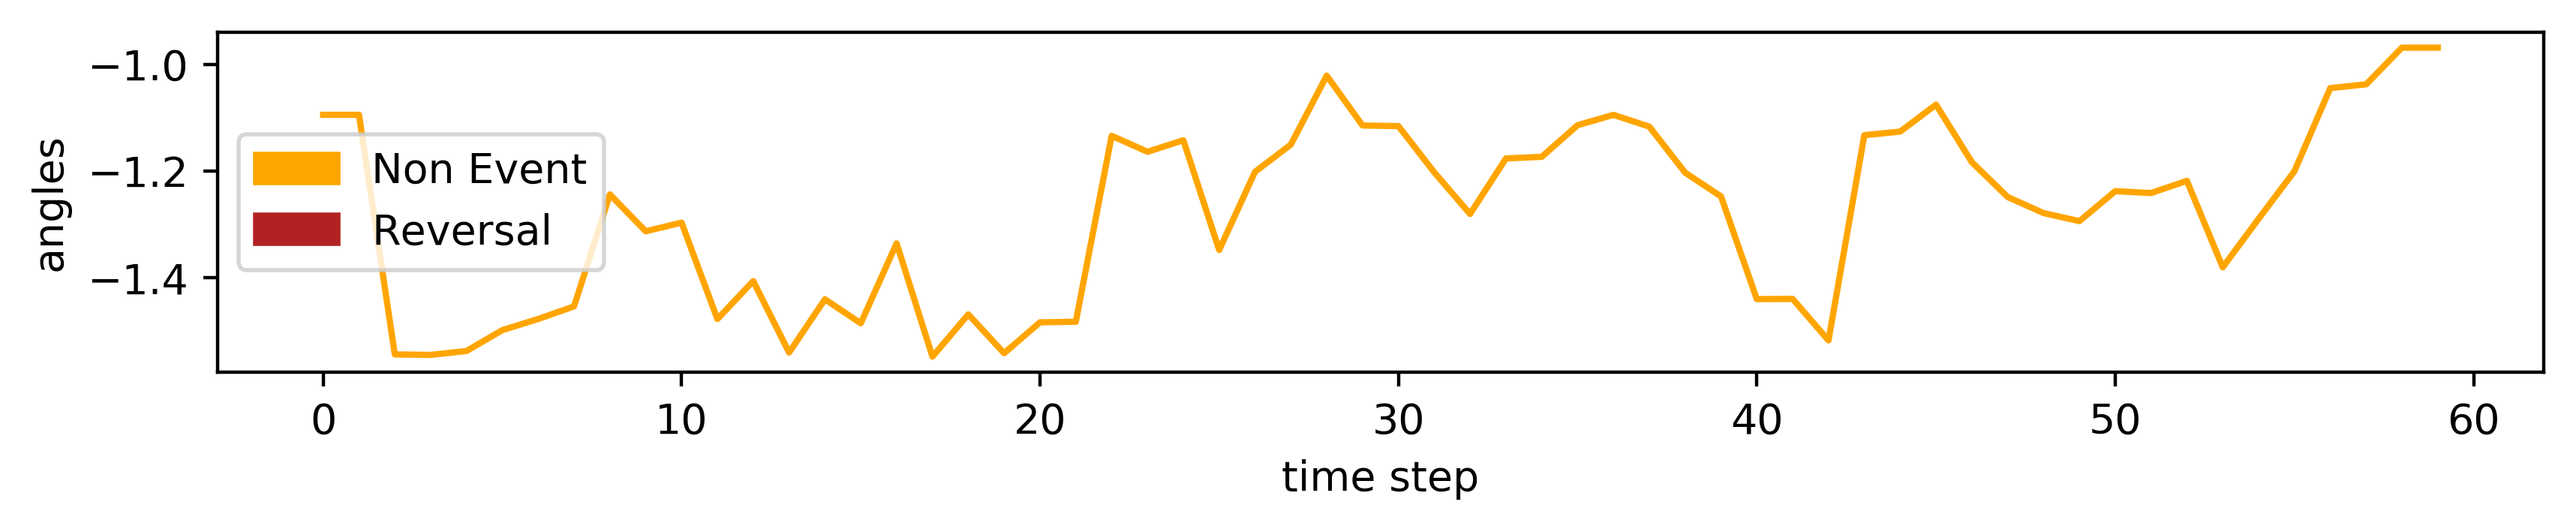

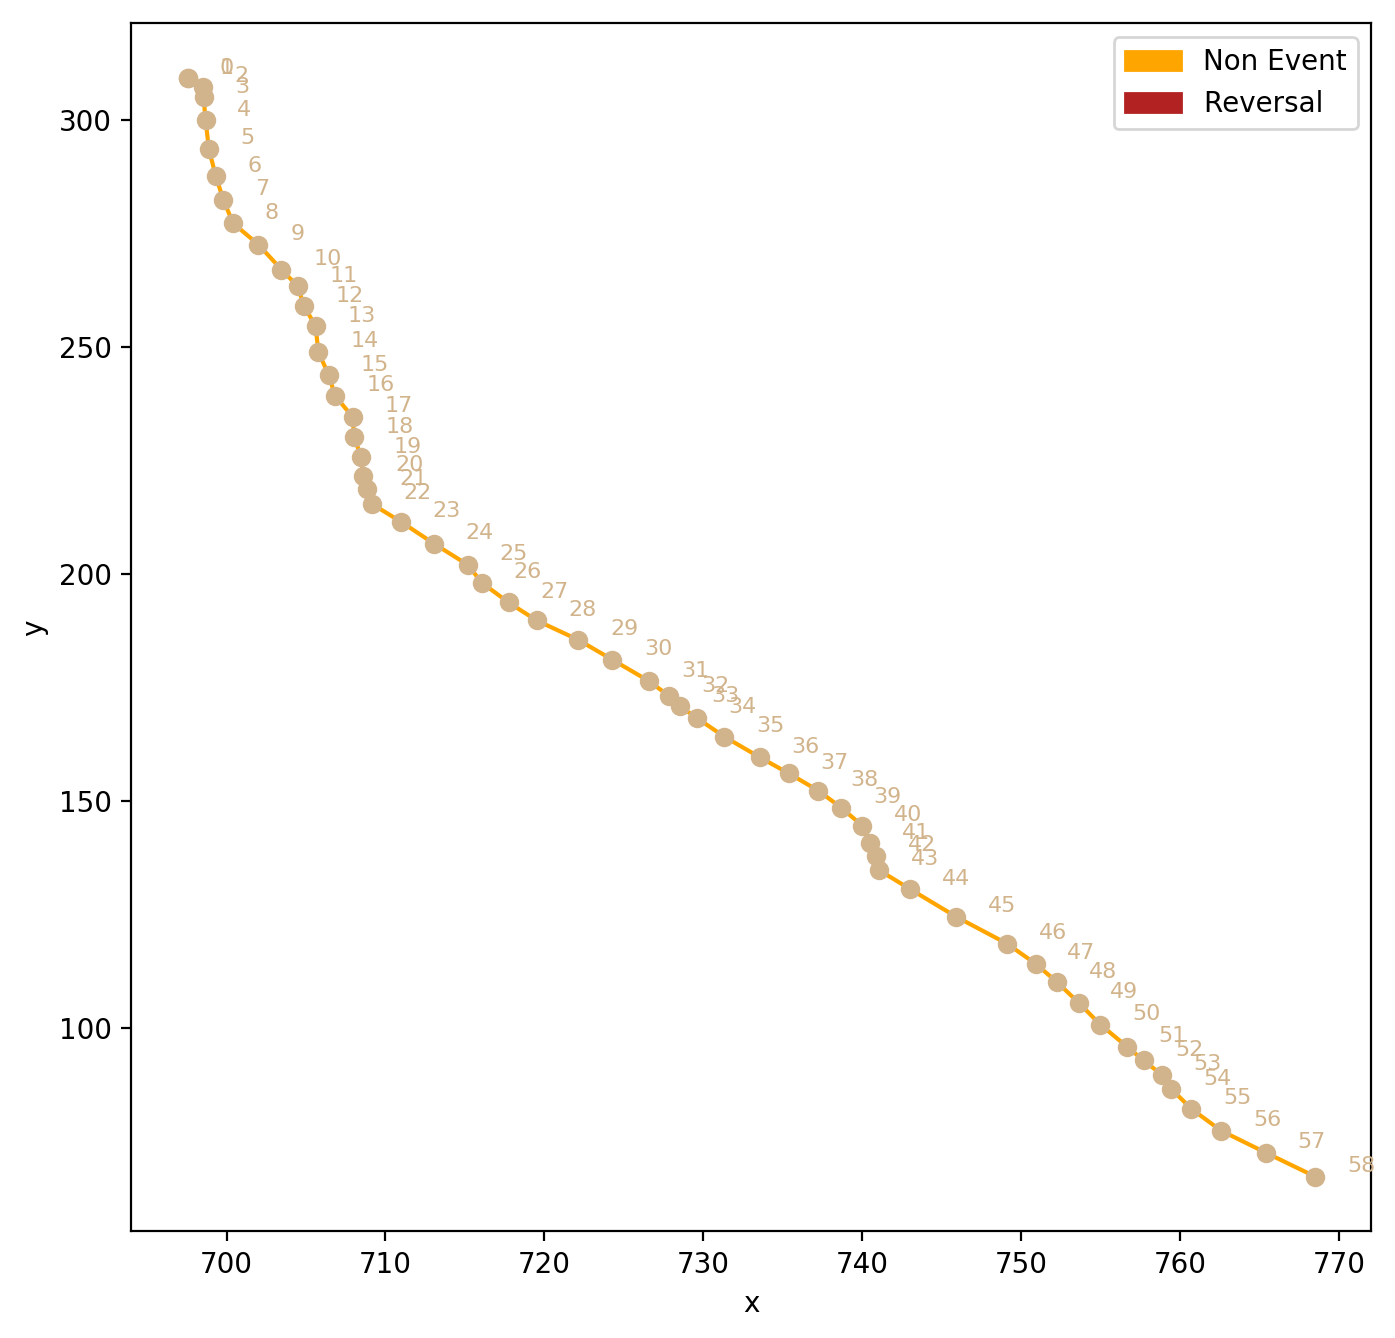

This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 7
local minimum value: 0.391407078212
value before min: 3.18860431103
value after min: 5.36795006569
deltav/2: 4.43837848825
v_upper: 2.16675847351
Index_endleft 7
Index_endright 7
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 43
local minimum value: 1.03543006097
value before min: 3.36411826993
value after min: 4.18737717188
deltav/2: 4.57603524641
v_upper: 2.86584415953
Index_endleft 43
Index_endright 43
This local minimum is smaller than deltav/2 -----------------------------
local minimum step: 54
local minimum value: 1.50287377118
value before min: 4.69796459107
value after min: 2.97117805855
deltav/2: 4.08690545187
v_upper: 3.13763595193
Index_endleft 54
Index_endright 55


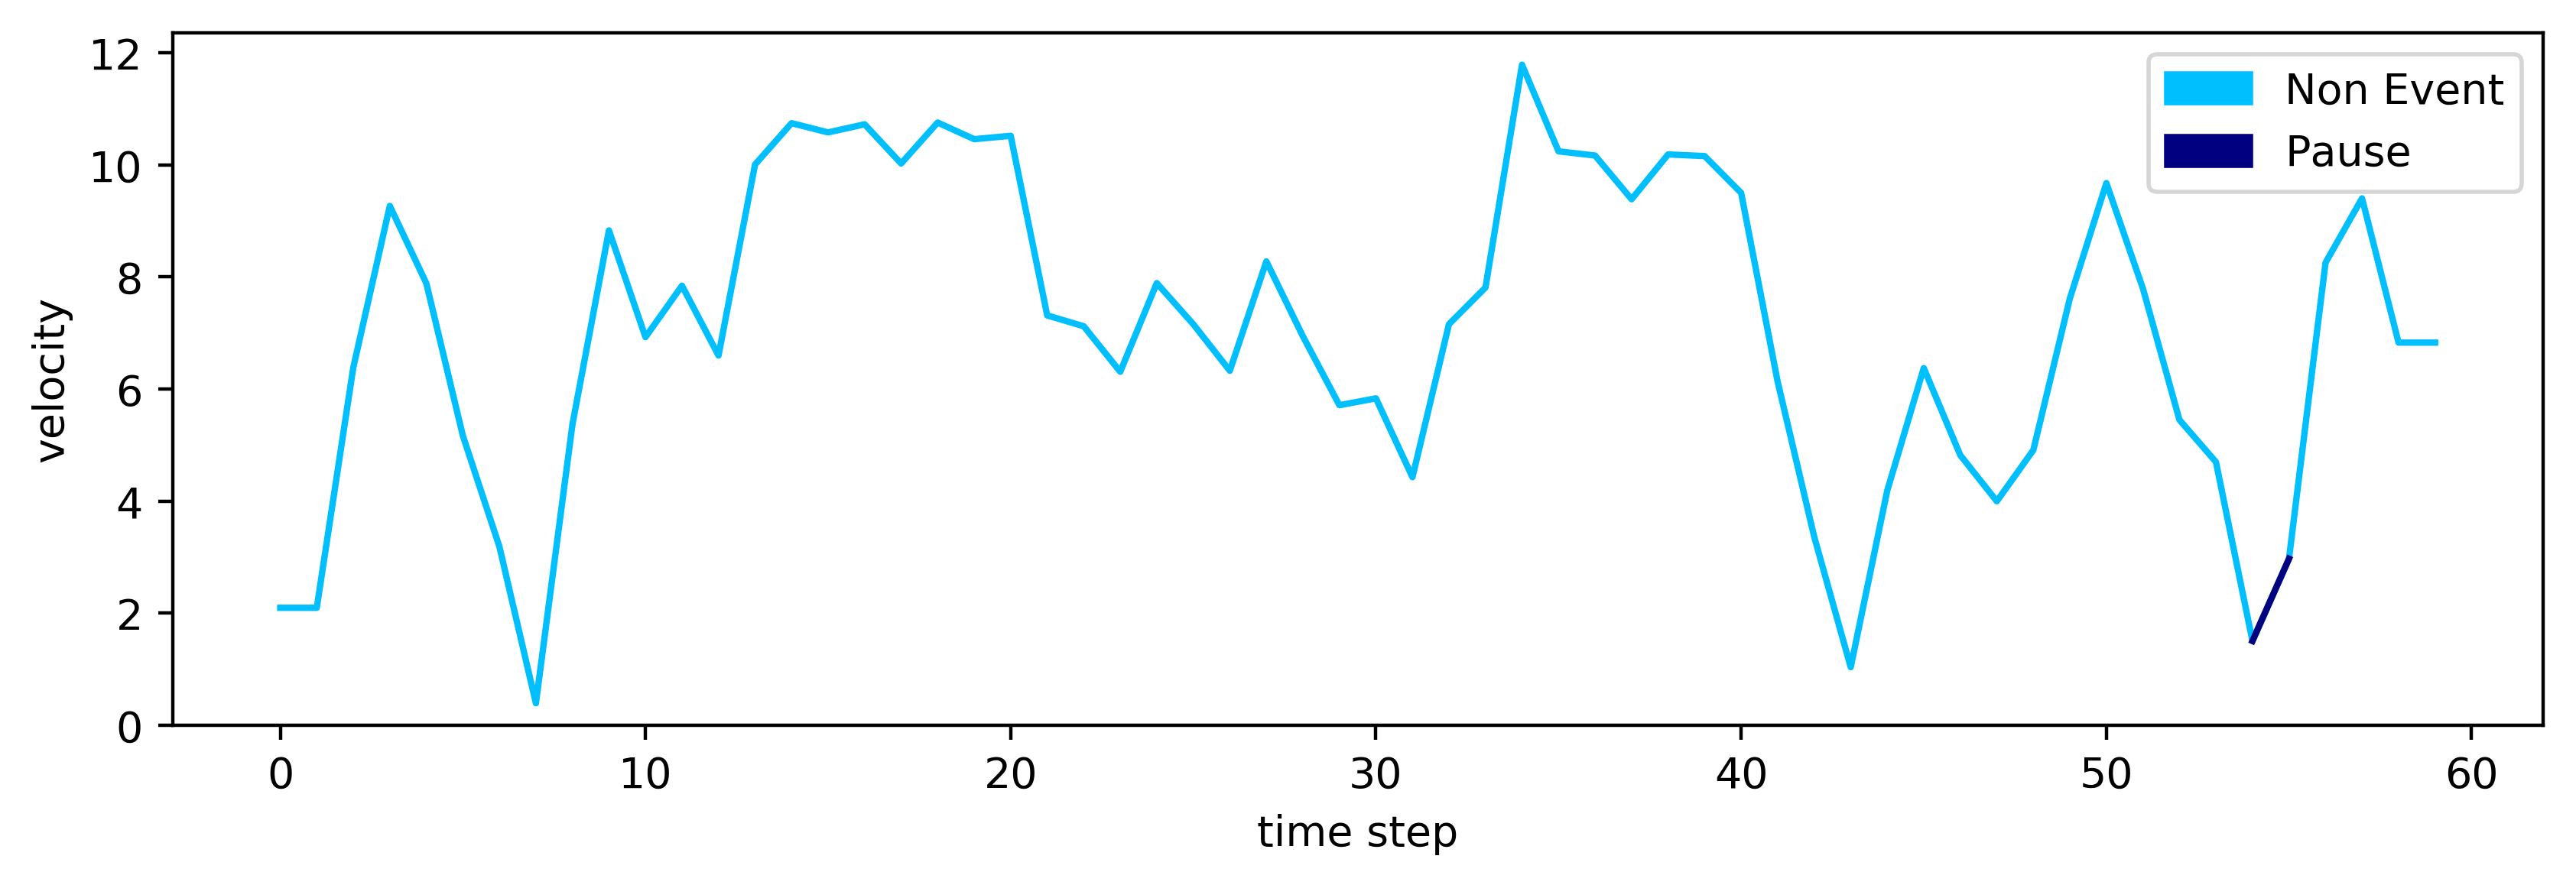

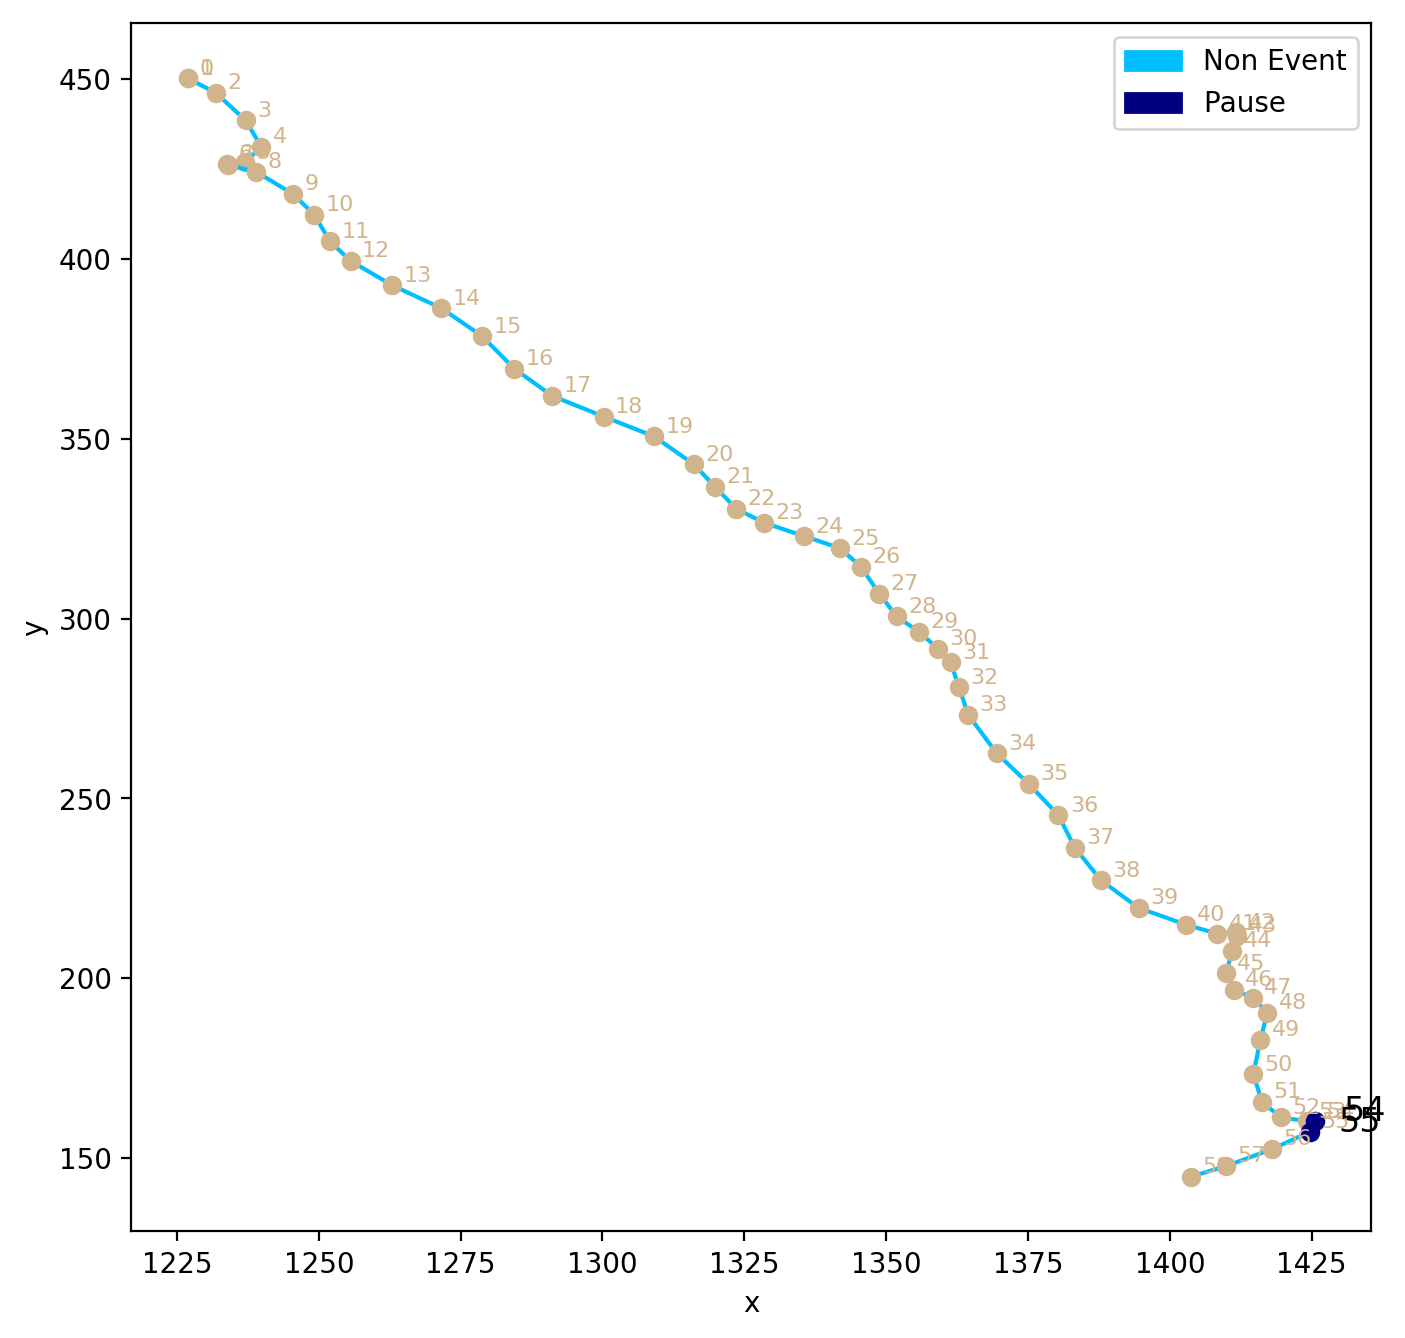

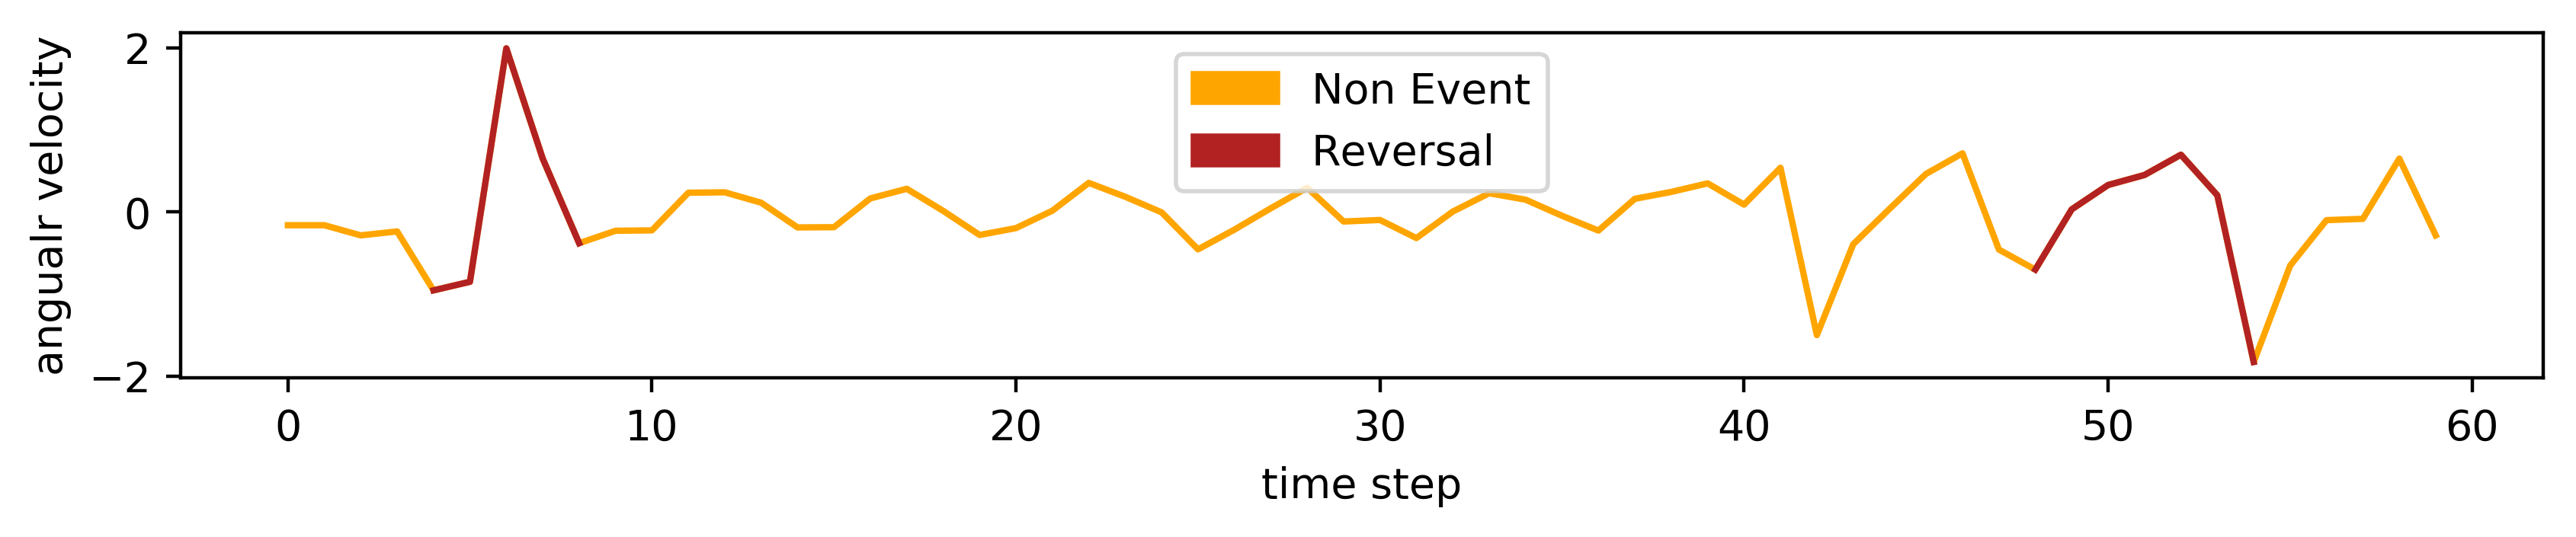

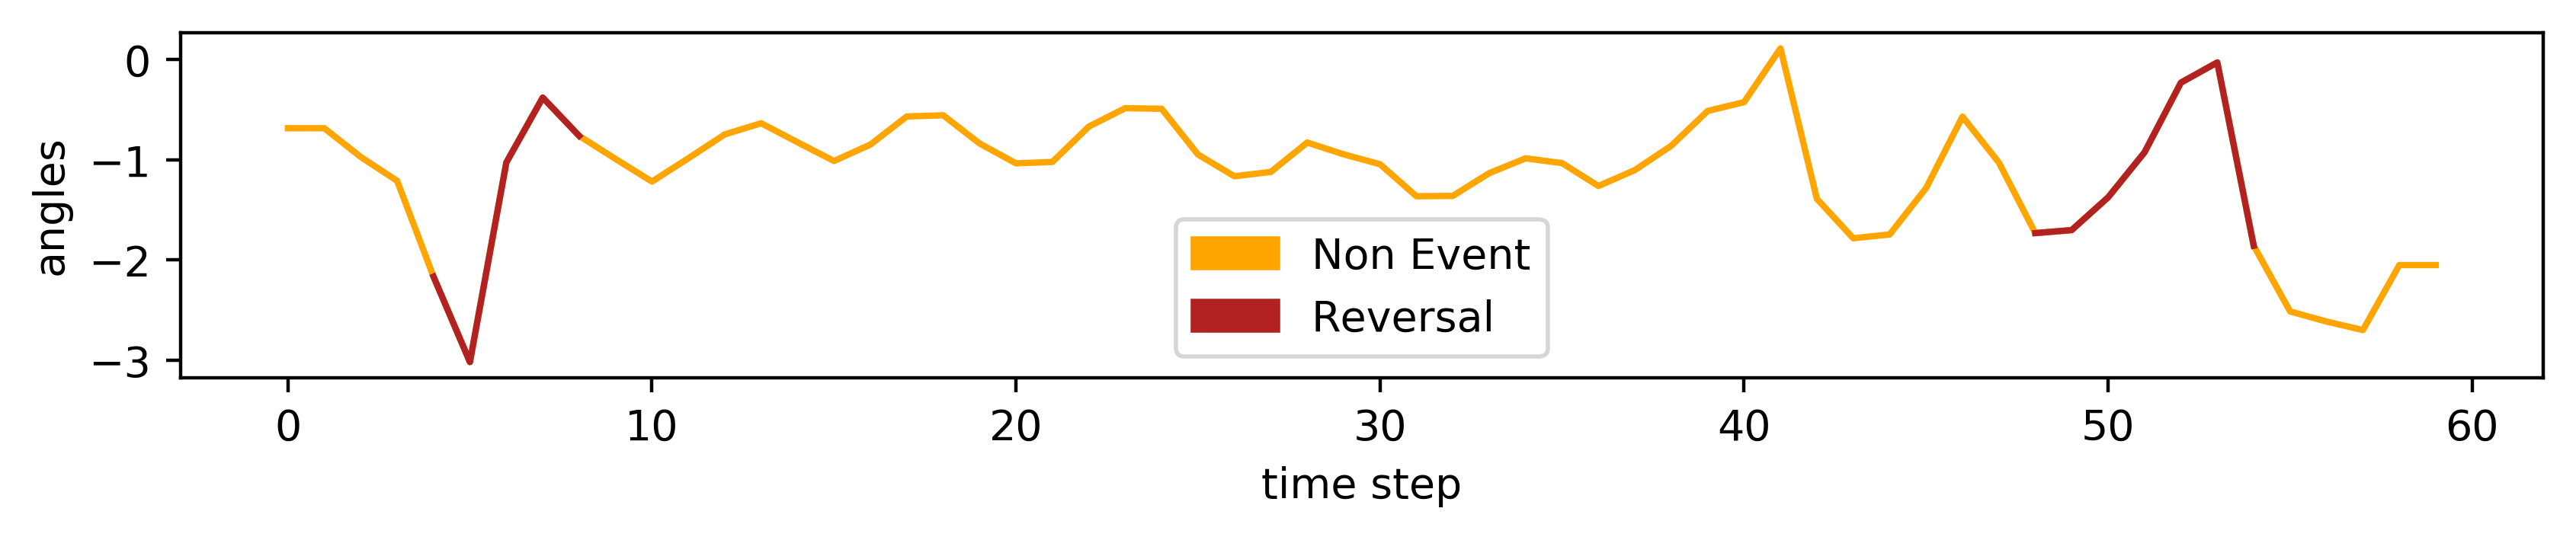

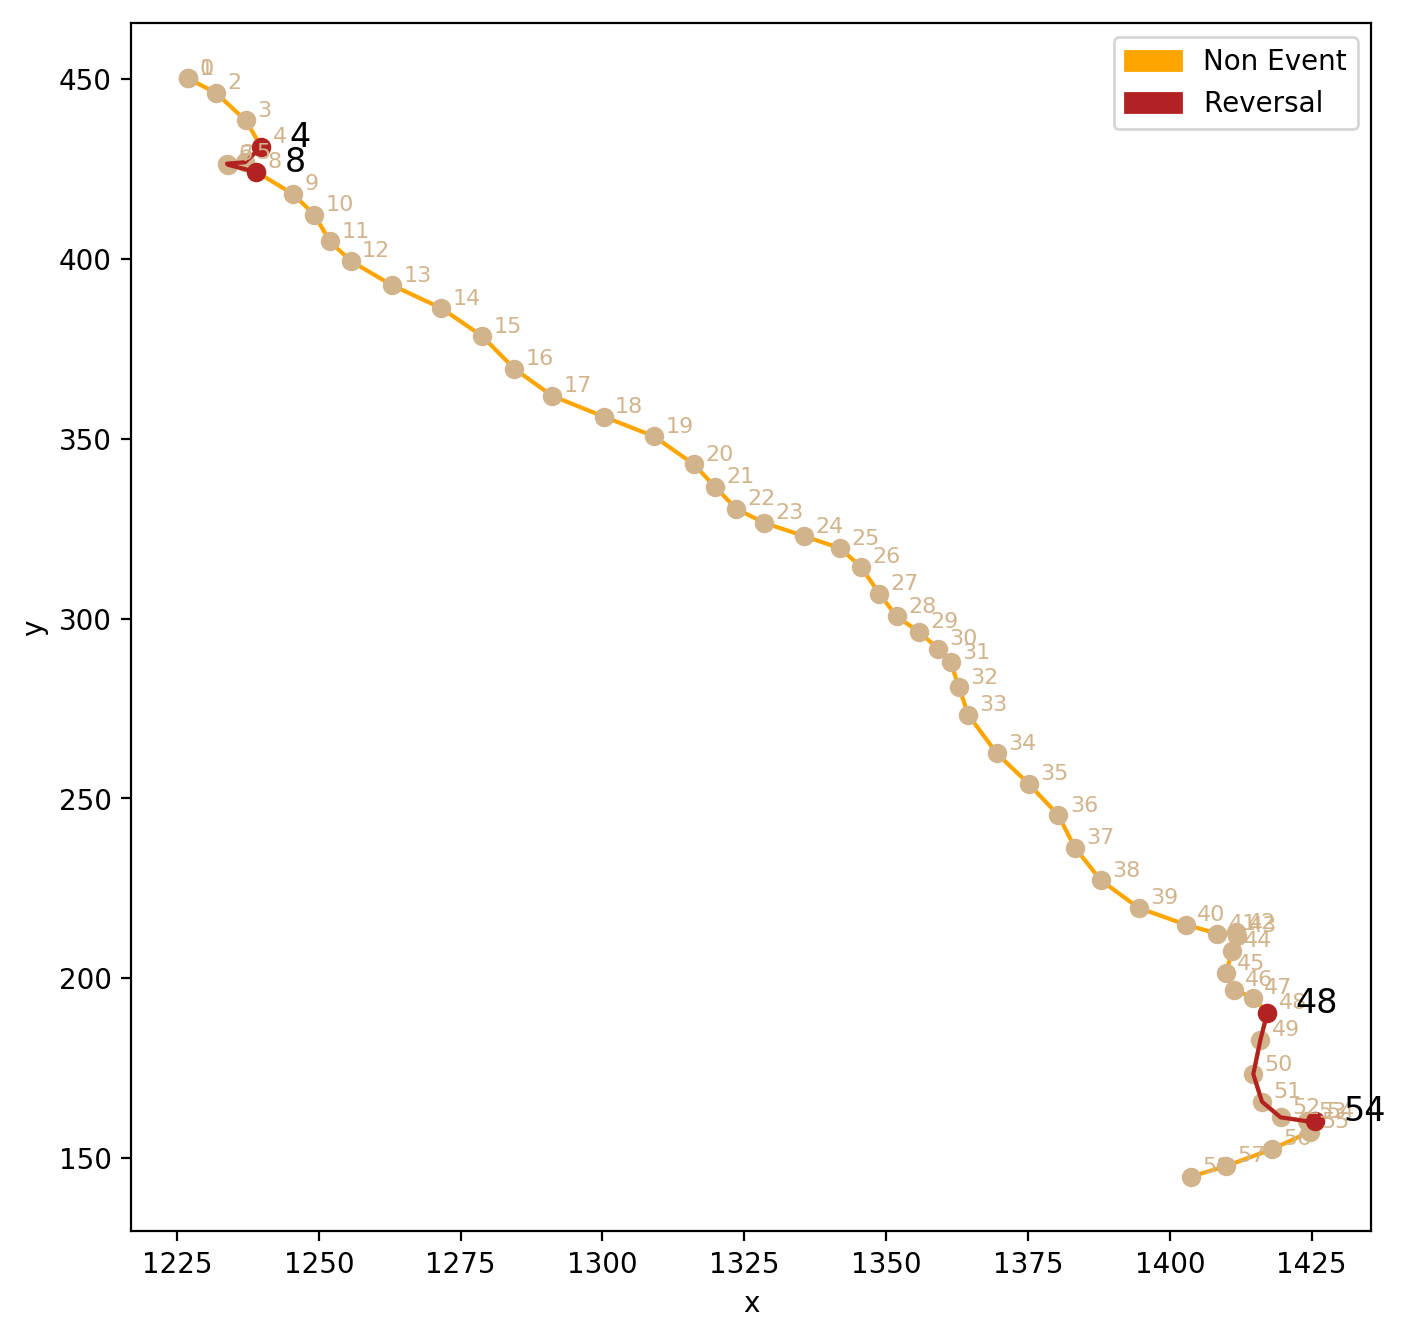

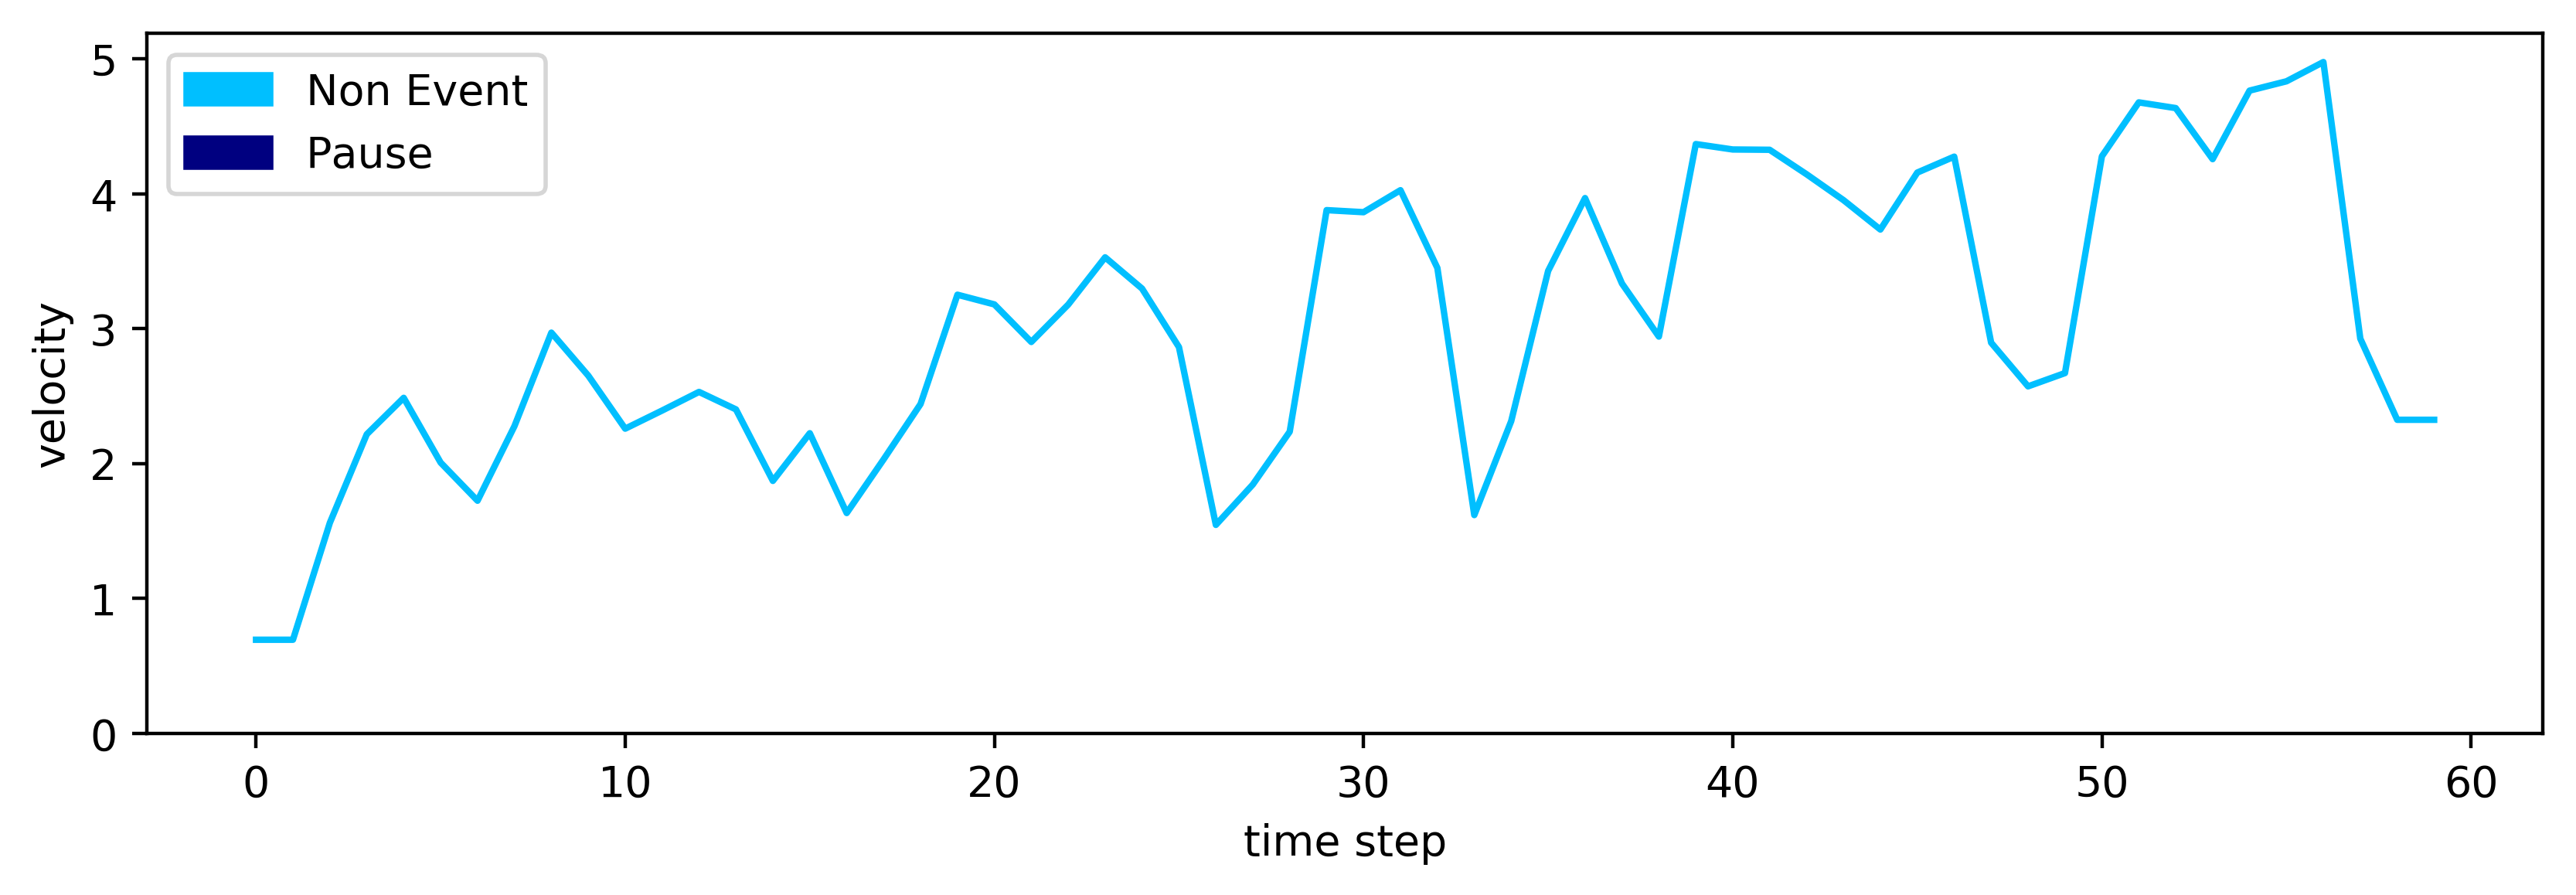

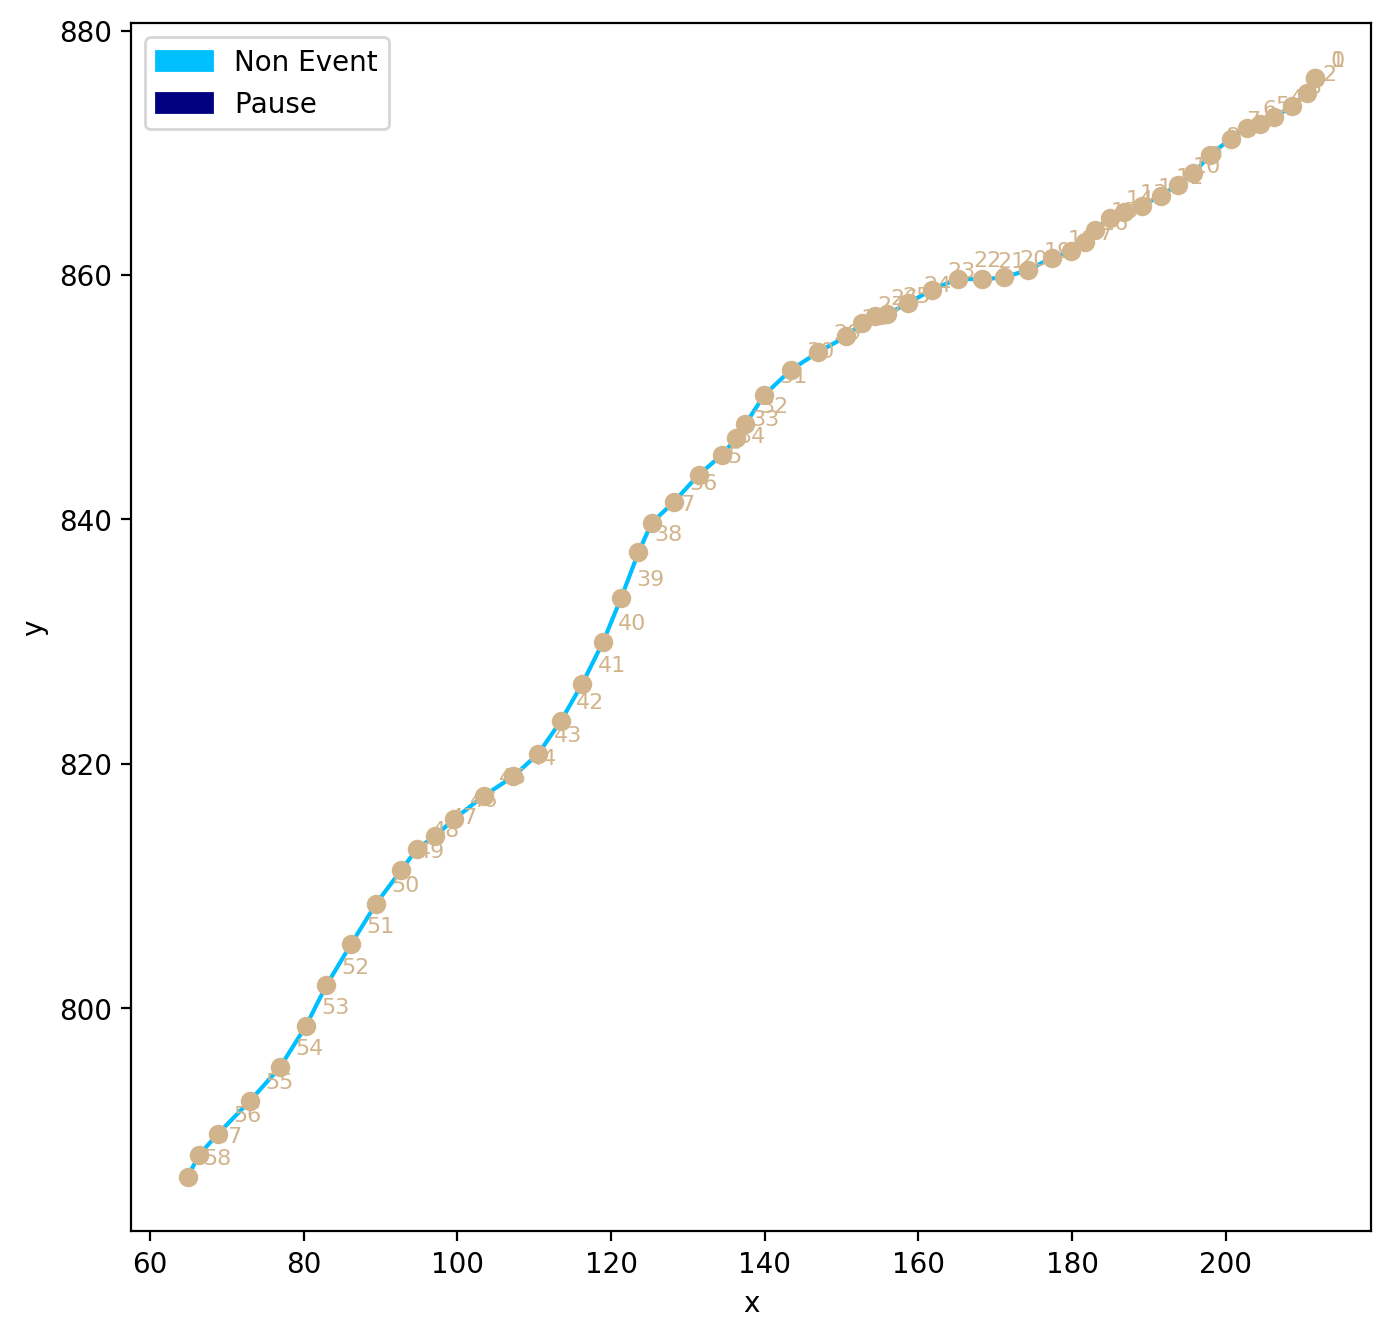

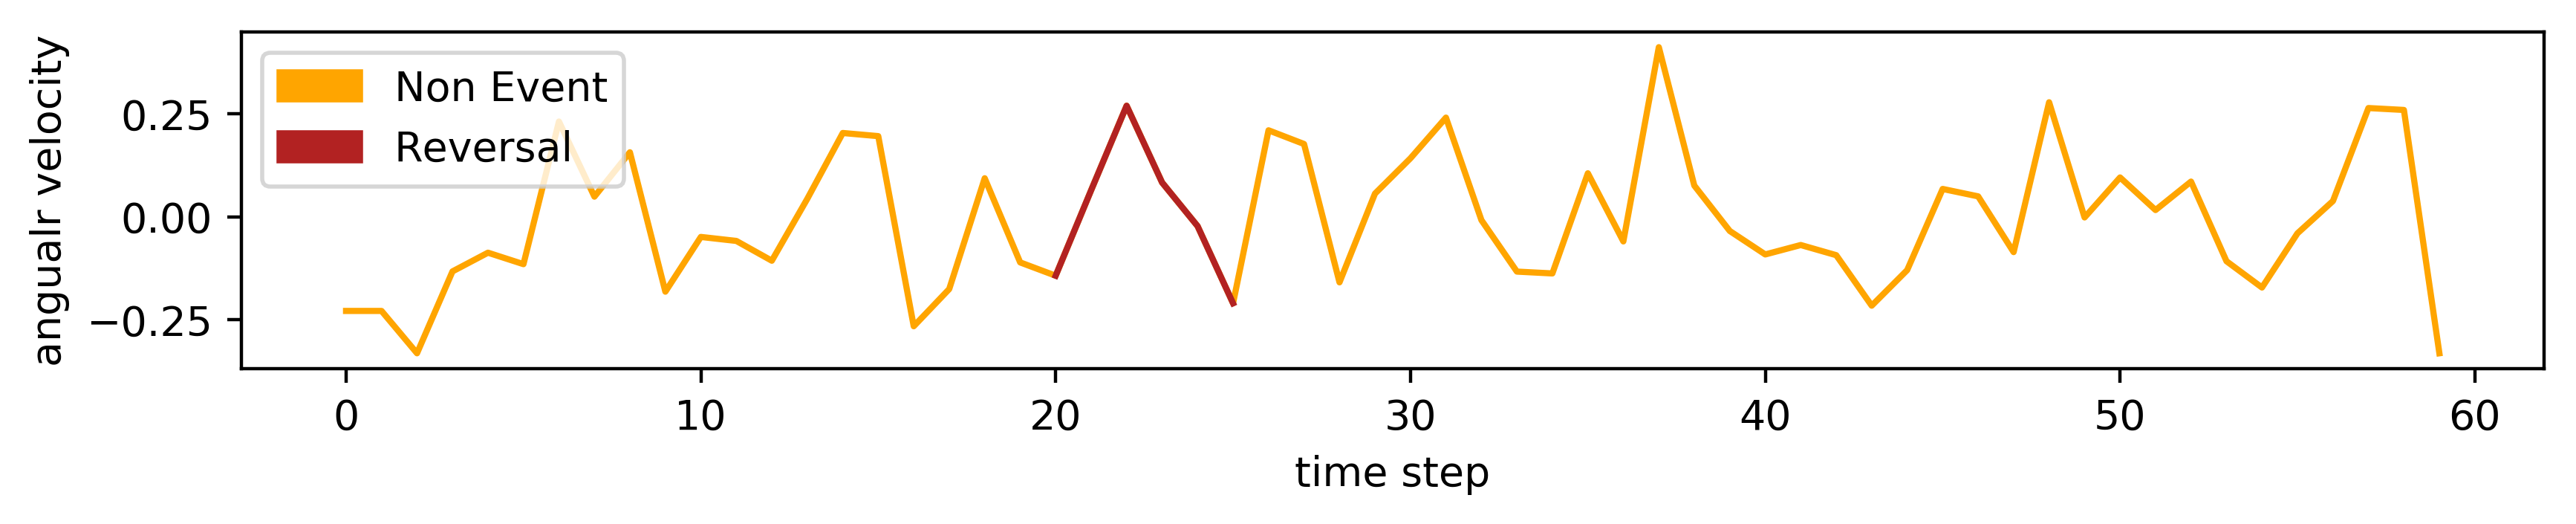

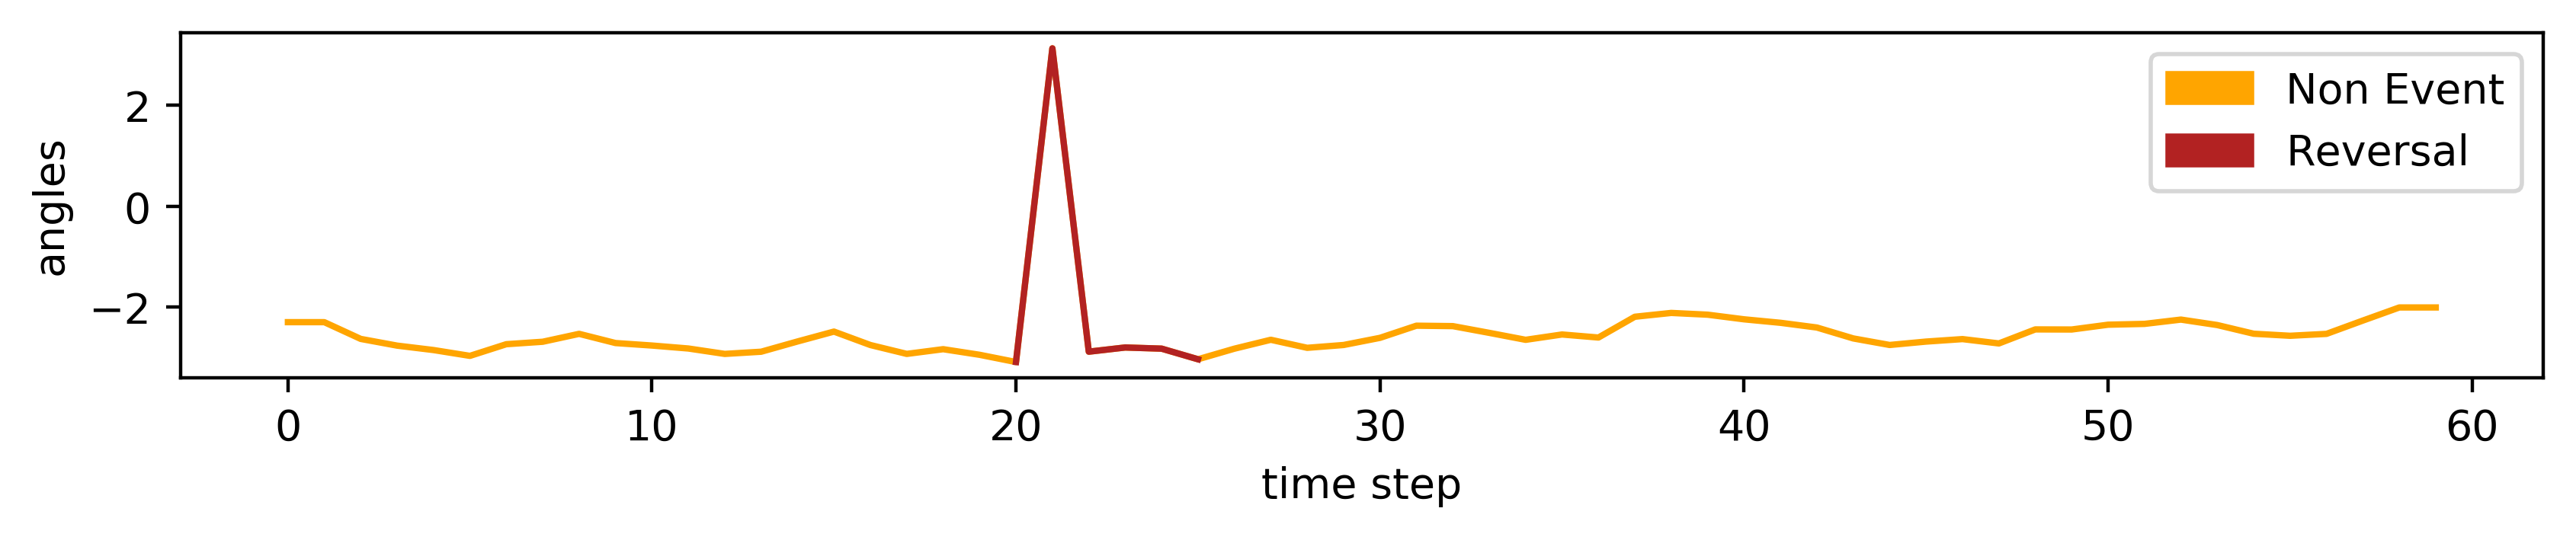

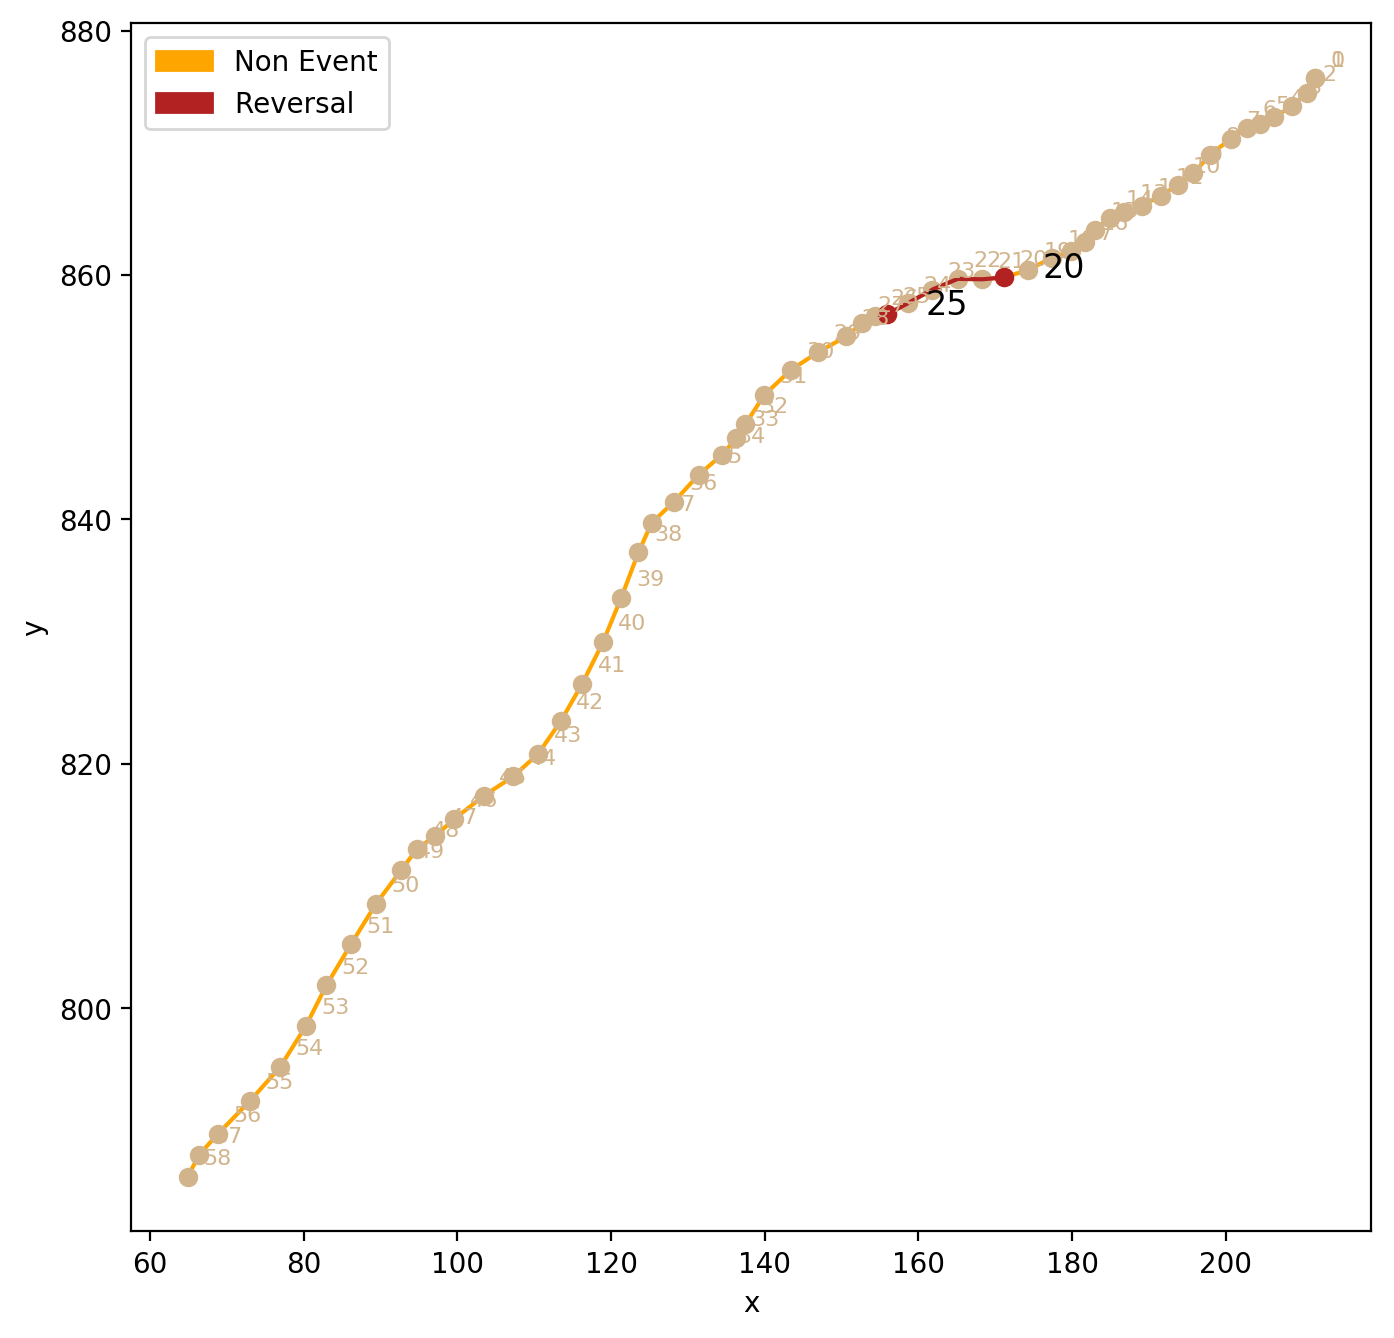

In [428]:
classname_list = os.listdir(os.path.join("npy", "3xyang3angvav2event"))
class_data = np.load(os.path.join("npy", "3xyang3angvav2event", classname_list[0]))
sample_n = 200
for i in range(10):
    sample_data = class_data[sample_n+i, :, :]
    coor = sample_data[:,:2]
    ang = sample_data[:,3]
    v = sample_data[:,4]
    av = sample_data[:,5]
    pause = sample_data[:,6]
    rev = sample_data[:,7]
    PlotPause(v)
    PlotTrajectory(coor, pause, 'pause')
    PlotReversal(ang,av)
    PlotTrajectory(coor, rev, 'reversal')

#### Generate event labels
The label is a binery sequence. 1 for event, 0 for non-event. Each sample will have two label sequences.

In [345]:
classname_list = os.listdir(os.path.join("npy", "3xyang3angvav"))
for classfile in classname_list:
    classfile_path = os.path.join("npy", "3xyang3angvav",classfile)
    class_coor_vav = np.load(classfile_path)
    
    class_coor_vav_event=[]
    for sample_coor_vav in class_coor_vav:
        PauseSeq =  np.array(VSeq2PauseSeq(sample_coor_vav[:,4]))
        ReversalSeq = np.array(AngAvSeq2ReversalSeq(sample_coor_vav[:,3], sample_coor_vav[:,5]))
        sample_coor_vav_event = np.column_stack((sample_coor_vav,PauseSeq, ReversalSeq))
        class_coor_vav_event.append(sample_coor_vav_event)
    class_coor_vav_event = np.array(class_coor_vav_event)     
    class2EventSeq_path = os.path.join("npy","3xyang3angvav2event", classfile[:-10]+"event.npy")
    np.save(class2EventSeq_path, class_coor_vav_event)
    print(class2EventSeq_path, "with shape:", class_coor_vav_event.shape, "is saved")


npy\3xyang3angvav2event\class0_A1_844_event.npy with shape: (844, 60, 8) is saved
npy\3xyang3angvav2event\class1_A4_1029_event.npy with shape: (1029, 60, 8) is saved
npy\3xyang3angvav2event\class2_S7_1317_event.npy with shape: (1317, 60, 8) is saved
npy\3xyang3angvav2event\class3_Y1_1098_event.npy with shape: (1098, 60, 8) is saved
npy\3xyang3angvav2event\class4_Y4_1029_event.npy with shape: (1029, 60, 8) is saved


In [427]:
def PlotTrajectory(coor, BinSeq, label):

    BinSeq= list(BinSeq)
    x_plot = []
    for i in range(1, len(BinSeq)-1):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start, end]) 
  
    plt.figure(figsize=(8, 8), dpi=200)
    for i in range(len(coor)-1):
        #print(i)
        x = [coor[i][0],coor[i+1][0]]
        y = [coor[i][1],coor[i+1][1]]
        #print(x,y)
        if label=='pause':
            plt.plot(x, y, color='deepskyblue')
        elif label=='reversal':
            plt.plot(x, y, color='orange')
        px = coor[i][0]
        py = coor[i][1]
        plt.plot(px, py, 'bo', color='tan')
        plt.text(px+2, py+1, i, fontsize=8,color='tan')

    points = []
    for event_dur in x_plot:
        a = []; b =[]
        for i in range(event_dur[0],event_dur[1]+1):
            a.append(coor[i][0])
            b.append(coor[i][1])
        if label=='pause':
            plt.plot(a, b, color='navy')
        elif label=='reversal':
            plt.plot(a, b, color='firebrick')
        point1 = [coor[event_dur[0]][0], coor[event_dur[0]][1],event_dur[0]]
        points.append(point1)
        point2 = [coor[event_dur[1]][0], coor[event_dur[1]][1],event_dur[1]]
        points.append(point2)

    for i in range(len(points)):
        x = points[i][0]
        y = points[i][1]
        if label=='pause':
            plt.plot(x, y, 'bo', color='navy')
        elif label=='reversal':
            plt.plot(x, y, 'bo', color='firebrick')
        plt.text(x+5, y, points[i][2], fontsize=12)

    if label=='pause':
        plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Pause')])
    elif label=='reversal':
        plt.legend(handles=[mpatches.Patch(color='orange', label='Non Event'), 
                        mpatches.Patch(color='firebrick', label='Reversal')])
    plt.xlabel("x")
    plt.ylabel("y")
  
    plt.show()
    #return 1